In [1]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 읽기를 위한 라이브러리
import numpy as np
np.random.seed(0)
import pandas as pd
import gc, os, time
from pandas import DataFrame, Series
from datetime import datetime, date, timedelta
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 탐색적 데이터 분석을 위한 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, probplot, boxcox

# 모델링을 위한 라이브러리
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_regression, VarianceThreshold

import pickle

pd.set_option('display.max_columns',999)

from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
sns.set_style('dark')

def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

In [2]:
# 학습용 데이터 
train_sensor = pd.read_csv('train_sensor.csv')
train_quality = pd.read_csv('train_quality.csv')
# 평가용 데이터 
predict_sensor = pd.read_csv('predict_sensor.csv')

In [3]:
def make_dataset(X, y=None):
    
    # -----------------------------------
    # train_sensor (X 인자)
    # -----------------------------------
    ''' column을 param_alias 로만 pivot table 만들기. '''
    df_X = X.copy()
    df_X = df_X.sort_values(by='end_time',ascending=True)
    df_X['step_id'] = df_X['step_id'].apply(lambda x: str(x).zfill(2))
    # step_id 와 param_alias 를 결합한 임시 컬럼 step_param 을 생성합니다. ex. 17_EPD_para4
    df_X['step_param'] = df_X[['step_id', 'param_alias']].apply(lambda x: '_'.join(x), axis=1)
    df_X_tmp = df_X.pivot_table(index = ['module_name','key_val'], columns = 'step_param', values='mean_val', aggfunc='sum')
    # 데이터 통합을 위해 인덱스를 key_val 로 재설정합니다. 
    df_X_tmp = df_X_tmp.reset_index(level=[0, 1])
    df_X_tmp.set_index('key_val', inplace=True)

    # -----------------------------------
    # 시간 데이터 
    # -----------------------------------
    ''' step별 end_time을 column으로 pivot table 만들기 '''
    df_X['end_time_tmp'] = df_X.apply(lambda x: x['step_id'] + '_end_time', axis=1)
    df_X['end_time'] = pd.to_datetime(df_X['end_time'])
    # end_time 은 센서 데이터가 각 para 별로 서버에 도달한 시간으로 스텝 내 오차가 발생할 수 있습니다. 동일 스텝 구간내 공정 완료 시간이 다른 경우, min 함수를 사용하여 최초 수집된 time을 가져옵니다.
    df_time_tmp = df_X.pivot_table(index = ['key_val'], columns = 'end_time_tmp', values='end_time', aggfunc=lambda x : min(x.unique()))
    df_time_tmp = df_time_tmp.reset_index()
    df_time_tmp.set_index('key_val', inplace=True)

    # -----------------------------------
    # train_quality (y 인자)
    # -----------------------------------

    if y is None : # 평가용 데이터 
        col_target = []
        col_idx = ['module_name', 'key_val']
        df_complete = pd.concat([df_X_tmp, df_time_tmp], axis=1).reset_index()
        df_complete.rename(columns={'index':'key_val'},inplace=True)
    else : # 학습용 데이터 
        df_y = y.copy()
        df_y.set_index('key_val', inplace=True)
        col_target = ['y']
        col_idx = ['module_name', 'key_val', 'end_dt_tm']
        # 센서 데이터, 시간데이터, 품질지표에 대하여 인덱스(key_val)기준으로 데이터프레임을 통합합니다.
        df_complete = pd.concat([df_X_tmp, df_time_tmp, df_y], axis=1).reset_index()
        # 컬럼 이름을 변경합니다.  
        df_complete.rename(columns={'msure_val':'y'}, inplace=True)
        df_complete.rename(columns={'index':'key_val'},inplace=True)


    # 컬럼 순서를 정렬합니다. 
    col_feats = df_X['step_param'].unique().tolist()
    col_feats.sort()
    col_time = [s for s in df_complete.columns.tolist() if "_end_time" in s]
    col_all = col_idx + col_target + col_feats + col_time
    df_complete = df_complete[col_all]
    # 처음 step이 시작된 시점을 기준으로 다시 정렬(APC value를 먹고 들어가는 값을 기준으로 정렬하고 싶었음.)
    df_complete = df_complete.set_index(['module_name','key_val','04_end_time']).sort_index(level=[0,2,1],ascending=True).reset_index()
    df_complete = df_complete[col_all]
    
    # 컬럼을 소문자로 변경합니다. 
    df_complete.columns = df_complete.columns.str.lower()

    return df_complete

# 학습용 데이터 
train = make_dataset(train_sensor, train_quality)
# 평가용 데이터 
predict = make_dataset(predict_sensor)

In [4]:
print(len(train.columns))
print(len(predict.columns))

676
674


In [5]:
# 전체 및 개별 공정 소요시간 변수를 생성하는 함수입니다.
def gen_tmdiff(df, lst_stepsgap):
    df['gen_tmdiff'] = (df['20_end_time'] - df['04_end_time']).dt.total_seconds()
    for stepgap in lst_stepsgap:
        df[f'gen_tmdiff_{stepgap}'] = (df[f'{stepgap[2:]}_end_time'] - df[f'{stepgap[:2]}_end_time']).dt.total_seconds()
    return df

# 4. 데이터 전처리

In [6]:
# 전처리를 위한 학습용 데이터와 평가용 데이터를 복사합니다.
df_train = train.copy()
df_predict = predict.copy()

In [7]:
# 센서 컬럼과 날짜 컬럼을 정의합니다. 
col_sensor = df_train.iloc[:, 4:-7].columns.tolist() 
col_time = df_train.filter(regex='end').columns.tolist() 

assert len(col_sensor) == 665
assert len(col_time) == 8 

# 3.4절 공정 소요시간 분석에 필요한 변수를 정의합니다. 
lst_steps = ['04','06','12','13','17','18', '20']
lst_stepsgap = ['0406','0612','1213','1317','1718','1820']

''' step별로 fdc para명 따로 수집 '''
lst_sensors = []
for step in lst_steps:
    _ = [col for col in col_sensor if col[:2] == step]
    lst_sensors.append(_)

sensors_nm = list(map(lambda x: x[3:], lst_sensors[0]))

# 시간과 관련한 분석을 진행하기 위하여 날짜형으로 변환합니다. 
df_train[col_time] = df_train[col_time].apply(pd.to_datetime)

In [8]:
df_train = gen_tmdiff(df_train, lst_stepsgap)
df_predict = gen_tmdiff(df_predict, lst_stepsgap)
df_train.filter(regex='tmdiff').head(2)

,gen_tmdiff,gen_tmdiff_0406,gen_tmdiff_0612,gen_tmdiff_1213,gen_tmdiff_1317,gen_tmdiff_1718,gen_tmdiff_1820
0,1912.0,146.0,846.0,16.0,477.0,16.0,411.0
1,1911.0,145.0,847.0,16.0,476.0,16.0,411.0


In [9]:
STEP17_COLS = df_train.filter(regex='^17').columns.tolist()
STEP12_COLS = df_train.filter(regex='^12').columns.tolist()
df_train.drop(STEP17_COLS+STEP12_COLS, axis=1, inplace=True)
df_predict.drop(STEP17_COLS+STEP12_COLS, axis=1, inplace=True)

df_train.drop(['gen_tmdiff_1213','gen_tmdiff_1718'], axis=1, inplace=True)
df_predict.drop(['gen_tmdiff_1213','gen_tmdiff_1718'], axis=1, inplace=True)

In [10]:
for_col_filter = []
for para in sensors_nm:
    for_col_filter.append(para.split('_')[0])
for_col_filter = list(set(for_col_filter))
for_col_filter

['temp',
 'position',
 'time',
 'fr',
 'pressure',
 'he',
 'efem',
 'tmp',
 'gas',
 'esc',
 'power',
 'epd',
 'hv']

In [11]:
''' CATEGORY 변수 처리 및 NUM FEATURE 정의 '''
module2idx = {}
for i, module in enumerate(df_train['module_name'].unique()):
    module2idx[module] = i
    
def col2cat(df, col, dict):
    df[col] = df[col].apply(lambda x: dict[x])
    df[col] = df[col].astype('category')
    return df[col]

# module_name cat 화
col2cat(df_train, 'module_name', module2idx)
col2cat(df_predict, 'module_name', module2idx)

0       0
1       0
2       0
3       0
4       0
       ..
257    45
258    46
259    46
260    46
261    46
Name: module_name, Length: 262, dtype: category
Categories (47, int64): [0, 1, 2, 3, ..., 43, 44, 45, 46]

In [12]:
# 우선 단일 columns 제거.
unique_col = df_train.loc[:,df_train.nunique()==1].columns.tolist()
df_train.drop(unique_col, axis=1, inplace=True)
df_predict.drop(unique_col, axis=1, inplace=True)

# FR 전처리

In [13]:
PARA28_COLS = ['04_fr_para28','13_fr_para28','20_fr_para28']
PARA35_COLS = ['06_fr_para35']
PARA69_COLS = ['04_fr_para69','20_fr_para69']
df_train.drop(PARA28_COLS+PARA69_COLS+PARA35_COLS, axis=1, inplace=True)

# ESC 전처리

In [14]:
PARA84_COLS = ['04_esc_para84','20_esc_para84']
df_train.drop(PARA84_COLS, axis=1, inplace=True)
df_predict.drop(PARA84_COLS, axis=1, inplace=True)

# POWER 전처리

In [15]:
df_train.drop('04_power_para57', axis=1, inplace=True)
df_predict.drop('04_power_para57', axis=1, inplace=True)

# HE 전처리

In [16]:
HE_PARA95 = df_train.filter(regex='he_para95$').columns.tolist()
df_train.drop(HE_PARA95, axis=1, inplace=True)
df_predict.drop(HE_PARA95, axis=1, inplace=True)

# GAS 전처리

In [17]:
''' drop해야 하는 애들 '''
# all step
DROP_ALL = ['gas_para10','gas_para19','gas_para48','gas_para70']
for para in DROP_ALL:
    df_train.drop(df_train.filter(regex=para+'$').columns.tolist(),axis=1, inplace=True)
    
GAS_PARA13 = ['20_gas_para13']
GAS_PARA15 = df_train.filter(regex='gas_para15$').columns.tolist()
GAS_PARA15 = [col for col in GAS_PARA15 if col not in ['04_gas_para15']]
GAS_PARA27 = ['04_gas_para27','06_gas_para27','20_gas_para27']
GAS_PARA33 = ['04_gas_para33','06_gas_para33','13_gas_para33','18_gas_para33']
GAS_PARA39 = df_train.filter(regex='gas_para39$').columns.tolist()
GAS_PARA39 = [col for col in GAS_PARA39 if col not in ['20_gas_para39']]
GAS_PARA46 = ['04_gas_para46','06_gas_para46']
GAS_PARA50 = df_train.filter(regex='gas_para50$').columns.tolist()
GAS_PARA50 = [col for col in GAS_PARA50 if col not in ['20_gas_para50']]
# GAS_PARA51 = ['06_gas_para51','12_gas_para51','17_gas_para51','20_gas_para51']
GAS_PARA51 = ['06_gas_para51','20_gas_para51']
GAS_PARA59 = ['04_gas_para59']
GAS_PARA71 = df_train.filter(regex='gas_para71$').columns.tolist()
GAS_PARA71 = [col for col in GAS_PARA71 if col not in ['06_gas_para71']]
GAS_PARA74 = ['06_gas_para74','13_gas_para74','18_gas_para74','20_gas_para74']
GAS_PARA85 = df_train.filter(regex='gas_para85$').columns.tolist()
GAS_PARA85 = [col for col in GAS_PARA85 if col not in ['04_gas_para85']]

GAS_DROP_COL = GAS_PARA13+GAS_PARA15+GAS_PARA27+GAS_PARA33+GAS_PARA39+GAS_PARA46+GAS_PARA50+GAS_PARA51+GAS_PARA59+GAS_PARA71+GAS_PARA74+GAS_PARA85

df_train.drop(GAS_DROP_COL, axis=1, inplace=True)
df_predict.drop(GAS_DROP_COL, axis=1, inplace=True)

# TEMP 전처리

In [18]:
DROP_TEMP = ['temp_para11', '06_temp_para53','20_temp_para53', 'temp_para79', '20_temp_para87', '06_temp_para93','20_temp_para93', '04_temp_para17', '06_temp_para17']
for col in DROP_TEMP:
    cols = df_train.filter(regex=col+'$').columns.tolist()
    df_train.drop(cols,axis=1,inplace=True)
    df_predict.drop(cols,axis=1,inplace=True)

# TIME 전처리

In [19]:
df = df_train.filter(regex='time').drop(df_train.filter(regex='end_time$').columns.tolist(), axis=1)
time_para = []
for col in df.columns:
    time_para.append(col[3:])
time_para = sorted(list(set(time_para)))
time_para.remove('time_para5')    # 나중에 처리.

In [20]:
# 우선 RF TIME이 쭉 떨어진 애들만 COL만들기
for para in time_para:
    col = f'04_{para}'
    tmp_train = df_train.groupby('module_name')[col].shift(1).fillna(0)
    tmp_predict = df_predict.groupby('module_name')[col].shift(1).fillna(0)
    df_train[f'tmp_{para}'] = df_train[col]-tmp_train
    df_predict[f'tmp_{para}'] = df_predict[col]-tmp_predict
    df_train.loc[:, f'CLN_DAY_{para}'] = df_train[f'tmp_{para}'].apply(lambda x: 1 if x<=0 else 0)   # 전체 dataset에 대해서 처리돼있는 df,
    df_predict.loc[:, f'CLN_DAY_{para}'] = df_predict[f'tmp_{para}'].apply(lambda x: 1 if x<=0 else 0)
df_train.drop(df_train.filter(regex='^tmp').columns.tolist(), axis=1, inplace=True)
df_predict.drop(df_predict.filter(regex='^tmp').columns.tolist(), axis=1, inplace=True)

In [21]:
print('CLN columns added to TRAIN DATASET : {}'.format(len(df_train.filter(regex='^CLN').columns)))
print('CLN columns added to PREDICT DATASET: {}'.format(len(df_predict.filter(regex='^CLN').columns)))
df_train.filter(regex='^CLN').head(3)

CLN columns added to TRAIN DATASET : 21
CLN columns added to PREDICT DATASET: 21


,CLN_DAY_time_para16,CLN_DAY_time_para29,CLN_DAY_time_para30,CLN_DAY_time_para34,CLN_DAY_time_para37,CLN_DAY_time_para41,CLN_DAY_time_para42,CLN_DAY_time_para43,CLN_DAY_time_para44,CLN_DAY_time_para62,CLN_DAY_time_para64,CLN_DAY_time_para67,CLN_DAY_time_para7,CLN_DAY_time_para75,CLN_DAY_time_para77,CLN_DAY_time_para8,CLN_DAY_time_para81,CLN_DAY_time_para83,CLN_DAY_time_para89,CLN_DAY_time_para9,CLN_DAY_time_para90
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# 두줄 트렌드 TEST COL 추가

In [22]:
df_train['06_epd_para4_test'] = df_train['06_epd_para4'].apply(lambda x: 1 if x > 50 else 0)
df_train['20_epd_para4_test'] = df_train['20_epd_para4'].apply(lambda x: 1 if x < 900 else 0)
df_train['04_hv_para3_test'] = df_train['04_hv_para3'].apply(lambda x: 1 if x < 0.04 else 0)
df_train['04_hv_para45_test'] = df_train['04_hv_para45'].apply(lambda x: 1 if x < 150 else 0)
df_train['04_hv_para47_test'] = df_train['04_hv_para47'].apply(lambda x: 1 if x < 100 else 0)
df_train['04_hv_para56_test'] = df_train['04_hv_para56'].apply(lambda x: 1 if x < 0.1 else 0)
df_train['06_power_para57_test'] = df_train['06_power_para57'].apply(lambda x: 1 if x > 2250 else 0)
df_train['06_power_para76_test'] = df_train['06_power_para76'].apply(lambda x: 1 if x > 1600 else 0)

df_predict['06_epd_para4_test'] = df_predict['06_epd_para4'].apply(lambda x: 1 if x > 50 else 0)
df_predict['20_epd_para4_test'] = df_predict['20_epd_para4'].apply(lambda x: 1 if x < 900 else 0)
df_predict['04_hv_para3_test'] = df_predict['04_hv_para3'].apply(lambda x: 1 if x < 0.04 else 0)
df_predict['04_hv_para45_test'] = df_predict['04_hv_para45'].apply(lambda x: 1 if x < 150 else 0)
df_predict['04_hv_para47_test'] = df_predict['04_hv_para47'].apply(lambda x: 1 if x < 100 else 0)
df_predict['04_hv_para56_test'] = df_predict['04_hv_para56'].apply(lambda x: 1 if x < 0.1 else 0)
df_predict['06_power_para57_test'] = df_predict['06_power_para57'].apply(lambda x: 1 if x > 2300 else 0)
df_predict['06_power_para76_test'] = df_predict['06_power_para76'].apply(lambda x: 1 if x > 1600 else 0)

''' 5000 이상은 1, 아래는 0으로인코딩 '''
time_5000 = ['time_para16','time_para42','time_para43','time_para44','time_para62','time_para75','time_para77','time_para89']
CLN_COLS = df_train.filter(regex='^CLN').columns.tolist()
for col in time_5000:
    col_ = df_train.filter(regex=col+'$').columns.tolist()
    col_ = [x for x in col_ if x not in CLN_COLS]    # filter된 col 중 CLN col 제외.
    for column in col_:
        df_train[column+'_test'] = df_train[column].apply(lambda x: 1 if x>5000 else 0)
        df_predict[column+'_test'] = df_predict[column].apply(lambda x: 1 if x>5000 else 0)
        
''' TIME PARA5 처리 / 125 이상은 0, 아래는 1로 인코딩(데이터수가 많은 걸 BASE(0)으로.) '''
# time_125 = ['12_time_para5','13_time_para5','17_time_para5','18_time_para5']
time_125 = ['13_time_para5','18_time_para5']
for col in time_125:
    df_train[col+'_test'] = df_train[col].apply(lambda x: 1 if x <125 else 0)
    df_predict[col+'_test'] = df_predict[col].apply(lambda x: 1 if x <125 else 0)
    
''' 2.6 이상 1, 아래 0 tmp 전체에 대해서 한 챔버만 높게 쓰고 있다. '''
'04_tmp_para31'
df_train['04_tmp_para31_test'] = df_train['04_tmp_para31'].apply(lambda x: 1 if x >=2.6 else 0)
df_predict['04_tmp_para31_test'] = df_predict['04_tmp_para31'].apply(lambda x: 1 if x >=2.6 else 0)

# 수치 단순화하기

In [23]:
# np.round 하기
num_features = df_train.columns[df_train.dtypes==float].tolist()
num_features.remove('y')
df_train.loc[:,num_features] = np.round(df_train[num_features],2)
df_predict.loc[:,num_features] = np.round(df_predict[num_features],2)

# Cyclic Transformation 적용

In [24]:
def cyclic_transformation(df, cols):
    for col in cols:
        step = col[:2]
        df[col] = pd.to_datetime(df[col])
        df[step+'_'+'hour'] = df[col].dt.hour
        df[step+'_'+'month'] = df[col].dt.month
        df[step+'_'+'day'] = df[col].dt.day
        df[step+'_'+'weekday'] = df[col].dt.weekday
        
        ## cyclic transformation on hour
        df[step+'_'+'hour_sin'] = np.sin(2 * np.pi * df[step+'_'+'hour']/23.0)
        df[step+'_'+'hour_cos'] = np.cos(2 * np.pi * df[step+'_'+'hour']/23.0)
        ## cyclic transformation on date 
        df[step+'_'+'date_sin'] = -np.sin(2 * np.pi * (df[step+'_'+'month']+df[step+'_'+'day']/31)/12)
        df[step+'_'+'date_cos'] = -np.cos(2 * np.pi * (df[step+'_'+'month']+df[step+'_'+'day']/31)/12)
        ## cyclic transformation on month
        df[step+'_'+'month_sin'] = -np.sin(2 * np.pi * df[step+'_'+'month']/12.0)
        df[step+'_'+'month_cos'] = -np.cos(2 * np.pi * df[step+'_'+'month']/12.0)
        ## cyclic transformation on weekday
        df[step+'_'+'weekday_sin'] = -np.sin(2 * np.pi * (df[step+'_'+'weekday']+1)/7.0)
        df[step+'_'+'weekday_cos'] = -np.cos(2 * np.pi * (df[step+'_'+'weekday']+1)/7.0)

In [25]:
endtime_col = df_train.filter(regex='end_time$').columns.tolist()
cyclic_transformation(df_train, endtime_col)
cyclic_transformation(df_predict, endtime_col)

In [26]:
df_train.head(1)

,module_name,key_val,end_dt_tm,y,04_efem_para2,04_efem_para25,04_efem_para78,04_esc_para94,04_fr_para35,04_fr_para61,04_gas_para13,04_gas_para15,04_gas_para21,04_gas_para26,04_gas_para36,04_gas_para51,04_gas_para52,04_gas_para6,04_gas_para73,04_gas_para74,04_gas_para85,04_he_para22,04_he_para88,04_hv_para3,04_hv_para45,04_hv_para47,04_hv_para56,04_position_para72,04_power_para76,04_pressure_para91,04_temp_para12,04_temp_para18,04_temp_para20,04_temp_para23,04_temp_para32,04_temp_para38,04_temp_para53,04_temp_para54,04_temp_para55,04_temp_para58,04_temp_para60,04_temp_para65,04_temp_para66,04_temp_para86,04_temp_para87,04_temp_para92,04_temp_para93,04_time_para16,04_time_para29,04_time_para30,04_time_para34,04_time_para37,04_time_para41,04_time_para42,04_time_para43,04_time_para44,04_time_para62,04_time_para64,04_time_para67,04_time_para7,04_time_para75,04_time_para77,04_time_para8,04_time_para81,04_time_para83,04_time_para89,04_time_para9,04_time_para90,04_tmp_para31,06_efem_para2,06_efem_para25,06_efem_para78,06_epd_para4,06_epd_para40,06_epd_para63,06_esc_para84,06_esc_para94,06_fr_para28,06_fr_para61,06_fr_para69,06_gas_para13,06_gas_para21,06_gas_para26,06_gas_para36,06_gas_para52,06_gas_para59,06_gas_para6,06_gas_para71,06_gas_para73,06_he_para22,06_he_para88,06_position_para72,06_power_para49,06_power_para57,06_power_para76,06_pressure_para91,06_temp_para12,06_temp_para18,06_temp_para20,06_temp_para23,06_temp_para32,06_temp_para38,06_temp_para54,06_temp_para55,06_temp_para58,06_temp_para60,06_temp_para65,06_temp_para66,06_temp_para86,06_temp_para87,06_temp_para92,06_time_para16,06_time_para29,06_time_para30,06_time_para34,06_time_para37,06_time_para41,06_time_para42,06_time_para43,06_time_para44,06_time_para62,06_time_para64,06_time_para67,06_time_para7,06_time_para75,06_time_para77,06_time_para8,06_time_para81,06_time_para83,06_time_para89,06_time_para9,06_time_para90,06_tmp_para31,13_efem_para2,13_efem_para25,13_efem_para78,13_esc_para84,13_esc_para94,13_fr_para35,13_fr_para61,13_fr_para69,13_gas_para13,13_gas_para21,13_gas_para26,13_gas_para27,13_gas_para36,13_gas_para46,13_gas_para51,13_gas_para52,13_gas_para59,13_gas_para6,13_gas_para73,13_he_para22,13_he_para88,13_hv_para3,13_hv_para45,13_hv_para47,13_hv_para56,13_position_para72,13_power_para14,13_power_para57,13_power_para76,13_power_para82,13_pressure_para91,13_temp_para12,13_temp_para17,13_temp_para18,13_temp_para20,13_temp_para23,13_temp_para24,13_temp_para32,13_temp_para38,13_temp_para53,13_temp_para55,13_temp_para58,13_temp_para60,13_temp_para65,13_temp_para66,13_temp_para86,13_temp_para87,13_temp_para92,13_temp_para93,13_time_para16,13_time_para29,13_time_para30,13_time_para34,13_time_para37,13_time_para41,13_time_para42,13_time_para43,13_time_para44,13_time_para5,13_time_para62,13_time_para64,13_time_para67,13_time_para7,13_time_para75,13_time_para77,13_time_para8,13_time_para81,13_time_para83,13_time_para89,13_time_para9,13_time_para90,13_tmp_para31,18_efem_para2,18_efem_para25,18_efem_para78,18_esc_para84,18_esc_para94,18_fr_para28,18_fr_para35,18_fr_para61,18_fr_para69,18_gas_para13,18_gas_para21,18_gas_para26,18_gas_para27,18_gas_para36,18_gas_para46,18_gas_para51,18_gas_para52,18_gas_para59,18_gas_para6,18_gas_para73,18_he_para22,18_he_para88,18_hv_para3,18_hv_para45,18_hv_para47,18_hv_para56,18_position_para72,18_power_para14,18_power_para57,18_power_para68,18_power_para76,18_power_para82,18_pressure_para91,18_temp_para12,18_temp_para17,18_temp_para18,18_temp_para20,18_temp_para23,18_temp_para24,18_temp_para32,18_temp_para38,18_temp_para53,18_temp_para55,18_temp_para58,18_temp_para60,18_temp_para65,18_temp_para66,18_temp_para86,18_temp_para87,18_temp_para92,18_temp_para93,18_time_para16,18_time_para29,18_time_para30,18_time_para34,18_time_para37,18_time_para41,18_time_para42,18_time_para43,18_time_para44,18_time_para5,18_time_para62,18_time_para64,18_time_para67,18_time_para7,18_time_para75,18_time_para77,18_time_para8,18_time_para81,18_time_para83,1

In [27]:
df_predict.head(1)

,module_name,key_val,04_efem_para2,04_efem_para25,04_efem_para78,04_esc_para94,04_fr_para28,04_fr_para35,04_fr_para61,04_fr_para69,04_gas_para10,04_gas_para13,04_gas_para15,04_gas_para19,04_gas_para21,04_gas_para26,04_gas_para36,04_gas_para48,04_gas_para51,04_gas_para52,04_gas_para6,04_gas_para70,04_gas_para73,04_gas_para74,04_gas_para85,04_he_para22,04_he_para88,04_hv_para3,04_hv_para45,04_hv_para47,04_hv_para56,04_position_para72,04_power_para76,04_pressure_para91,04_temp_para12,04_temp_para18,04_temp_para20,04_temp_para23,04_temp_para32,04_temp_para38,04_temp_para53,04_temp_para54,04_temp_para55,04_temp_para58,04_temp_para60,04_temp_para65,04_temp_para66,04_temp_para86,04_temp_para87,04_temp_para92,04_temp_para93,04_time_para16,04_time_para29,04_time_para30,04_time_para34,04_time_para37,04_time_para41,04_time_para42,04_time_para43,04_time_para44,04_time_para62,04_time_para64,04_time_para67,04_time_para7,04_time_para75,04_time_para77,04_time_para8,04_time_para81,04_time_para83,04_time_para89,04_time_para9,04_time_para90,04_tmp_para31,06_efem_para2,06_efem_para25,06_efem_para78,06_epd_para4,06_epd_para40,06_epd_para63,06_esc_para84,06_esc_para94,06_fr_para28,06_fr_para35,06_fr_para61,06_fr_para69,06_gas_para10,06_gas_para13,06_gas_para19,06_gas_para21,06_gas_para26,06_gas_para36,06_gas_para48,06_gas_para52,06_gas_para59,06_gas_para6,06_gas_para70,06_gas_para71,06_gas_para73,06_he_para22,06_he_para88,06_position_para72,06_power_para49,06_power_para57,06_power_para76,06_pressure_para91,06_temp_para12,06_temp_para18,06_temp_para20,06_temp_para23,06_temp_para32,06_temp_para38,06_temp_para54,06_temp_para55,06_temp_para58,06_temp_para60,06_temp_para65,06_temp_para66,06_temp_para86,06_temp_para87,06_temp_para92,06_time_para16,06_time_para29,06_time_para30,06_time_para34,06_time_para37,06_time_para41,06_time_para42,06_time_para43,06_time_para44,06_time_para62,06_time_para64,06_time_para67,06_time_para7,06_time_para75,06_time_para77,06_time_para8,06_time_para81,06_time_para83,06_time_para89,06_time_para9,06_time_para90,06_tmp_para31,13_efem_para2,13_efem_para25,13_efem_para78,13_esc_para84,13_esc_para94,13_fr_para28,13_fr_para35,13_fr_para61,13_fr_para69,13_gas_para10,13_gas_para13,13_gas_para19,13_gas_para21,13_gas_para26,13_gas_para27,13_gas_para36,13_gas_para46,13_gas_para48,13_gas_para51,13_gas_para52,13_gas_para59,13_gas_para6,13_gas_para70,13_gas_para73,13_he_para22,13_he_para88,13_hv_para3,13_hv_para45,13_hv_para47,13_hv_para56,13_position_para72,13_power_para14,13_power_para57,13_power_para76,13_power_para82,13_pressure_para91,13_temp_para12,13_temp_para17,13_temp_para18,13_temp_para20,13_temp_para23,13_temp_para24,13_temp_para32,13_temp_para38,13_temp_para53,13_temp_para55,13_temp_para58,13_temp_para60,13_temp_para65,13_temp_para66,13_temp_para86,13_temp_para87,13_temp_para92,13_temp_para93,13_time_para16,13_time_para29,13_time_para30,13_time_para34,13_time_para37,13_time_para41,13_time_para42,13_time_para43,13_time_para44,13_time_para5,13_time_para62,13_time_para64,13_time_para67,13_time_para7,13_time_para75,13_time_para77,13_time_para8,13_time_para81,13_time_para83,13_time_para89,13_time_para9,13_time_para90,13_tmp_para31,18_efem_para2,18_efem_para25,18_efem_para78,18_esc_para84,18_esc_para94,18_fr_para28,18_fr_para35,18_fr_para61,18_fr_para69,18_gas_para10,18_gas_para13,18_gas_para19,18_gas_para21,18_gas_para26,18_gas_para27,18_gas_para36,18_gas_para46,18_gas_para48,18_gas_para51,18_gas_para52,18_gas_para59,18_gas_para6,18_gas_para70,18_gas_para73,18_he_para22,18_he_para88,18_hv_para3,18_hv_para45,18_hv_para47,18_hv_para56,18_position_para72,18_power_para14,18_power_para57,18_power_para68,18_power_para76,18_power_para82,18_pressure_para91,18_temp_para12,18_temp_para17,18_temp_para18,18_temp_para20,18_temp_para23,18_temp_para24,18_temp_para32,18_temp_para38,18_temp_para53,18_temp_para55,18_temp_para58,18_temp_para60,18_temp_para65,18_temp_para66,18_temp_para86,18_temp_para87,18_temp_para92,18_temp_para93,18_time_para16,18_t

# 모델링 진행

In [28]:
df_final = df_train.copy()
df_predict_final = df_predict.copy()

In [29]:
''' 중복열 제거 step, para number 상관없이. '''
drop_col = []
for para in for_col_filter+['CLN']:
    col = df_final.filter(regex=para).columns.tolist()
    if col:
        duplicate_deleted_df = df_final[col].T.drop_duplicates(subset=df_final[col].T.columns, keep='first').T
        if len(df_final[col].columns.difference(duplicate_deleted_df.columns))==0:  # 다른게 없으면 무시,
            continue
        else:
            drop_col.extend(df_final[col].columns.difference(duplicate_deleted_df.columns).tolist())
    else:
        continue
            
# 새로 생성한 TEST COLUMNS 전처리
test_col = df_final.filter(regex='test$').columns.tolist()
duplicate_deleted_test_df = df_final[test_col].T.drop_duplicates(subset=df_final[test_col].T.columns, keep='first').T
if len(df_final[test_col].columns.difference(duplicate_deleted_test_df.columns))!=0:
    drop_col.extend(df_final[test_col].columns.difference(duplicate_deleted_test_df.columns).tolist())
    
drop_col = list(set(drop_col))
df_final.drop(drop_col, axis=1, inplace=True)
df_predict_final.drop(drop_col, axis=1, inplace=True)
print(f'중복돼 제거된 COLUMNS : {drop_col}')

var0_col = df_final.loc[:,df_final.nunique()==1].columns.tolist()
df_final.drop(var0_col, axis=1, inplace=True)
df_predict_final.drop(var0_col, axis=1, inplace=True)

for i in range(47):
    trains = df_final[df_final['module_name']==i]
    predicts = df_predict_final[df_predict_final['module_name']==i]
    ''' CLN_DAY COLUMN들 마지막 1을 기준으로 0,1 인코딩 '''
    for col in trains.filter(regex='^CLN').columns.tolist():
        if col:
            if trains[trains[col]==1].index.tolist():
                if predicts[predicts[col]==1].index.tolist():
                    CLN_INDEX_TRAIN = trains[trains[col]==1].index[-1]    # 마지막 index를 기준으로, 
                    CLN_INDEX_PREDICT = predicts[predicts[col]==1].index[-1]
                    trains.loc[:CLN_INDEX_TRAIN-1, col] = 0
                    trains.loc[CLN_INDEX_TRAIN:, col] = 1
                    predicts.loc[:CLN_INDEX_PREDICT-1, col] = 0
                    predicts.loc[CLN_INDEX_PREDICT:, col] = 1
                    df_final[df_final['module_name']==i] = trains
                    df_predict_final[df_predict_final['module_name']==i] = predicts
                else:
                    CLN_INDEX_TRAIN = trains[trains[col]==1].index[-1]
                    trains.loc[:CLN_INDEX_TRAIN-1, col] = 0
                    trains.loc[CLN_INDEX_TRAIN:, col] = 1
                    df_final[df_final['module_name']==i] = trains
            else:
                continue
        else:
            continue


중복돼 제거된 COLUMNS : ['18_time_para43_test', '18_time_para5', '13_time_para77_test', '13_time_para89_test', 'CLN_DAY_time_para75', '04_time_para44_test', 'CLN_DAY_time_para77', '18_time_para16_test', '18_time_para44_test', '06_time_para75_test', '06_power_para57_test', '13_time_para75_test', '13_temp_para93', '06_time_para44_test', '18_time_para75_test', '20_time_para62_test', 'CLN_DAY_time_para42', '04_hv_para56_test', '06_time_para43_test', '13_time_para43_test', '04_time_para77_test', '20_time_para77_test', 'CLN_DAY_time_para8', '18_time_para5_test', '04_hv_para47_test', '20_time_para44_test', 'CLN_DAY_time_para44', '20_time_para16_test', '18_time_para89_test', '06_time_para42_test', '06_time_para62_test', '04_temp_para93', '13_time_para62_test', '06_time_para16_test', '06_time_para89_test', '20_time_para75_test', '18_time_para42_test', '04_hv_para45_test', '20_time_para43_test', '13_time_para44_test', 'CLN_DAY_time_para43', 'CLN_DAY_time_para81', '04_hv_para3_test', '18_temp_para93', 

In [30]:
# module name 원핫인코딩
df_final_ohe = pd.concat([df_final, pd.get_dummies(df_final['module_name'], prefix='module_name')],axis=1)
df_predict_final_ohe = pd.concat([df_predict_final, pd.get_dummies(df_predict_final['module_name'], prefix='module_name')],axis=1)
df_final_ohe.drop('module_name', axis=1, inplace=True)
df_predict_final_ohe.drop('module_name', axis=1, inplace=True)
df_final_ohe.head()

,key_val,end_dt_tm,y,04_efem_para2,04_efem_para25,04_efem_para78,04_esc_para94,04_fr_para35,04_fr_para61,04_gas_para13,04_gas_para15,04_gas_para21,04_gas_para26,04_gas_para36,04_gas_para51,04_gas_para52,04_gas_para6,04_gas_para73,04_gas_para74,04_gas_para85,04_he_para22,04_he_para88,04_hv_para3,04_hv_para45,04_hv_para47,04_hv_para56,04_position_para72,04_power_para76,04_pressure_para91,04_temp_para12,04_temp_para18,04_temp_para20,04_temp_para23,04_temp_para32,04_temp_para38,04_temp_para53,04_temp_para54,04_temp_para55,04_temp_para58,04_temp_para60,04_temp_para65,04_temp_para66,04_temp_para86,04_temp_para87,04_temp_para92,04_time_para16,04_time_para29,04_time_para30,04_time_para34,04_time_para37,04_time_para41,04_time_para42,04_time_para43,04_time_para44,04_time_para62,04_time_para64,04_time_para67,04_time_para7,04_time_para75,04_time_para77,04_time_para8,04_time_para81,04_time_para83,04_time_para89,04_time_para9,04_time_para90,04_tmp_para31,06_efem_para2,06_efem_para25,06_efem_para78,06_epd_para4,06_epd_para40,06_epd_para63,06_esc_para84,06_esc_para94,06_fr_para28,06_fr_para61,06_fr_para69,06_gas_para13,06_gas_para21,06_gas_para26,06_gas_para36,06_gas_para52,06_gas_para59,06_gas_para6,06_gas_para71,06_gas_para73,06_he_para22,06_he_para88,06_position_para72,06_power_para49,06_power_para57,06_power_para76,06_pressure_para91,06_temp_para12,06_temp_para18,06_temp_para20,06_temp_para23,06_temp_para32,06_temp_para38,06_temp_para54,06_temp_para55,06_temp_para58,06_temp_para60,06_temp_para65,06_temp_para66,06_temp_para86,06_temp_para87,06_temp_para92,06_time_para16,06_time_para29,06_time_para30,06_time_para34,06_time_para37,06_time_para41,06_time_para42,06_time_para43,06_time_para44,06_time_para62,06_time_para64,06_time_para67,06_time_para7,06_time_para75,06_time_para77,06_time_para8,06_time_para81,06_time_para83,06_time_para89,06_time_para9,06_time_para90,06_tmp_para31,13_efem_para2,13_efem_para25,13_efem_para78,13_esc_para84,13_esc_para94,13_fr_para35,13_fr_para61,13_fr_para69,13_gas_para13,13_gas_para21,13_gas_para26,13_gas_para27,13_gas_para36,13_gas_para46,13_gas_para51,13_gas_para52,13_gas_para59,13_gas_para6,13_gas_para73,13_he_para22,13_he_para88,13_hv_para3,13_hv_para45,13_hv_para47,13_hv_para56,13_position_para72,13_power_para14,13_power_para57,13_power_para76,13_power_para82,13_pressure_para91,13_temp_para12,13_temp_para17,13_temp_para18,13_temp_para20,13_temp_para23,13_temp_para24,13_temp_para32,13_temp_para38,13_temp_para53,13_temp_para55,13_temp_para58,13_temp_para60,13_temp_para65,13_temp_para66,13_temp_para86,13_temp_para87,13_temp_para92,13_time_para16,13_time_para29,13_time_para30,13_time_para34,13_time_para37,13_time_para41,13_time_para42,13_time_para43,13_time_para44,13_time_para5,13_time_para62,13_time_para64,13_time_para67,13_time_para7,13_time_para75,13_time_para77,13_time_para8,13_time_para81,13_time_para83,13_time_para89,13_time_para9,13_time_para90,13_tmp_para31,18_efem_para2,18_efem_para25,18_efem_para78,18_esc_para84,18_esc_para94,18_fr_para28,18_fr_para35,18_fr_para61,18_fr_para69,18_gas_para13,18_gas_para21,18_gas_para26,18_gas_para27,18_gas_para36,18_gas_para46,18_gas_para51,18_gas_para52,18_gas_para59,18_gas_para6,18_gas_para73,18_he_para22,18_he_para88,18_hv_para3,18_hv_para45,18_hv_para47,18_hv_para56,18_position_para72,18_power_para14,18_power_para57,18_power_para68,18_power_para76,18_power_para82,18_pressure_para91,18_temp_para12,18_temp_para17,18_temp_para18,18_temp_para20,18_temp_para23,18_temp_para24,18_temp_para32,18_temp_para38,18_temp_para53,18_temp_para55,18_temp_para58,18_temp_para60,18_temp_para65,18_temp_para66,18_temp_para86,18_temp_para87,18_temp_para92,18_time_para16,18_time_para29,18_time_para30,18_time_para34,18_time_para37,18_time_para41,18_time_para42,18_time_para43,18_time_para44,18_time_para62,18_time_para64,18_time_para67,18_time_para7,18_time_para75,18_time_para77,18_time_para8,18_time_para81,18_time_para83,18_time_para89,18_time_para9,18_time_para90,18_tmp_para31,20_efem_para2,

In [31]:
# # save
# with open('df_final.p', 'wb') as f:
#     pickle.dump(df_final, f)
    
# with open('df_final_ohe.p', 'wb') as f:
#     pickle.dump(df_final_ohe, f)
    
# with open('df_predict_final.p', 'wb') as f:
#     pickle.dump(df_predict_final, f)    
    
# with open('df_predict_final_ohe.p', 'wb') as f:
#     pickle.dump(df_predict_final_ohe, f)

In [32]:
''' Cyclic Transformation 된 time만 사용. gen+float f들 '''
num_features = list(df_final.columns[df_final.dtypes==float])
num_features.remove('y')
CLN_COLS = df_final.filter(regex='^CLN').columns.tolist()
TEST_COLS = df_final.filter(regex='test$').columns.tolist()
MODULE_ohe = df_final_ohe.filter(regex='^module_name').columns.tolist()
CAT_FEATURES = ['module_name']

# CAT 용
COLS = CAT_FEATURES + num_features + CLN_COLS + TEST_COLS

# XGB 용
COLS_ohe = MODULE_ohe + num_features + CLN_COLS + TEST_COLS

In [33]:
# with open('COLS.p', 'wb') as f:
#     pickle.dump(COLS, f)    
    
# with open('COLS_ohe.p', 'wb') as f:
#     pickle.dump(COLS_ohe, f)

In [34]:
''' PARA별 Standard Scaling '''
scaled_ohe = df_final_ohe[COLS_ohe].copy(deep=True)
scaled_predict_ohe = df_predict_final_ohe[COLS_ohe].copy(deep=True)

''' 같은 PARA 별만 Standard Scaling '''
for filterp in sensors_nm:
    cols = scaled_ohe.filter(regex=filterp+'$').columns.tolist()
    cols = [col for col in cols if col not in CLN_COLS]
    n_cols = len(cols)
    mean = (scaled_ohe[cols].sum().sum())/(n_cols*len(scaled_ohe))
    std = ((scaled_ohe[cols]-mean)**2).sum().sum()/(n_cols*len(scaled_ohe))
    scaled_ohe.loc[:, cols] = (scaled_ohe[cols]-mean)/std
    scaled_predict_ohe.loc[:, cols] = (scaled_predict_ohe[cols]-mean)/std

# for filterp in (for_col_filter+['gen']):
#     cols = scaled_ohe.filter(regex=filterp).columns.tolist()
#     cols = [col for col in cols if col not in TEST_COLS]
#     if filterp == 'time':
#         cols = [col for col in cols if col not in CLN_COLS]
#         mean = (scaled_ohe[cols].sum().sum())/(len(cols)*len(scaled_ohe))
#         std = ((scaled_ohe[cols]-mean)**2).sum().sum()/(len(cols)*len(scaled_ohe))
#         scaled_ohe.loc[:, cols] = (scaled_ohe[cols]-mean)/std
#         scaled_predict_ohe.loc[:, cols] = (scaled_predict_ohe[cols]-mean)/std
#     else:
#         mean = (scaled_ohe[cols].sum().sum())/(len(cols)*len(scaled_ohe))
#         std = ((scaled_ohe[cols]-mean)**2).sum().sum()/(len(cols)*len(scaled_ohe))
#         scaled_ohe.loc[:, cols] = (scaled_ohe[cols]-mean)/std
#         scaled_predict_ohe.loc[:, cols] = (scaled_predict_ohe[cols]-mean)/std

In [35]:
''' PARA별 MinMax Scaling '''
minmax_final_ohe = df_final_ohe[COLS_ohe].copy(deep=True)
minmax_predict_ohe = df_predict_final_ohe[COLS_ohe].copy(deep=True)

''' 같은 PARA 별만 MINMAX Scaling '''
for filterp in sensors_nm:
    cols = minmax_final_ohe.filter(regex=filterp+'$').columns.tolist()
    cols = [col for col in cols if col not in CLN_COLS]
    min_ = minmax_final_ohe[cols].min()
    max_ = minmax_final_ohe[cols].max()
    minmax_final_ohe.loc[:,cols] = (minmax_final_ohe[cols] - min_)/(max_ - min_)
    minmax_predict_ohe.loc[:, cols] = (minmax_predict_ohe[cols] - min_)/(max_ - min_)

# for filterp in (for_col_filter+['gen']):
#     cols = scaled_ohe.filter(regex=filterp).columns.tolist()
#     cols = [col for col in cols if col not in TEST_COLS]
#     if filterp == 'time':
#         cols = [col for col in cols if col not in CLN_COLS]
#         min_ = scaled_ohe[cols].min()
#         max_ = scaled_ohe[cols].max()
#         minmax_final_ohe.loc[:,cols] = (minmax_final_ohe[cols] - min_)/(max_ - min_)
#         minmax_predict_ohe.loc[:, cols] = (minmax_predict_ohe[cols] - min_)/(max_ - min_)
#     else:
#         min_ = minmax_final_ohe[cols].min()
#         max_ = minmax_final_ohe[cols].max()
#         minmax_final_ohe.loc[:,cols] = (minmax_final_ohe[cols] - min_)/(max_ - min_)
#         minmax_predict_ohe.loc[:, cols] = (minmax_predict_ohe[cols] - min_)/(max_ - min_)

# 모델링

In [36]:
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold, cross_val_score

import optuna
from optuna.samplers import TPESampler

In [37]:
df_final[COLS].head()

,module_name,04_efem_para2,04_efem_para25,04_efem_para78,04_esc_para94,04_fr_para35,04_fr_para61,04_gas_para13,04_gas_para15,04_gas_para21,04_gas_para26,04_gas_para36,04_gas_para51,04_gas_para52,04_gas_para6,04_gas_para73,04_gas_para74,04_gas_para85,04_he_para22,04_he_para88,04_hv_para3,04_hv_para45,04_hv_para47,04_hv_para56,04_position_para72,04_power_para76,04_pressure_para91,04_temp_para12,04_temp_para18,04_temp_para20,04_temp_para23,04_temp_para32,04_temp_para38,04_temp_para53,04_temp_para54,04_temp_para55,04_temp_para58,04_temp_para60,04_temp_para65,04_temp_para66,04_temp_para86,04_temp_para87,04_temp_para92,04_time_para16,04_time_para29,04_time_para30,04_time_para34,04_time_para37,04_time_para41,04_time_para42,04_time_para43,04_time_para44,04_time_para62,04_time_para64,04_time_para67,04_time_para7,04_time_para75,04_time_para77,04_time_para8,04_time_para81,04_time_para83,04_time_para89,04_time_para9,04_time_para90,04_tmp_para31,06_efem_para2,06_efem_para25,06_efem_para78,06_epd_para4,06_epd_para40,06_epd_para63,06_esc_para84,06_esc_para94,06_fr_para28,06_fr_para61,06_fr_para69,06_gas_para13,06_gas_para21,06_gas_para26,06_gas_para36,06_gas_para52,06_gas_para59,06_gas_para6,06_gas_para71,06_gas_para73,06_he_para22,06_he_para88,06_position_para72,06_power_para49,06_power_para57,06_power_para76,06_pressure_para91,06_temp_para12,06_temp_para18,06_temp_para20,06_temp_para23,06_temp_para32,06_temp_para38,06_temp_para54,06_temp_para55,06_temp_para58,06_temp_para60,06_temp_para65,06_temp_para66,06_temp_para86,06_temp_para87,06_temp_para92,06_time_para16,06_time_para29,06_time_para30,06_time_para34,06_time_para37,06_time_para41,06_time_para42,06_time_para43,06_time_para44,06_time_para62,06_time_para64,06_time_para67,06_time_para7,06_time_para75,06_time_para77,06_time_para8,06_time_para81,06_time_para83,06_time_para89,06_time_para9,06_time_para90,06_tmp_para31,13_efem_para2,13_efem_para25,13_efem_para78,13_esc_para84,13_esc_para94,13_fr_para35,13_fr_para61,13_fr_para69,13_gas_para13,13_gas_para21,13_gas_para26,13_gas_para27,13_gas_para36,13_gas_para46,13_gas_para51,13_gas_para52,13_gas_para59,13_gas_para6,13_gas_para73,13_he_para22,13_he_para88,13_hv_para3,13_hv_para45,13_hv_para47,13_hv_para56,13_position_para72,13_power_para14,13_power_para57,13_power_para76,13_power_para82,13_pressure_para91,13_temp_para12,13_temp_para17,13_temp_para18,13_temp_para20,13_temp_para23,13_temp_para24,13_temp_para32,13_temp_para38,13_temp_para53,13_temp_para55,13_temp_para58,13_temp_para60,13_temp_para65,13_temp_para66,13_temp_para86,13_temp_para87,13_temp_para92,13_time_para16,13_time_para29,13_time_para30,13_time_para34,13_time_para37,13_time_para41,13_time_para42,13_time_para43,13_time_para44,13_time_para5,13_time_para62,13_time_para64,13_time_para67,13_time_para7,13_time_para75,13_time_para77,13_time_para8,13_time_para81,13_time_para83,13_time_para89,13_time_para9,13_time_para90,13_tmp_para31,18_efem_para2,18_efem_para25,18_efem_para78,18_esc_para84,18_esc_para94,18_fr_para28,18_fr_para35,18_fr_para61,18_fr_para69,18_gas_para13,18_gas_para21,18_gas_para26,18_gas_para27,18_gas_para36,18_gas_para46,18_gas_para51,18_gas_para52,18_gas_para59,18_gas_para6,18_gas_para73,18_he_para22,18_he_para88,18_hv_para3,18_hv_para45,18_hv_para47,18_hv_para56,18_position_para72,18_power_para14,18_power_para57,18_power_para68,18_power_para76,18_power_para82,18_pressure_para91,18_temp_para12,18_temp_para17,18_temp_para18,18_temp_para20,18_temp_para23,18_temp_para24,18_temp_para32,18_temp_para38,18_temp_para53,18_temp_para55,18_temp_para58,18_temp_para60,18_temp_para65,18_temp_para66,18_temp_para86,18_temp_para87,18_temp_para92,18_time_para16,18_time_para29,18_time_para30,18_time_para34,18_time_para37,18_time_para41,18_time_para42,18_time_para43,18_time_para44,18_time_para62,18_time_para64,18_time_para67,18_time_para7,18_time_para75,18_time_para77,18_time_para8,18_time_para81,18_time_para83,18_time_para89,18_time_para9,18_time_para90,18_tmp_para31,20_efem_para2,20_efem_

In [61]:
# LGB
def objective_LGB(trial):
    param_lgb = {
            'objective':'regression',
            'metric':'rmse',
            "random_state":42,
            'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.2, step=0.01),
#             "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 4e-5),
#             "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
            'feature_fraction' :trial.suggest_float('feature_fraction', 0.1, 1.0, step=0.1),
            "n_estimators":trial.suggest_int("n_estimators", 100, 2000, step=10),
            "max_depth":-1,
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
            "max_bin": trial.suggest_int("max_bin", 100, 500)
    }
    X = df_final_ohe[COLS_ohe]
    y = df_final['y']

    model = lgb.LGBMRegressor(**param_lgb)
    cv = KFold(11, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
    scores = np.sqrt(-scores)
    print(f'CV scores : {scores}')
    print('Mean score : ', np.mean(scores))
    rmsle_val = np.mean(scores)
     
    return rmsle_val
    
sampler = TPESampler(seed=42)
study_lgb = optuna.create_study(
                study_name="lgb_parameter_opt",
                direction="minimize",
                sampler=sampler,
            )
study_lgb.optimize(objective_LGB, n_trials=30)
print("Best Score:", study_lgb.best_value)
print("Best trial:", study_lgb.best_trial.params)
    
model_lgb = lgb.LGBMRegressor(**study_lgb.best_params, objective='regression', metric='rmse', random_state=42)
model_lgb.fit(df_final_ohe[COLS_ohe], df_final['y'])
print('model training is completed')

[I 2022-07-30 00:39:20,384] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGB

[I 2022-07-30 00:39:30,658] Trial 0 finished with value: 6.969275867394399 and parameters: {'learning_rate': 0.08, 'feature_fraction': 1.0, 'n_estimators': 1490, 'min_child_samples': 62, 'max_bin': 162}. Best is trial 0 with value: 6.969275867394399.


CV scores : [7.55261695 7.424516   7.194104   6.11691795 7.2404242  6.26817781
 7.42566169 6.50768063 6.56684125 7.42284182 6.94225225]
Mean score :  6.969275867394399
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. 

[I 2022-07-30 00:39:36,994] Trial 1 finished with value: 6.9869958904405545 and parameters: {'learning_rate': 0.04, 'feature_fraction': 0.1, 'n_estimators': 1750, 'min_child_samples': 62, 'max_bin': 383}. Best is trial 0 with value: 6.969275867394399.


CV scores : [7.71875275 7.28698735 7.19371491 6.55139868 7.26866501 6.13805096
 7.73877875 6.51771749 6.70876456 7.21659843 6.5175259 ]
Mean score :  6.9869958904405545
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored.

[I 2022-07-30 00:40:01,929] Trial 2 finished with value: 6.973834174315261 and parameters: {'learning_rate': 0.01, 'feature_fraction': 1.0, 'n_estimators': 1680, 'min_child_samples': 25, 'max_bin': 172}. Best is trial 0 with value: 6.969275867394399.


CV scores : [7.31333017 7.31834036 6.96781473 6.59165461 7.08312023 6.34758619
 7.32220357 6.56741394 6.81270233 7.12067638 7.26733342]
Mean score :  6.973834174315261
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. 

[I 2022-07-30 00:40:09,351] Trial 3 finished with value: 6.96886498705014 and parameters: {'learning_rate': 0.04, 'feature_fraction': 0.4, 'n_estimators': 1100, 'min_child_samples': 46, 'max_bin': 216}. Best is trial 3 with value: 6.96886498705014.


CV scores : [7.41070875 7.22677441 7.13621885 6.4190964  7.12984707 6.19795809
 7.76016173 6.52398044 6.59964598 7.39972987 6.85339327]
Mean score :  6.96886498705014
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. C

[I 2022-07-30 00:40:13,178] Trial 4 finished with value: 7.044717237391557 and parameters: {'learning_rate': 0.13, 'feature_fraction': 0.2, 'n_estimators': 650, 'min_child_samples': 40, 'max_bin': 282}. Best is trial 3 with value: 6.96886498705014.


CV scores : [7.58132416 7.11500238 7.24583238 6.44283293 7.24182796 6.34755827
 8.07695211 6.38172056 6.99473343 7.08211933 6.9819861 ]
Mean score :  7.044717237391557
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. 

[I 2022-07-30 00:40:17,803] Trial 5 finished with value: 6.923176847122293 and parameters: {'learning_rate': 0.16, 'feature_fraction': 0.2, 'n_estimators': 1080, 'min_child_samples': 61, 'max_bin': 118}. Best is trial 5 with value: 6.923176847122293.


CV scores : [7.73152045 7.07890271 6.94690107 6.64583313 6.83644995 6.28685564
 7.53397411 6.21842847 6.46130084 7.50394157 6.91083737]
Mean score :  6.923176847122293
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. 

[I 2022-07-30 00:40:18,813] Trial 6 finished with value: 7.167248400656343 and parameters: {'learning_rate': 0.13, 'feature_fraction': 0.2, 'n_estimators': 220, 'min_child_samples': 96, 'max_bin': 487}. Best is trial 5 with value: 6.923176847122293.


CV scores : [7.90098141 7.42188819 7.14791804 7.20612887 6.90548213 6.44941055
 7.63808746 6.63737317 7.03922482 7.59687987 6.8963579 ]
Mean score :  7.167248400656343
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. 

[I 2022-07-30 00:40:20,557] Trial 7 finished with value: 6.984705988187546 and parameters: {'learning_rate': 0.17, 'feature_fraction': 0.4, 'n_estimators': 280, 'min_child_samples': 70, 'max_bin': 276}. Best is trial 5 with value: 6.923176847122293.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
CV scores : [7.43511197 7.04262653 7.42908136 6.66669171 6.80317102 6.14153131
 7.79904941 6.56947988 6.40485889 7.70141938 6.8387444 ]
Mean score :  6.984705988187546
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. 

[I 2022-07-30 00:40:21,586] Trial 8 finished with value: 7.431057923467804 and parameters: {'learning_rate': 0.03, 'feature_fraction': 0.5, 'n_estimators': 160, 'min_child_samples': 92, 'max_bin': 203}. Best is trial 5 with value: 6.923176847122293.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
CV scores : [7.87279084 8.1797054  7.11347897 7.53568486 6.90544915 7.06294728
 7.59185112 7.1211347  7.82555572 7.60489758 6.92814153]
Mean score :  7.431057923467804
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. 

[I 2022-07-30 00:40:27,766] Trial 9 finished with value: 7.089768111953574 and parameters: {'learning_rate': 0.14, 'feature_fraction': 0.4, 'n_estimators': 1090, 'min_child_samples': 57, 'max_bin': 174}. Best is trial 5 with value: 6.923176847122293.


CV scores : [7.78368249 7.68645963 7.12528179 6.1180971  7.25618973 6.56506505
 7.41371591 6.6791626  6.58402141 7.84658025 6.92919329]
Mean score :  7.089768111953574
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] feature_fraction is set=0.700000000000000

[I 2022-07-30 00:40:44,807] Trial 10 finished with value: 7.153859690590324 and parameters: {'learning_rate': 0.2, 'feature_fraction': 0.7000000000000001, 'n_estimators': 710, 'min_child_samples': 6, 'max_bin': 105}. Best is trial 5 with value: 6.923176847122293.


CV scores : [6.90193598 7.43084719 6.92392075 6.95979188 6.94749283 7.2796793
 7.17864137 7.2142001  7.50273541 7.45715309 6.8960587 ]
Mean score :  7.153859690590324
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001

[I 2022-07-30 00:40:53,837] Trial 11 finished with value: 6.914307732589226 and parameters: {'learning_rate': 0.08, 'feature_fraction': 0.7000000000000001, 'n_estimators': 1150, 'min_child_samples': 38, 'max_bin': 101}. Best is trial 11 with value: 6.914307732589226.


CV scores : [7.55917025 7.3826842  6.99725158 6.66182705 6.89228982 6.09565626
 7.60242179 6.30842371 6.45376558 7.2673611  6.83653372]
Mean score :  6.914307732589226
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] feature_fraction is set=0.700000000000000

[I 2022-07-30 00:41:07,032] Trial 12 finished with value: 6.9810198834130714 and parameters: {'learning_rate': 0.09, 'feature_fraction': 0.7000000000000001, 'n_estimators': 1300, 'min_child_samples': 31, 'max_bin': 106}. Best is trial 11 with value: 6.914307732589226.


CV scores : [7.39901606 7.33392197 6.99042135 6.63976951 7.26509604 6.07330695
 7.53502008 6.557932   6.86802089 7.20956137 6.91915249]
Mean score :  6.9810198834130714
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored.

[I 2022-07-30 00:41:11,134] Trial 13 finished with value: 7.0225434949507965 and parameters: {'learning_rate': 0.06999999999999999, 'feature_fraction': 0.8, 'n_estimators': 740, 'min_child_samples': 79, 'max_bin': 358}. Best is trial 11 with value: 6.914307732589226.


CV scores : [7.7056618  7.46914815 7.29209917 6.61091813 7.08370178 6.20732539
 7.33130605 6.51617112 6.63796327 7.73251966 6.66116393]
Mean score :  7.0225434949507965
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored.

[I 2022-07-30 00:41:52,427] Trial 14 finished with value: 7.061386454823076 and parameters: {'learning_rate': 0.17, 'feature_fraction': 0.6, 'n_estimators': 1960, 'min_child_samples': 13, 'max_bin': 105}. Best is trial 11 with value: 6.914307732589226.


CV scores : [7.22003754 6.91414362 6.8102693  6.68026391 7.21790425 6.52570611
 7.3509868  7.06678212 6.71522906 7.65863453 7.51529375]
Mean score :  7.061386454823076
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. 

[I 2022-07-30 00:42:06,005] Trial 15 finished with value: 7.111860955312786 and parameters: {'learning_rate': 0.11, 'feature_fraction': 0.8, 'n_estimators': 1330, 'min_child_samples': 37, 'max_bin': 251}. Best is trial 11 with value: 6.914307732589226.


CV scores : [7.32510739 7.50258881 7.28124869 6.5014304  7.34706564 6.35584502
 8.06405063 6.45433553 6.58825973 7.4491112  7.36142746]
Mean score :  7.111860955312786
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] feature_fraction is set=0.30000

[I 2022-07-30 00:42:11,241] Trial 16 finished with value: 7.045309568033352 and parameters: {'learning_rate': 0.16, 'feature_fraction': 0.30000000000000004, 'n_estimators': 900, 'min_child_samples': 49, 'max_bin': 367}. Best is trial 11 with value: 6.914307732589226.


CV scores : [7.43103229 6.99619077 7.05285763 6.74993814 7.34095928 6.23795296
 7.65788523 6.58374756 6.88803632 7.53943446 7.02037062]
Mean score :  7.045309568033352
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. 

[I 2022-07-30 00:42:13,945] Trial 17 finished with value: 7.126511694994718 and parameters: {'learning_rate': 0.2, 'feature_fraction': 0.6, 'n_estimators': 460, 'min_child_samples': 79, 'max_bin': 151}. Best is trial 11 with value: 6.914307732589226.


[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGB

[I 2022-07-30 00:42:21,630] Trial 18 finished with value: 6.812246776042638 and parameters: {'learning_rate': 0.09999999999999999, 'feature_fraction': 0.1, 'n_estimators': 970, 'min_child_samples': 23, 'max_bin': 228}. Best is trial 18 with value: 6.812246776042638.


CV scores : [6.97893908 7.13220133 6.53650866 6.52746189 7.15873383 6.0358902
 7.68098747 6.40921477 6.74738325 6.96150229 6.76589177]
Mean score :  6.812246776042638
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. C

[I 2022-07-30 00:42:37,496] Trial 19 finished with value: 7.114374445877152 and parameters: {'learning_rate': 0.060000000000000005, 'feature_fraction': 0.9, 'n_estimators': 890, 'min_child_samples': 23, 'max_bin': 232}. Best is trial 18 with value: 6.812246776042638.


CV scores : [7.28720077 7.45096964 6.96017801 6.49969277 7.26209512 6.40171878
 7.46727796 6.90602986 7.15743474 7.30610834 7.55941291]
Mean score :  7.114374445877152
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. 

[I 2022-07-30 00:43:02,363] Trial 20 finished with value: 6.9806083854133 and parameters: {'learning_rate': 0.11, 'feature_fraction': 0.5, 'n_estimators': 1310, 'min_child_samples': 17, 'max_bin': 315}. Best is trial 18 with value: 6.812246776042638.


CV scores : [7.09488722 7.1519268  6.8087607  7.00348544 7.01781106 6.62683226
 7.27919174 7.01018533 6.80599137 7.2644199  6.72320041]
Mean score :  6.9806083854133
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Cu

[I 2022-07-30 00:43:07,821] Trial 21 finished with value: 6.979556670861811 and parameters: {'learning_rate': 0.09999999999999999, 'feature_fraction': 0.1, 'n_estimators': 970, 'min_child_samples': 36, 'max_bin': 137}. Best is trial 18 with value: 6.812246776042638.


CV scores : [7.32188468 7.25307717 7.1770676  6.58570385 7.232775   6.50769326
 8.11282147 6.48643695 6.42973215 7.08052026 6.587411  ]
Mean score :  6.979556670861811
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. 

[I 2022-07-30 00:43:14,549] Trial 22 finished with value: 6.998097802303687 and parameters: {'learning_rate': 0.15000000000000002, 'feature_fraction': 0.2, 'n_estimators': 1200, 'min_child_samples': 44, 'max_bin': 190}. Best is trial 18 with value: 6.812246776042638.


CV scores : [7.56846957 7.26525208 7.11305881 6.42078786 7.02288022 6.28649716
 7.34346308 6.98632583 6.52886223 7.39605952 7.04741947]
Mean score :  6.998097802303687
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. 

[I 2022-07-30 00:43:23,693] Trial 23 finished with value: 6.824526332021531 and parameters: {'learning_rate': 0.060000000000000005, 'feature_fraction': 0.1, 'n_estimators': 1500, 'min_child_samples': 29, 'max_bin': 131}. Best is trial 18 with value: 6.812246776042638.


CV scores : [7.26767399 6.66789153 6.80200217 6.50146212 7.27314535 6.45301471
 7.40723911 6.40960752 6.62889187 7.0577981  6.60106318]
Mean score :  6.824526332021531
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. 

[I 2022-07-30 00:43:33,256] Trial 24 finished with value: 6.818731786766295 and parameters: {'learning_rate': 0.060000000000000005, 'feature_fraction': 0.1, 'n_estimators': 1520, 'min_child_samples': 29, 'max_bin': 138}. Best is trial 18 with value: 6.812246776042638.


CV scores : [7.22973851 6.78637683 6.70283843 6.63482287 7.17516692 6.50321651
 7.40395081 6.47610247 6.50818147 6.89568541 6.68996942]
Mean score :  6.818731786766295
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. 

[I 2022-07-30 00:43:44,091] Trial 25 finished with value: 6.922903711117653 and parameters: {'learning_rate': 0.060000000000000005, 'feature_fraction': 0.1, 'n_estimators': 1520, 'min_child_samples': 25, 'max_bin': 245}. Best is trial 18 with value: 6.812246776042638.


CV scores : [7.30570336 7.10455962 6.94190574 6.67685687 7.65979459 6.33307729
 7.47731407 6.62602312 6.63628204 6.87986322 6.51056091]
Mean score :  6.922903711117653
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] feature_fraction is set=0.30000

[I 2022-07-30 00:44:20,435] Trial 26 finished with value: 6.93572737105896 and parameters: {'learning_rate': 0.05, 'feature_fraction': 0.30000000000000004, 'n_estimators': 1960, 'min_child_samples': 7, 'max_bin': 142}. Best is trial 18 with value: 6.812246776042638.


CV scores : [7.26484088 7.02998288 6.58303136 6.66438287 7.10962792 6.44767456
 7.52375385 6.6960517  6.95185087 7.0382233  6.98358091]
Mean score :  6.93572737105896
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] feature_fraction is set=0.300000

[I 2022-07-30 00:44:42,785] Trial 27 finished with value: 6.867634363406333 and parameters: {'learning_rate': 0.02, 'feature_fraction': 0.30000000000000004, 'n_estimators': 1510, 'min_child_samples': 16, 'max_bin': 324}. Best is trial 18 with value: 6.812246776042638.


CV scores : [7.1037452  6.88641369 6.80882072 6.63926047 7.10812866 6.42217561
 7.41455954 6.58895723 6.78339645 6.92249112 6.86602931]
Mean score :  6.867634363406333
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. 

[I 2022-07-30 00:44:53,958] Trial 28 finished with value: 6.843103174948944 and parameters: {'learning_rate': 0.09, 'feature_fraction': 0.1, 'n_estimators': 1740, 'min_child_samples': 30, 'max_bin': 197}. Best is trial 18 with value: 6.812246776042638.


CV scores : [7.21892336 6.83175568 6.82434767 6.32379874 7.40280066 6.57961502
 7.58209092 6.29398462 6.63895632 7.04644728 6.53141466]
Mean score :  6.843103174948944
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. 

[I 2022-07-30 00:45:08,125] Trial 29 finished with value: 6.943001194263146 and parameters: {'learning_rate': 0.06999999999999999, 'feature_fraction': 0.1, 'n_estimators': 1610, 'min_child_samples': 19, 'max_bin': 161}. Best is trial 18 with value: 6.812246776042638.


CV scores : [7.13105162 6.98176441 6.9873435  6.63500346 7.3826909  6.60644584
 7.55329471 6.45819161 6.7906724  6.96896885 6.87758584]
Mean score :  6.943001194263146
Best Score: 6.812246776042638
Best trial: {'learning_rate': 0.09999999999999999, 'feature_fraction': 0.1, 'n_estimators': 970, 'min_child_samples': 23, 'max_bin': 228}
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
model training is completed


# GBR

In [41]:
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import LeaveOneOut

In [56]:
def objective_GBR(trial):
    param_gbr = {
                "loss": trial.suggest_categorical("loss", ["squared_error", "huber"]),
                'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
                "max_depth": trial.suggest_int("max_depth", 3, 12),
                "learning_rate": trial.suggest_float("learning_rate", 0.01,0.2),
                'max_features':trial.suggest_categorical("max_features", ["auto", "sqrt","log2"])
        }

    X = df_final_ohe[COLS_ohe]
    y = df_final['y']

    model = GradientBoostingRegressor(**param_gbr, random_state=0, criterion='mse')
    cv = KFold(11, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
    scores = np.sqrt(-scores)
    print(f'CV scores : {scores}')
    print('Mean score : ', np.mean(scores))
    rmse_val = np.mean(scores)

    return rmse_val
    
sampler = TPESampler(seed=42)
study_gbr = optuna.create_study(
                study_name="gbr_parameter_opt",
                direction="minimize",
                sampler=sampler,
            )
study_gbr.optimize(objective_GBR, n_trials=30)
print("Best Score:", study_gbr.best_value)
print("Best trial:", study_gbr.best_trial.params)

model_gbr = GradientBoostingRegressor(**study_gbr.best_params, random_state=0, criterion='mse')
model_gbr.fit(df_final_ohe[COLS_ohe], df_final['y'])
print('model training is completed')

[I 2022-07-30 00:22:41,680] A new study created in memory with name: gbr_parameter_opt
[I 2022-07-30 00:25:05,153] Trial 0 finished with value: 7.0433132148352255 and parameters: {'loss': 'huber', 'n_estimators': 1491, 'max_depth': 8, 'learning_rate': 0.039643541684062936, 'max_features': 'log2'}. Best is trial 0 with value: 7.0433132148352255.


CV scores : [7.17282361 7.0281234  6.62397982 6.80295307 7.58073642 6.92594341
 7.36476797 6.86089553 7.37024482 6.85065972 6.89531758]
Mean score :  7.0433132148352255


[I 2022-07-30 00:27:41,788] Trial 1 finished with value: 8.083285437507845 and parameters: {'loss': 'huber', 'n_estimators': 139, 'max_depth': 12, 'learning_rate': 0.16816410175208013, 'max_features': 'auto'}. Best is trial 0 with value: 7.0433132148352255.


CV scores : [8.54394508 7.94149551 7.11905768 9.26905848 8.00873385 7.23610703
 7.13330339 8.01734627 9.63251678 7.99711556 8.01746019]
Mean score :  8.083285437507845


[I 2022-07-30 00:28:15,030] Trial 2 finished with value: 7.203296310854463 and parameters: {'loss': 'huber', 'n_estimators': 921, 'max_depth': 5, 'learning_rate': 0.1262520499972521, 'max_features': 'log2'}. Best is trial 0 with value: 7.0433132148352255.


CV scores : [7.03024935 6.97993218 6.74116745 6.8533464  7.54059785 6.97448712
 7.86658969 7.404033   7.44685979 7.13933932 7.25965726]
Mean score :  7.203296310854463


[I 2022-07-30 00:29:07,446] Trial 3 finished with value: 7.131629675247563 and parameters: {'loss': 'huber', 'n_estimators': 479, 'max_depth': 8, 'learning_rate': 0.12255876808378806, 'max_features': 'sqrt'}. Best is trial 0 with value: 7.0433132148352255.


CV scores : [7.0410675  6.99139864 6.60538075 7.20385712 7.05617174 6.96963859
 7.48412652 6.85162881 7.67756189 7.43603772 7.13105714]
Mean score :  7.131629675247563


[I 2022-07-30 00:35:53,790] Trial 4 finished with value: 7.049446942116194 and parameters: {'loss': 'huber', 'n_estimators': 1935, 'max_depth': 11, 'learning_rate': 0.06787661614294042, 'max_features': 'sqrt'}. Best is trial 0 with value: 7.0433132148352255.


CV scores : [7.06674363 6.86809326 6.54538521 7.18528305 7.19216512 7.11905532
 7.37237478 6.81973694 7.29287577 7.24935016 6.83285312]
Mean score :  7.049446942116194



KeyboardInterrupt



In [58]:
model_gbr = GradientBoostingRegressorbr = GradientBoostingRegressor(loss='huber', n_estimators = 1491, max_depth = 8, learning_rate= 0.039643541684062936, max_features = 'log2', random_state=0, criterion='mse')
model_gbr.fit(df_final_ohe[COLS_ohe], df_final['y'])

GradientBoostingRegressor(criterion='mse', learning_rate=0.039643541684062936,
                          loss='huber', max_depth=8, max_features='log2',
                          n_estimators=1491, random_state=0)

# ET

In [43]:
def objective_ET(trial):
    param = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 2000, step=10),
                'max_depth': trial.suggest_int("max_depth", 1, 12, step=1),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 30),
                'max_features':trial.suggest_categorical('max_features', ['auto','sqrt','log2'])
    }

    X = df_final_ohe[COLS_ohe]
    y = df_final['y']

    model = ExtraTreesRegressor(**param, random_state=42)  
    cv = KFold(11, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
    scores = np.sqrt(-scores)
    print(f'CV scores : {scores}')
    print('Mean score : ', np.mean(scores))
    rmse_val = np.mean(scores)

    return rmse_val
    
sampler = TPESampler(seed=42)
study_et = optuna.create_study(
            study_name="et_parameter_opt",
            direction="minimize",
            sampler=sampler,
    )

study_et.optimize(objective_ET, n_trials=30)
print("Best Score:", study_et.best_value)
print("Best trial:", study_et.best_trial.params)
    
model_et = ExtraTreesRegressor(**study_et.best_params, random_state=42)
model_et.fit(df_final_ohe[COLS_ohe], df_final['y'])
print('model training is completed')

[I 2022-07-29 23:18:21,700] A new study created in memory with name: et_parameter_opt
[I 2022-07-29 23:19:29,573] Trial 0 finished with value: 7.387574814098247 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18, 'max_features': 'auto'}. Best is trial 0 with value: 7.387574814098247.


CV scores : [7.32805914 7.96275348 7.00470366 7.64700061 6.96736505 7.24221452
 7.21885392 6.96297191 8.3027446  7.54836123 7.07829483]
Mean score :  7.387574814098247


[I 2022-07-29 23:22:29,507] Trial 1 finished with value: 7.1907553276784135 and parameters: {'n_estimators': 1750, 'max_depth': 8, 'min_samples_split': 36, 'min_samples_leaf': 1, 'max_features': 'auto'}. Best is trial 1 with value: 7.1907553276784135.


CV scores : [7.3132278  7.47557541 6.78879927 7.12059845 7.17959634 6.91790527
 7.11075399 6.8182744  7.93703268 7.43864726 6.99789774]
Mean score :  7.1907553276784135


[I 2022-07-29 23:22:33,310] Trial 2 finished with value: 7.897159873893101 and parameters: {'n_estimators': 440, 'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 1 with value: 7.1907553276784135.


CV scores : [7.89193938 9.05542207 7.55742681 8.5416631  7.05376575 7.78112319
 7.63486483 7.59176352 8.83726243 7.54224397 7.38128355]
Mean score :  7.897159873893101


[I 2022-07-29 23:22:54,785] Trial 3 finished with value: 7.4696601251826555 and parameters: {'n_estimators': 360, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 14, 'max_features': 'auto'}. Best is trial 1 with value: 7.1907553276784135.


CV scores : [7.30993366 8.08801869 7.25643525 7.65513127 7.06768709 7.40368233
 7.21781141 7.10390124 8.33408999 7.60888558 7.12068487]
Mean score :  7.4696601251826555


[I 2022-07-29 23:23:04,522] Trial 4 finished with value: 8.065280400871199 and parameters: {'n_estimators': 1230, 'max_depth': 1, 'min_samples_split': 31, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 1 with value: 7.1907553276784135.


CV scores : [8.01062784 9.14516015 7.84864437 8.81403171 7.18062374 8.09044819
 7.80121941 7.77788903 9.01819719 7.59979283 7.43144995]
Mean score :  8.065280400871199


[I 2022-07-29 23:23:19,170] Trial 5 finished with value: 7.844776932550047 and parameters: {'n_estimators': 1640, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 21, 'max_features': 'log2'}. Best is trial 1 with value: 7.1907553276784135.


CV scores : [7.84742699 9.01538475 7.47518499 8.44233529 7.01163012 7.71746635
 7.58516669 7.52707272 8.75782991 7.53949634 7.37355209]
Mean score :  7.844776932550047


[I 2022-07-29 23:23:20,776] Trial 6 finished with value: 7.756822364434206 and parameters: {'n_estimators': 160, 'max_depth': 11, 'min_samples_split': 14, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 1 with value: 7.1907553276784135.


CV scores : [7.79323529 8.9063763  7.35351371 8.23053567 6.95234873 7.6667083
 7.48887951 7.4352956  8.65478044 7.53133688 7.31203558]
Mean score :  7.756822364434206


[I 2022-07-29 23:23:24,890] Trial 7 finished with value: 7.824929423292616 and parameters: {'n_estimators': 450, 'max_depth': 12, 'min_samples_split': 39, 'min_samples_leaf': 29, 'max_features': 'log2'}. Best is trial 1 with value: 7.1907553276784135.


CV scores : [7.81801449 8.99772989 7.47805984 8.40140589 6.98196137 7.73031801
 7.55693101 7.4993991  8.73015555 7.52666382 7.35358469]
Mean score :  7.824929423292616


[I 2022-07-29 23:23:27,202] Trial 8 finished with value: 7.891770258530496 and parameters: {'n_estimators': 260, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 1 with value: 7.1907553276784135.


CV scores : [7.89189758 9.05230706 7.53410935 8.5270926  7.03792154 7.78652405
 7.64840053 7.57434271 8.81596244 7.5478881  7.39302688]
Mean score :  7.891770258530496


[I 2022-07-29 23:23:34,115] Trial 9 finished with value: 7.8079299276246426 and parameters: {'n_estimators': 780, 'max_depth': 4, 'min_samples_split': 28, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 1 with value: 7.1907553276784135.


CV scores : [7.8080099  8.97817825 7.40203931 8.39520039 6.9674546  7.67808668
 7.54521362 7.48727168 8.69036725 7.5723241  7.36308342]
Mean score :  7.8079299276246426


[I 2022-07-29 23:23:58,209] Trial 10 finished with value: 7.480467167536575 and parameters: {'n_estimators': 1960, 'max_depth': 9, 'min_samples_split': 49, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 7.1907553276784135.


CV scores : [7.5773212  8.42821457 6.99758555 7.85219159 6.78859232 7.34822435
 7.29444545 7.12677229 8.23350469 7.48136074 7.15692608]
Mean score :  7.480467167536575


[I 2022-07-29 23:25:14,337] Trial 11 finished with value: 7.480352245739647 and parameters: {'n_estimators': 1080, 'max_depth': 8, 'min_samples_split': 39, 'min_samples_leaf': 27, 'max_features': 'auto'}. Best is trial 1 with value: 7.1907553276784135.


CV scores : [7.42559791 8.12444042 7.25952382 7.89812595 6.90669436 7.35053502
 7.25741497 7.03893405 8.43379444 7.57469808 7.01411567]
Mean score :  7.480352245739647


[I 2022-07-29 23:27:08,144] Trial 12 finished with value: 7.447358931538991 and parameters: {'n_estimators': 1470, 'max_depth': 10, 'min_samples_split': 38, 'min_samples_leaf': 22, 'max_features': 'auto'}. Best is trial 1 with value: 7.1907553276784135.


CV scores : [7.35295409 8.06270154 7.11495154 7.87232119 6.95665072 7.29119744
 7.22328563 7.02406149 8.43249248 7.5347575  7.05557463]
Mean score :  7.447358931538991


[I 2022-07-29 23:28:03,998] Trial 13 finished with value: 7.402747880564501 and parameters: {'n_estimators': 720, 'max_depth': 7, 'min_samples_split': 50, 'min_samples_leaf': 13, 'max_features': 'auto'}. Best is trial 1 with value: 7.1907553276784135.


CV scores : [7.36182308 8.05742651 7.08367779 7.65966826 6.97443931 7.18500081
 7.18726141 6.97060839 8.31069151 7.54477507 7.09485453]
Mean score :  7.402747880564501


[I 2022-07-29 23:29:08,077] Trial 14 finished with value: 7.303490725138894 and parameters: {'n_estimators': 790, 'max_depth': 6, 'min_samples_split': 32, 'min_samples_leaf': 9, 'max_features': 'auto'}. Best is trial 1 with value: 7.1907553276784135.


CV scores : [7.27649251 7.82612959 6.90529293 7.40064674 7.00608594 7.15615491
 7.16079066 6.93762939 8.02854847 7.57028564 7.07034119]
Mean score :  7.303490725138894


[I 2022-07-29 23:29:30,905] Trial 15 finished with value: 7.492153869018896 and parameters: {'n_estimators': 1940, 'max_depth': 6, 'min_samples_split': 23, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 7.1907553276784135.


CV scores : [7.53035795 8.51537799 6.90648545 7.83305659 6.85234326 7.36145927
 7.28165511 7.15590012 8.21756868 7.55124661 7.20824155]
Mean score :  7.492153869018896


[I 2022-07-29 23:31:32,173] Trial 16 finished with value: 7.310345221499793 and parameters: {'n_estimators': 1490, 'max_depth': 6, 'min_samples_split': 32, 'min_samples_leaf': 9, 'max_features': 'auto'}. Best is trial 1 with value: 7.1907553276784135.


CV scores : [7.29855573 7.83608091 6.89800334 7.41677038 7.01393047 7.13524278
 7.15271222 6.93816701 8.05654365 7.5887024  7.07908854]
Mean score :  7.310345221499793


[I 2022-07-29 23:33:17,286] Trial 17 finished with value: 7.288480265195867 and parameters: {'n_estimators': 1180, 'max_depth': 8, 'min_samples_split': 42, 'min_samples_leaf': 7, 'max_features': 'auto'}. Best is trial 1 with value: 7.1907553276784135.


CV scores : [7.29944097 7.8585981  6.85691515 7.43815367 6.98181997 7.07796138
 7.13332373 6.91156035 7.98971191 7.57842139 7.0473763 ]
Mean score :  7.288480265195867


[I 2022-07-29 23:36:04,924] Trial 18 finished with value: 7.27770414791718 and parameters: {'n_estimators': 1740, 'max_depth': 8, 'min_samples_split': 44, 'min_samples_leaf': 2, 'max_features': 'auto'}. Best is trial 1 with value: 7.1907553276784135.


CV scores : [7.34906187 7.80805832 6.84298715 7.4287016  7.19873751 6.93557802
 7.09816182 6.8838452  7.94006003 7.5612647  7.00828941]
Mean score :  7.27770414791718


[I 2022-07-29 23:36:27,043] Trial 19 finished with value: 7.443919814123921 and parameters: {'n_estimators': 1730, 'max_depth': 10, 'min_samples_split': 42, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 7.1907553276784135.


CV scores : [7.55030887 8.37477489 6.91298108 7.7913542  6.77534082 7.31199567
 7.28046148 7.09913095 8.17452912 7.4673536  7.14488728]
Mean score :  7.443919814123921


[I 2022-07-29 23:38:32,212] Trial 20 finished with value: 7.281549118646009 and parameters: {'n_estimators': 1370, 'max_depth': 8, 'min_samples_split': 45, 'min_samples_leaf': 4, 'max_features': 'auto'}. Best is trial 1 with value: 7.1907553276784135.


CV scores : [7.34535141 7.85389905 6.84756365 7.45564699 6.99149487 7.00654451
 7.10966381 6.88378316 8.00039784 7.56788191 7.0348131 ]
Mean score :  7.281549118646009


[I 2022-07-29 23:40:42,732] Trial 21 finished with value: 7.287386923151843 and parameters: {'n_estimators': 1440, 'max_depth': 8, 'min_samples_split': 48, 'min_samples_leaf': 4, 'max_features': 'auto'}. Best is trial 1 with value: 7.1907553276784135.


CV scores : [7.35804318 7.86246116 6.8407062  7.48890891 6.97051238 7.01772897
 7.12677493 6.88192074 8.00371892 7.59149308 7.01898767]
Mean score :  7.287386923151843


[I 2022-07-29 23:43:47,693] Trial 22 finished with value: 7.2316360091626395 and parameters: {'n_estimators': 1780, 'max_depth': 9, 'min_samples_split': 45, 'min_samples_leaf': 1, 'max_features': 'auto'}. Best is trial 1 with value: 7.1907553276784135.


CV scores : [7.36705066 7.59824045 6.78350053 7.35223617 7.1973477  6.90209604
 7.1342813  6.84746913 7.95429118 7.44376308 6.96771986]
Mean score :  7.2316360091626395


[I 2022-07-29 23:47:00,391] Trial 23 finished with value: 7.218409617976139 and parameters: {'n_estimators': 1740, 'max_depth': 10, 'min_samples_split': 45, 'min_samples_leaf': 1, 'max_features': 'auto'}. Best is trial 1 with value: 7.1907553276784135.


CV scores : [7.35807521 7.57587221 6.75001678 7.36146211 7.19310666 6.86802078
 7.13336358 6.83239656 7.94191751 7.43195184 6.95632256]
Mean score :  7.218409617976139


[I 2022-07-29 23:49:41,264] Trial 24 finished with value: 7.326581506525451 and parameters: {'n_estimators': 1830, 'max_depth': 10, 'min_samples_split': 45, 'min_samples_leaf': 11, 'max_features': 'auto'}. Best is trial 1 with value: 7.1907553276784135.


CV scores : [7.34191784 7.94627953 6.89143565 7.5186258  6.9871167  7.13555345
 7.18229143 6.91397544 8.08139681 7.52003475 7.07376918]
Mean score :  7.326581506525451


[I 2022-07-29 23:52:32,782] Trial 25 finished with value: 7.224149025309927 and parameters: {'n_estimators': 1600, 'max_depth': 11, 'min_samples_split': 34, 'min_samples_leaf': 6, 'max_features': 'auto'}. Best is trial 1 with value: 7.1907553276784135.


CV scores : [7.26691429 7.76826597 6.77000441 7.28670922 6.9516516  6.97862425
 7.08834593 6.87963762 7.90744853 7.5483438  7.01969365]
Mean score :  7.224149025309927


[I 2022-07-29 23:52:53,938] Trial 26 finished with value: 7.468073269511484 and parameters: {'n_estimators': 1620, 'max_depth': 11, 'min_samples_split': 34, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 1 with value: 7.1907553276784135.


CV scores : [7.55383271 8.49938017 6.94158027 7.79786857 6.78199513 7.36829983
 7.24603802 7.11177707 8.20586327 7.47904683 7.16312409]
Mean score :  7.468073269511484


[I 2022-07-29 23:55:58,575] Trial 27 finished with value: 7.188693292263426 and parameters: {'n_estimators': 1630, 'max_depth': 11, 'min_samples_split': 27, 'min_samples_leaf': 6, 'max_features': 'auto'}. Best is trial 27 with value: 7.188693292263426.


CV scores : [7.23664402 7.66181362 6.7172278  7.24931419 6.96316814 6.9998419
 7.06866207 6.85324207 7.8245462  7.51996764 6.98119856]
Mean score :  7.188693292263426


[I 2022-07-29 23:58:29,775] Trial 28 finished with value: 7.172996371203092 and parameters: {'n_estimators': 1290, 'max_depth': 9, 'min_samples_split': 25, 'min_samples_leaf': 3, 'max_features': 'auto'}. Best is trial 28 with value: 7.172996371203092.


CV scores : [7.26178936 7.62239841 6.73490192 7.24371147 6.94930272 6.86890232
 7.03040556 6.83352169 7.8828855  7.50043013 6.97471099]
Mean score :  7.172996371203092


[I 2022-07-30 00:00:36,718] Trial 29 finished with value: 7.238946494891229 and parameters: {'n_estimators': 1260, 'max_depth': 12, 'min_samples_split': 25, 'min_samples_leaf': 12, 'max_features': 'auto'}. Best is trial 28 with value: 7.172996371203092.


CV scores : [7.25562749 7.74316844 6.76394381 7.37127508 7.01150764 7.06121706
 7.14382665 6.83447755 7.95482023 7.42246238 7.0660851 ]
Mean score :  7.238946494891229
Best Score: 7.172996371203092
Best trial: {'n_estimators': 1290, 'max_depth': 9, 'min_samples_split': 25, 'min_samples_leaf': 3, 'max_features': 'auto'}
model training is completed


# XGB

In [44]:
def objective_XGB(trial):
    param_xgb = {
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
            'n_estimators': trial.suggest_int('n_estimators', 100, 5000),
            # maximum depth of the tree, signifies complexity of the tree.
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            # minimum child weight, larger the term more conservative the tree.
            "min_child_weight": trial.suggest_int("min_child_weight", 2, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01,0.8),
            # defines how selective algorithm is.
            "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
            "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    }
        
    X = df_final_ohe[COLS_ohe]
    y = df_final_ohe['y']

    model = xgb.XGBRegressor(**param_xgb, booster='gbtree', tree_method='gpu_hist', gpu_id='0', random_state=0)
    cv = KFold(7, shuffle=True, random_state=0)
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    scores = np.sqrt(-scores)
    print(f'CV scores : {scores}')
    print('Mean score : ', np.mean(scores))
    rmse_val = np.mean(scores)
     
    return rmse_val
    
sampler = TPESampler(seed=42)
study_xgb = optuna.create_study(
            study_name="xgb_parameter_opt",
            direction="minimize",
            sampler=sampler,
    )
study_xgb.optimize(objective_XGB, n_trials=30, timeout=600)
print("Best Score:", study_xgb.best_value)
print("Best trial:", study_xgb.best_trial.params)
    
model_xgb = xgb.XGBRegressor(**study_xgb.best_params, booster='gbtree', tree_method='gpu_hist', gpu_id='0', random_state=0)
model_xgb.fit(df_final_ohe[COLS_ohe], df_final_ohe['y'])
print('model training is completed')

[I 2022-07-30 00:00:51,433] A new study created in memory with name: xgb_parameter_opt
[I 2022-07-30 00:02:46,513] Trial 0 finished with value: 7.4605120049284235 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 4759, 'max_depth': 10, 'min_child_weight': 7, 'learning_rate': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 7.4605120049284235.


CV scores : [6.87852556 7.50402335 8.18002391 7.89292327 7.10101531 7.35146987
 7.31560276]
Mean score :  7.4605120049284235


[I 2022-07-30 00:03:18,233] Trial 1 finished with value: 8.248565529383626 and parameters: {'reg_lambda': 0.05410035504573868, 'n_estimators': 3570, 'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.6676296862323332, 'gamma': 4.997040685255803e-07, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 7.4605120049284235.


CV scores : [7.17310783 8.58616464 8.73227837 8.26953097 7.4301946  8.54208445
 9.00659784]
Mean score :  8.248565529383626


[I 2022-07-30 00:03:49,617] Trial 2 finished with value: 8.16331184875246 and parameters: {'reg_lambda': 0.02738180882393597, 'n_estimators': 2671, 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.49336378683067983, 'gamma': 1.3060231803531604e-07, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 7.4605120049284235.


CV scores : [7.637865   8.41894822 8.97003422 7.66916853 7.6141441  9.00333277
 7.8296901 ]
Mean score :  8.16331184875246


[I 2022-07-30 00:04:25,350] Trial 3 finished with value: 7.865900271575752 and parameters: {'reg_lambda': 0.04104630401883339, 'n_estimators': 3948, 'max_depth': 4, 'min_child_weight': 6, 'learning_rate': 0.47800750940101355, 'gamma': 2.3528990899815284e-08, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 7.4605120049284235.


CV scores : [7.06308063 7.84390772 8.46300392 8.32207665 7.59170111 7.92664241
 7.85088946]
Mean score :  7.865900271575752


[I 2022-07-30 00:05:32,990] Trial 4 finished with value: 7.496279540649098 and parameters: {'reg_lambda': 0.005854652718159227, 'n_estimators': 4750, 'max_depth': 12, 'min_child_weight': 9, 'learning_rate': 0.25064487764696286, 'gamma': 6.044730070370796e-08, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 7.4605120049284235.


CV scores : [6.31044177 7.47324671 8.41141711 7.37461342 7.29091933 8.20342055
 7.40989791]
Mean score :  7.496279540649098


[I 2022-07-30 00:05:59,251] Trial 5 finished with value: 7.408124407735146 and parameters: {'reg_lambda': 0.010983449915647746, 'n_estimators': 2526, 'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.21443618546401338, 'gamma': 0.0019960815242513743, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 7.408124407735146.


CV scores : [6.96796649 7.37119401 7.73924722 7.97143043 7.0189242  7.63938905
 7.14871945]
Mean score :  7.408124407735146


[I 2022-07-30 00:06:11,560] Trial 6 finished with value: 8.912250719906428 and parameters: {'reg_lambda': 0.049203929673792376, 'n_estimators': 1005, 'max_depth': 12, 'min_child_weight': 8, 'learning_rate': 0.7522041638357094, 'gamma': 0.14408501080722544, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 7.408124407735146.


CV scores : [ 8.7171086   8.89152985 10.02556206  8.20543284  8.72381555  9.80344829
  8.01885785]
Mean score :  8.912250719906428


[I 2022-07-30 00:06:26,743] Trial 7 finished with value: 7.767199127432565 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 1060, 'max_depth': 3, 'min_child_weight': 4, 'learning_rate': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise'}. Best is trial 5 with value: 7.408124407735146.


CV scores : [6.9283486  7.84273018 8.45850784 7.89207194 7.9346926  7.71185555
 7.60218717]
Mean score :  7.767199127432565


[I 2022-07-30 00:06:56,359] Trial 8 finished with value: 7.294020727792523 and parameters: {'reg_lambda': 0.025284113062519174, 'n_estimators': 2759, 'max_depth': 4, 'min_child_weight': 9, 'learning_rate': 0.06889500850701895, 'gamma': 0.7854083114461319, 'grow_policy': 'depthwise'}. Best is trial 8 with value: 7.294020727792523.


CV scores : [6.53355703 7.34701568 8.09125136 7.50458885 7.04526249 7.24309619
 7.29337349]
Mean score :  7.294020727792523


[I 2022-07-30 00:07:43,150] Trial 9 finished with value: 8.274464477019999 and parameters: {'reg_lambda': 0.0004970004859030447, 'n_estimators': 4096, 'max_depth': 10, 'min_child_weight': 8, 'learning_rate': 0.6193035738818972, 'gamma': 3.911625006683821e-08, 'grow_policy': 'depthwise'}. Best is trial 8 with value: 7.294020727792523.


CV scores : [7.88564803 7.71701708 9.49966431 8.43869944 7.7859852  8.87952256
 7.71471473]
Mean score :  8.274464477019999


[I 2022-07-30 00:07:45,031] Trial 10 finished with value: 76.92216277360824 and parameters: {'reg_lambda': 0.08506228952936935, 'n_estimators': 129, 'max_depth': 6, 'min_child_weight': 2, 'learning_rate': 0.021507936188822907, 'gamma': 0.18252332105365732, 'grow_policy': 'depthwise'}. Best is trial 8 with value: 7.294020727792523.


CV scores : [76.61225806 77.852533   77.99724595 77.02753236 75.06708512 77.79343353
 76.10505139]
Mean score :  76.92216277360824


[I 2022-07-30 00:08:16,790] Trial 11 finished with value: 7.306044778792141 and parameters: {'reg_lambda': 0.021986666876764524, 'n_estimators': 2524, 'max_depth': 5, 'min_child_weight': 10, 'learning_rate': 0.13312362248571058, 'gamma': 0.0013648968511736541, 'grow_policy': 'lossguide'}. Best is trial 8 with value: 7.294020727792523.


CV scores : [6.79637174 7.36980417 8.16634809 7.0492872  6.84244073 7.47194711
 7.44611442]
Mean score :  7.306044778792141


[I 2022-07-30 00:09:48,101] Trial 12 finished with value: 7.203883255114109 and parameters: {'reg_lambda': 0.023604431470488064, 'n_estimators': 2626, 'max_depth': 5, 'min_child_weight': 10, 'learning_rate': 0.014140157194539975, 'gamma': 0.0014443030578102148, 'grow_policy': 'depthwise'}. Best is trial 12 with value: 7.203883255114109.


CV scores : [6.47904632 7.11761018 8.09103754 7.38311146 6.84657818 7.38778227
 7.12201684]
Mean score :  7.203883255114109


[I 2022-07-30 00:10:16,634] Trial 13 finished with value: 7.297752402148797 and parameters: {'reg_lambda': 0.062058297205491775, 'n_estimators': 1832, 'max_depth': 5, 'min_child_weight': 6, 'learning_rate': 0.03653284909823318, 'gamma': 0.8974962258311364, 'grow_policy': 'depthwise'}. Best is trial 12 with value: 7.203883255114109.


CV scores : [6.55520795 7.21205351 7.99859193 7.62604987 6.92509414 7.28193308
 7.48533634]
Mean score :  7.297752402148797


[I 2022-07-30 00:11:05,967] Trial 14 finished with value: 7.202401121322325 and parameters: {'reg_lambda': 0.020317053767053103, 'n_estimators': 3031, 'max_depth': 8, 'min_child_weight': 8, 'learning_rate': 0.13000535497897228, 'gamma': 2.7355005127382556e-05, 'grow_policy': 'depthwise'}. Best is trial 14 with value: 7.202401121322325.


CV scores : [6.57586328 7.21573911 8.0493075  7.19044527 6.92236444 7.45918452
 7.00390374]
Mean score :  7.202401121322325
Best Score: 7.202401121322325
Best trial: {'reg_lambda': 0.020317053767053103, 'n_estimators': 3031, 'max_depth': 8, 'min_child_weight': 8, 'learning_rate': 0.13000535497897228, 'gamma': 2.7355005127382556e-05, 'grow_policy': 'depthwise'}
model training is completed


# EN

In [59]:
from sklearn.linear_model import ElasticNet

def objective_en(trial):
    param = {
            'alpha':trial.suggest_float("alpha",1e-6,1.0),
            'fit_intercept':trial.suggest_categorical('fit_intercept', [True, False]),
            'normalize':trial.suggest_categorical('normalize', [True, False]),
            'selection':trial.suggest_categorical('selection', ['cyclic','random']),
            'l1_ratio':trial.suggest_float("l1_ratio",1e-6,1.0)
    }
    X = df_final_ohe[COLS_ohe]
    y = df_final_ohe['y']

    model = ElasticNet(**param, random_state=42)
    cv = KFold(11, shuffle=True, random_state=0)
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    scores = np.sqrt(-scores)
    print(f'CV scores : {scores}')
    print('Mean score : ', np.mean(scores))
    rmsle_val = np.mean(scores)

    return rmsle_val
    
sampler = TPESampler(seed=42)
study_en = optuna.create_study(
            study_name="en_parameter_opt",
            direction="minimize",
            sampler=sampler,
)
study_en.optimize(objective_en, n_trials=30)
print("Best Score:", study_en.best_value)
print("Best trial:", study_en.best_trial.params)
    
model_en = ElasticNet(**study_en.best_params, random_state=42)
model_en.fit(df_final_ohe[COLS_ohe], df_final_ohe['y'])
print('model training is completed')

[I 2022-07-30 00:38:14,636] A new study created in memory with name: en_parameter_opt
[I 2022-07-30 00:38:14,776] Trial 0 finished with value: 8.170578572671632 and parameters: {'alpha': 0.3745407443072436, 'fit_intercept': True, 'normalize': True, 'selection': 'cyclic', 'l1_ratio': 0.8661762795987894}. Best is trial 0 with value: 8.170578572671632.
[I 2022-07-30 00:38:14,913] Trial 1 finished with value: 8.170578572671632 and parameters: {'alpha': 0.6011154106281971, 'fit_intercept': True, 'normalize': True, 'selection': 'cyclic', 'l1_ratio': 0.18340532644892396}. Best is trial 0 with value: 8.170578572671632.


CV scores : [6.58314676 8.89682129 8.08485675 9.83722359 9.28967564 8.45285181
 7.85283592 8.77135935 7.24121711 7.11091481 7.75546125]
Mean score :  8.170578572671632
CV scores : [6.58314676 8.89682129 8.08485675 9.83722359 9.28967564 8.45285181
 7.85283592 8.77135935 7.24121711 7.11091481 7.75546125]
Mean score :  8.170578572671632


[I 2022-07-30 00:38:15,838] Trial 2 finished with value: 7.516906242715013 and parameters: {'alpha': 0.30424293871729474, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.36636247693184837}. Best is trial 2 with value: 7.516906242715013.


CV scores : [5.76466475 7.88791277 7.1395     8.80357557 8.49128112 7.23690289
 7.24632485 8.66755744 7.04326706 7.1205625  7.28441971]
Mean score :  7.516906242715013


[I 2022-07-30 00:38:16,801] Trial 3 finished with value: 7.528983773371279 and parameters: {'alpha': 0.4560705281470517, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.17052495316316785}. Best is trial 2 with value: 7.516906242715013.


CV scores : [5.80897597 7.88833455 7.14660394 8.82446677 8.48828325 7.22424752
 7.28025571 8.67446534 7.05335622 7.11265931 7.31717293]
Mean score :  7.528983773371279


[I 2022-07-30 00:38:18,014] Trial 4 finished with value: 8.850017406817805 and parameters: {'alpha': 0.06505252793368653, 'fit_intercept': False, 'normalize': True, 'selection': 'random', 'l1_ratio': 0.44015305358710755}. Best is trial 2 with value: 7.516906242715013.
[I 2022-07-30 00:38:18,169] Trial 5 finished with value: 8.169671989050816 and parameters: {'alpha': 0.12203911280654398, 'fit_intercept': True, 'normalize': True, 'selection': 'cyclic', 'l1_ratio': 0.5200685011097896}. Best is trial 2 with value: 7.516906242715013.


CV scores : [ 7.89451163  8.87447666  8.59876647 10.15375795  9.38744393  8.76469162
  9.86540807 10.11180962  8.23016433  7.55311683  7.91604438]
Mean score :  8.850017406817805
CV scores : [6.5816392  8.89651071 8.08324692 9.83646023 9.28932536 8.45181051
 7.85193824 8.77045435 7.23987139 7.1096734  7.75546157]
Mean score :  8.169671989050816


[I 2022-07-30 00:38:19,108] Trial 6 finished with value: 9.82731956120327 and parameters: {'alpha': 0.5467107326330003, 'fit_intercept': False, 'normalize': False, 'selection': 'cyclic', 'l1_ratio': 0.9218743131488818}. Best is trial 2 with value: 7.516906242715013.


CV scores : [ 8.18584566  9.35126657  9.8341593  11.10358506 11.51663532  9.68485305
 12.30548972 10.69684424  8.6964692   8.72149595  8.00387111]
Mean score :  9.82731956120327


[I 2022-07-30 00:38:20,108] Trial 7 finished with value: 7.356844418958732 and parameters: {'alpha': 0.08849341355941745, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.35675396994026254}. Best is trial 7 with value: 7.356844418958732.
[I 2022-07-30 00:38:20,251] Trial 8 finished with value: 8.169441062869202 and parameters: {'alpha': 0.280935228752871, 'fit_intercept': True, 'normalize': True, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 7 with value: 7.356844418958732.


CV scores : [5.30308826 7.81467318 6.96694561 8.59766675 8.31172085 6.81192946
 6.93155403 8.56455524 6.94467606 7.52840985 7.15006932]
Mean score :  7.356844418958732
CV scores : [6.58057956 8.89599078 8.08393764 9.83655722 9.28921449 8.45116691
 7.85180722 8.77005242 7.24112908 7.10893716 7.75447921]
Mean score :  8.169441062869202


[I 2022-07-30 00:38:21,480] Trial 9 finished with value: 7.039588899287483 and parameters: {'alpha': 0.0055231116014852755, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.11586994365607019}. Best is trial 9 with value: 7.039588899287483.


CV scores : [4.90399154 7.20879809 6.75853132 8.07324869 7.97240728 6.58705246
 6.77393823 7.7818582  6.93464545 7.65620321 6.78480342]
Mean score :  7.039588899287483


[I 2022-07-30 00:38:22,691] Trial 10 finished with value: 8.439002884888703 and parameters: {'alpha': 0.8785835627104706, 'fit_intercept': False, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.014812544323917126}. Best is trial 9 with value: 7.039588899287483.


CV scores : [7.53961285 8.41315402 8.40455255 9.72481354 9.14907566 8.47000425
 8.86137204 9.5810132  7.83201529 7.11857913 7.73483921]
Mean score :  8.439002884888703


[I 2022-07-30 00:38:23,737] Trial 11 finished with value: 7.21049800841366 and parameters: {'alpha': 0.03872616123598299, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.6437130929110869}. Best is trial 9 with value: 7.039588899287483.


CV scores : [4.99996279 7.64849317 6.80382262 8.46237678 8.15456444 6.58686952
 6.780881   8.38963618 6.83289072 7.69324798 6.96273289]
Mean score :  7.21049800841366


[I 2022-07-30 00:38:24,784] Trial 12 finished with value: 7.088507014945802 and parameters: {'alpha': 0.015733599578572274, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.6679080731739894}. Best is trial 9 with value: 7.039588899287483.


CV scores : [4.90017406 7.40224726 6.70455397 8.28205147 8.03163104 6.53234988
 6.65330945 8.05070728 6.90772856 7.69614742 6.81267677]
Mean score :  7.088507014945802


[I 2022-07-30 00:38:25,663] Trial 13 finished with value: 7.49409507781686 and parameters: {'alpha': 0.19953112409506887, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.704538624045891}. Best is trial 9 with value: 7.039588899287483.


CV scores : [5.68804235 7.86332162 7.13190817 8.77578533 8.48291363 7.22804743
 7.19284899 8.66041587 7.04548802 7.12125056 7.24502389]
Mean score :  7.49409507781686


[I 2022-07-30 00:38:26,489] Trial 14 finished with value: 7.723690648806297 and parameters: {'alpha': 0.7914695407806198, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.740393137970675}. Best is trial 9 with value: 7.039588899287483.


CV scores : [6.06981317 7.8894057  7.47856761 9.16007466 8.93965902 7.68260014
 7.3925186  8.49491343 7.15850376 7.08215259 7.61238846]
Mean score :  7.723690648806297


[I 2022-07-30 00:38:27,774] Trial 15 finished with value: 8.659715561560004 and parameters: {'alpha': 0.22480808110003028, 'fit_intercept': False, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.0030233393995172386}. Best is trial 9 with value: 7.039588899287483.


CV scores : [7.76870505 8.71907549 8.49670748 9.86964793 9.2115854  8.53412847
 9.34135825 9.97626237 8.09276052 7.41072914 7.83591107]
Mean score :  8.659715561560004


[I 2022-07-30 00:38:28,971] Trial 16 finished with value: 7.107602178995128 and parameters: {'alpha': 0.003441021787297117, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.583717507403984}. Best is trial 9 with value: 7.039588899287483.


CV scores : [5.16201645 7.00183103 6.80801199 8.03730186 8.08031864 6.67729639
 7.31831094 7.56762904 6.91329987 7.7292515  6.88835625]
Mean score :  7.107602178995128


[I 2022-07-30 00:38:29,848] Trial 17 finished with value: 7.707939068431513 and parameters: {'alpha': 0.6855049226243262, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.808066762710252}. Best is trial 9 with value: 7.039588899287483.


CV scores : [6.04979944 7.89417825 7.43762948 9.12305885 8.9046295  7.66155096
 7.40392099 8.51500314 7.14568547 7.06325667 7.58861699]
Mean score :  7.707939068431513


[I 2022-07-30 00:38:30,997] Trial 18 finished with value: 8.435342940319197 and parameters: {'alpha': 0.9923396266460813, 'fit_intercept': False, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.3208508577696384}. Best is trial 9 with value: 7.039588899287483.


CV scores : [7.57873849 8.25167487 8.50783504 9.74814422 9.35579583 8.63659589
 8.61441558 9.40718567 7.8172621  7.12847206 7.74265262]
Mean score :  8.435342940319197


[I 2022-07-30 00:38:31,969] Trial 19 finished with value: 7.474663276259161 and parameters: {'alpha': 0.15742037561148814, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.5227486560827942}. Best is trial 9 with value: 7.039588899287483.


CV scores : [5.6086265  7.86147663 7.11165037 8.73084418 8.45842437 7.0879478
 7.12585041 8.65511882 7.01765569 7.31549755 7.24820371]
Mean score :  7.474663276259161


[I 2022-07-30 00:38:33,012] Trial 20 finished with value: 7.498784935954206 and parameters: {'alpha': 0.41464148176006566, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.09944541698378792}. Best is trial 9 with value: 7.039588899287483.


CV scores : [5.75294078 7.89293081 7.09422405 8.7802957  8.4448789  7.12601927
 7.22103598 8.66925852 7.05431013 7.15863131 7.29210884]
Mean score :  7.498784935954206


[I 2022-07-30 00:38:34,189] Trial 21 finished with value: 7.102719476719785 and parameters: {'alpha': 0.0037658873870860055, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.6169206600327767}. Best is trial 9 with value: 7.039588899287483.


CV scores : [5.14784824 7.01267649 6.79804015 8.04915279 8.07740086 6.67375018
 7.2787252  7.57675122 6.913372   7.71860062 6.88359648]
Mean score :  7.102719476719785


[I 2022-07-30 00:38:35,433] Trial 22 finished with value: 7.462158529962096 and parameters: {'alpha': 0.0008814782897094177, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.6539954614453465}. Best is trial 9 with value: 7.039588899287483.


CV scores : [5.84498822 6.85278654 7.17163696 8.00116653 8.43596287 6.7933807
 8.86961301 7.47686448 6.92933626 8.46424    7.24376826]
Mean score :  7.462158529962096


[I 2022-07-30 00:38:36,445] Trial 23 finished with value: 7.452651004337412 and parameters: {'alpha': 0.13781266998398545, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.4467754421542587}. Best is trial 9 with value: 7.039588899287483.


CV scores : [5.55136708 7.85568373 7.07730987 8.69583031 8.41927667 7.01150792
 7.09019391 8.63721535 7.00876039 7.39236122 7.23965459]
Mean score :  7.452651004337412


[I 2022-07-30 00:38:37,314] Trial 24 finished with value: 7.553215506467333 and parameters: {'alpha': 0.25670768226248897, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.7878413682045593}. Best is trial 9 with value: 7.039588899287483.


CV scores : [5.8251662  7.92830292 7.16658636 8.84373949 8.53643779 7.36129717
 7.3098911  8.68960129 7.06821917 7.03648641 7.31964268]
Mean score :  7.553215506467333


[I 2022-07-30 00:38:38,208] Trial 25 finished with value: 7.58212042986369 and parameters: {'alpha': 0.3567046130041014, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.5977149248942346}. Best is trial 9 with value: 7.039588899287483.


CV scores : [5.87853506 7.92395637 7.19437554 8.8954374  8.57032323 7.41080172
 7.37296418 8.68016052 7.08786907 7.02671171 7.36218993]
Mean score :  7.58212042986369


[I 2022-07-30 00:38:39,273] Trial 26 finished with value: 11.519352064533518 and parameters: {'alpha': 0.09369556618907703, 'fit_intercept': False, 'normalize': True, 'selection': 'cyclic', 'l1_ratio': 0.9912772048664038}. Best is trial 9 with value: 7.039588899287483.


CV scores : [10.03895843 10.38529323 12.0003272  11.81038035 12.50046303  9.56004117
 17.22017125 11.30778154 11.51572001 10.33972729 10.03400922]
Mean score :  11.519352064533518


[I 2022-07-30 00:38:40,288] Trial 27 finished with value: 7.45201468285694 and parameters: {'alpha': 0.1702815164656001, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.2843609024920366}. Best is trial 9 with value: 7.039588899287483.


CV scores : [5.57724839 7.87582692 7.05579384 8.69167438 8.40162292 6.99848142
 7.09254145 8.64350846 7.0223352  7.36310883 7.25001971]
Mean score :  7.45201468285694


[I 2022-07-30 00:38:41,304] Trial 28 finished with value: 7.248897767121658 and parameters: {'alpha': 0.04766406200983754, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.4244295847674091}. Best is trial 9 with value: 7.039588899287483.
[I 2022-07-30 00:38:41,454] Trial 29 finished with value: 8.170578572671632 and parameters: {'alpha': 0.31874327725356066, 'fit_intercept': True, 'normalize': True, 'selection': 'cyclic', 'l1_ratio': 0.8690195218444108}. Best is trial 9 with value: 7.039588899287483.


CV scores : [5.05626619 7.7101953  6.86752417 8.48664429 8.21595215 6.63683873
 6.78677657 8.44084816 6.8525799  7.65700967 7.02724031]
Mean score :  7.248897767121658
CV scores : [6.58314676 8.89682129 8.08485675 9.83722359 9.28967564 8.45285181
 7.85283592 8.77135935 7.24121711 7.11091481 7.75546125]
Mean score :  8.170578572671632
Best Score: 7.039588899287483
Best trial: {'alpha': 0.0055231116014852755, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.11586994365607019}
model training is completed


In [62]:
en_pred = model_en.predict(df_predict_final_ohe[COLS_ohe])
lgb_pred = model_lgb.predict(df_predict_final_ohe[COLS_ohe])
xgb_pred = model_xgb.predict(df_predict_final_ohe[COLS_ohe])
et_pred = model_et.predict(df_predict_final_ohe[COLS_ohe])
gbr_pred = model_gbr.predict(df_predict_final_ohe[COLS_ohe])

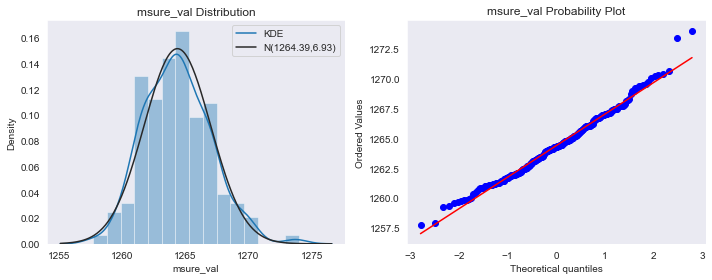

In [64]:
predict['msure_val'] = (en_pred+lgb_pred+xgb_pred+et_pred+gbr_pred)/5
QQ_plot(predict['msure_val'], 'msure_val')

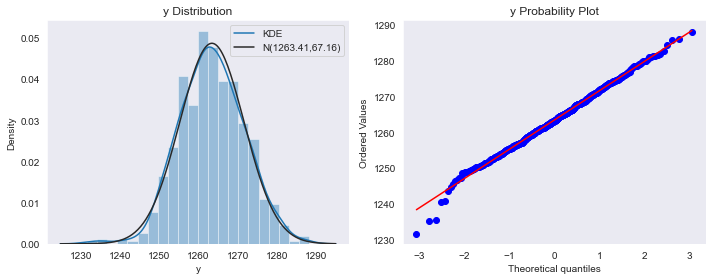

In [63]:
QQ_plot(df_final['y'], 'y')

In [65]:
df_submission = predict[['key_val', 'msure_val']] 
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_46.csv')

In [44]:
IMP_100COLS = pd.DataFrame({'params':COLS_ohe, 'importances':model_lgb.feature_importances_}).sort_values(by='importances', ascending=False)[:200].params.tolist()

#### Feature Selec 된 애들로 다시 돌려보기

In [34]:
# save
with open('model_lgb.p', 'wb') as f:
    pickle.dump(model_lgb, f)

# LSTM

In [157]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError,Huber
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [50]:
df_final_ohe[COLS_ohe].shape

(611, 439)

In [60]:
# [[[t1,ds1],[t2, ds2],[t3,ds3], [t4,ds4],[t5,ds5]]] [t6] 로 간다.
# [[[t2, ds2],[t3,ds3], [t4,ds4],[t5,ds5],[t6,ds6]]] [t7]

def df_to_X_y2(df, window_size=11):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [62]:
X, y = df_to_X_y2(df_final_ohe[['y']+COLS_ohe], window_size=11)

In [63]:
X.shape, y.shape

((600, 11, 440), (600,))

In [64]:
X_train, y_train = X[:480], y[:480]
X_val, y_val = X[480:560], y[480:560]
X_test, y_test = X[560:], y[560:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((480, 11, 440), (480,), (80, 11, 440), (80,), (40, 11, 440), (40,))

In [171]:
model1 = Sequential()
model1.add(InputLayer((11, 440)))
model1.add(LSTM(8, activation='tanh', kernel_initializer='uniform'))
# model1.add(Dropout(0.2))
model1.add(BatchNormalization())
model1.add(Dense(8, activation='tanh'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 8)                 14368     
_________________________________________________________________
batch_normalization_13 (Batc (None, 8)                 32        
_________________________________________________________________
dense_54 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 9         
Total params: 14,481
Trainable params: 14,465
Non-trainable params: 16
_________________________________________________________________


In [172]:
# cp = ModelCheckpoint('model/', save_best_only=True)
es = EarlyStopping(monitor='val_root_mean_squared_error',patience=15)
model1.compile(loss=MeanSquaredError(), optimizer='sgd', metrics=[RootMeanSquaredError()])

In [173]:
# X_train, X_test, y_train, y_test = train_test_split(df_final_ohe[COLS_ohe], df_final_ohe['y'], test_size=0.2, random_state=0, shuffle=True)

In [174]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, callbacks=[es])

Epoch 1/1000
15/15 [==============================] - 1s 33ms/step - loss: 851114.7793 - root_mean_squared_error: 899.1196 - val_loss: 6033.9287 - val_root_mean_squared_error: 77.6784
Epoch 2/1000
15/15 [==============================] - 0s 8ms/step - loss: 2702.8273 - root_mean_squared_error: 50.4090 - val_loss: 65.1080 - val_root_mean_squared_error: 8.0690
Epoch 3/1000
15/15 [==============================] - 0s 8ms/step - loss: 76.2857 - root_mean_squared_error: 8.7324 - val_loss: 54.6838 - val_root_mean_squared_error: 7.3949
Epoch 4/1000
15/15 [==============================] - 0s 8ms/step - loss: 64.1870 - root_mean_squared_error: 7.9906 - val_loss: 56.0072 - val_root_mean_squared_error: 7.4838
Epoch 5/1000
15/15 [==============================] - 0s 8ms/step - loss: 74.0169 - root_mean_squared_error: 8.5975 - val_loss: 54.6587 - val_root_mean_squared_error: 7.3932
Epoch 6/1000
15/15 [==============================] - 0s 8ms/step - loss: 65.1437 - root_mean_squared_error: 8.0673 -

# CNN + LSTM

In [175]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [197]:
train_feature, train_label = make_dataset(df_final_ohe[COLS_ohe], df_final_ohe['y'], 3)

In [198]:
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
x_train.shape, x_valid.shape

((486, 3, 439), (122, 3, 439))

In [206]:
model = Sequential()
model.add(Conv1D(filters=20, kernel_size=20,
           padding="causal",
           activation="tanh",
           input_shape=[3, 439]))
# model.add(BatchNormalization())
model.add(LSTM(8, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='tanh', 
               return_sequences=False, kernel_initializer='uniform')
          )

model.add(Dense(1, 'linear'))

model.compile(loss=MeanSquaredError(), optimizer='sgd', metrics=[RootMeanSquaredError()])
early_stop = EarlyStopping(monitor='val_root_mean_squared_error', patience=15)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_root_mean_squared_error', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                                    epochs=200, 
                                    batch_size=128,
                                    validation_data=(x_valid, y_valid), 
                                    callbacks=[early_stop, checkpoint])

Epoch 1/200
4/4 [==============================] - 3s 176ms/step - loss: 1472111.6000 - root_mean_squared_error: 1212.6956 - val_loss: 774226.1250 - val_root_mean_squared_error: 879.9012

Epoch 00001: val_root_mean_squared_error improved from inf to 879.90118, saving model to model\tmp_checkpoint.h5
Epoch 2/200
4/4 [==============================] - 0s 19ms/step - loss: 639470.4250 - root_mean_squared_error: 798.0828 - val_loss: 280987.0938 - val_root_mean_squared_error: 530.0822

Epoch 00002: val_root_mean_squared_error improved from 879.90118 to 530.08215, saving model to model\tmp_checkpoint.h5
Epoch 3/200
4/4 [==============================] - 0s 19ms/step - loss: 232466.2938 - root_mean_squared_error: 481.1743 - val_loss: 102043.1016 - val_root_mean_squared_error: 319.4419

Epoch 00003: val_root_mean_squared_error improved from 530.08215 to 319.44186, saving model to model\tmp_checkpoint.h5
Epoch 4/200
4/4 [==============================] - 0s 20ms/step - loss: 84265.9109 - root_m

4/4 [==============================] - 0s 20ms/step - loss: 73.8681 - root_mean_squared_error: 8.5911 - val_loss: 53.5684 - val_root_mean_squared_error: 7.3190

Epoch 00030: val_root_mean_squared_error did not improve from 7.31891
Epoch 31/200
4/4 [==============================] - 0s 20ms/step - loss: 69.7770 - root_mean_squared_error: 8.3529 - val_loss: 53.5694 - val_root_mean_squared_error: 7.3191

Epoch 00031: val_root_mean_squared_error did not improve from 7.31891
Epoch 32/200
4/4 [==============================] - 0s 21ms/step - loss: 70.7317 - root_mean_squared_error: 8.4076 - val_loss: 53.5670 - val_root_mean_squared_error: 7.3189

Epoch 00032: val_root_mean_squared_error did not improve from 7.31891
Epoch 33/200
4/4 [==============================] - 0s 20ms/step - loss: 73.0530 - root_mean_squared_error: 8.5459 - val_loss: 53.5668 - val_root_mean_squared_error: 7.3189

Epoch 00033: val_root_mean_squared_error did not improve from 7.31891
Epoch 34/200
4/4 [===================

# CATBOOST

In [42]:
cat_feautures = [0,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361]
def objective_CAT(trial):
    param_cat = {
          "random_state":42,
          'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.7),
          'bagging_temperature' :trial.suggest_float('bagging_temperature', 1e-4, 100.0),
          "n_estimators":trial.suggest_int("n_estimators", 100, 500),
          "max_depth":trial.suggest_int("max_depth", 4, 16),  # max depth 는 16이 끝.
          'random_strength' :trial.suggest_float('random_strength', 1e-4, 100.0),
          "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.3, 1.0),
          "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",0,10),
          "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
          "max_bin": trial.suggest_int("max_bin", 200, 500),
          'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
#           'iterations':trial.suggest_int("iterations", 50, 200),
#           'task_type':'GPU',
#           'devices':'0'
# #           'rsm':1
    }
    X = df_final[COLS]
    y = df_final['y']
    
    model = CatBoostRegressor(**param_cat,loss_function='RMSE', eval_metric='RMSE', silent=True, cat_features = cat_feautures)
    cv = KFold(5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
    scores = np.sqrt(-scores)
    print(f'CV scores : {scores}')
    print('Mean score : ', np.mean(scores))
    rmse_val = np.mean(scores)

    return rmse_val
    
sampler = TPESampler(seed=42)
study_cat = optuna.create_study(
            study_name="cat_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )
study_cat.optimize(objective_CAT, n_trials=7)
print("Best Score:", study_cat.best_value)
print("Best trial:", study_cat.best_trial.params)
    
model_cat = CatBoostRegressor(**study_cat.best_params,
                            loss_function='RMSE', eval_metric='RMSE',
                            random_state=42, silent=True, cat_features = cat_feautures)
model_cat.fit(df_final[COLS], df_final['y'])
print('model training is completed')

[I 2022-07-26 22:09:24,965] A new study created in memory with name: cat_parameter_opt

KeyboardInterrupt



# XGB
- dart

In [30]:
def objective_XGB(trial):
    param_xgb = {
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
            'n_estimators': trial.suggest_int('n_estimators', 100, 5000),
            # maximum depth of the tree, signifies complexity of the tree.
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            # minimum child weight, larger the term more conservative the tree.
            "min_child_weight": trial.suggest_int("min_child_weight", 2, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01,0.8),
            # defines how selective algorithm is.
            "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
            "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
            'colsample_bytree': trial.suggest_int('colsample_bytree', 0.3, 1.0),
            "sample_type": trial.suggest_categorical("sample_type", ["uniform", "weighted"]),
            "normalize_type": trial.suggest_categorical("normalize_type", ["tree", "forest"]),
            "rate_drop": trial.suggest_float("rate_drop", 1e-8, 1.0, log=True),
            "skip_drop": trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    }
        
    X = df_final_ohe[COLS_ohe]
    y = df_final_ohe['y']

    model = xgb.XGBRegressor(**param_xgb, booster='dart', tree_method='gpu_hist', gpu_id='0', random_state=0)
    cv = KFold(5,shuffle=True, random_state=0)
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    scores = np.sqrt(-scores)
    print(f'CV scores : {scores}')
    print('Mean score : ', np.mean(scores))
    rmsle_val = np.mean(scores)
     
    return rmsle_val
    
sampler = TPESampler(seed=42)
study_xgb = optuna.create_study(
            study_name="xgb_parameter_opt",
            direction="minimize",
            sampler=sampler,
    )
study_xgb.optimize(objective_XGB, n_trials=20, timeout=600)
print("Best Score:", study_xgb.best_value)
print("Best trial:", study_xgb.best_trial.params)
    
model_xgb = xgb.XGBRegressor(**study_xgb.best_params, booster='dart', tree_method='gpu_hist', gpu_id='0', random_state=0)
model_xgb.fit(df_final_ohe[COLS_ohe], df_final_ohe['y'])
print('model training is completed')

[I 2022-07-26 19:44:51,225] A new study created in memory with name: xgb_parameter_opt
[I 2022-07-26 19:45:04,183] Trial 0 finished with value: 8.000726145845622 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 956, 'max_depth': 10, 'min_child_weight': 7, 'learning_rate': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 8.000726145845622.


CV scores : [7.74545632 8.70847505 8.7493086  7.5818554  7.21853536]
Mean score :  8.000726145845622


[I 2022-07-26 19:45:08,573] Trial 1 finished with value: 8.22503927844458 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 265, 'max_depth': 6, 'min_child_weight': 6, 'learning_rate': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 0 with value: 8.000726145845622.


CV scores : [8.44773669 8.89541744 8.89145125 7.31417834 7.57641267]
Mean score :  8.22503927844458


[I 2022-07-26 19:45:11,217] Trial 2 finished with value: 7.692040517046903 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 141, 'max_depth': 9, 'min_child_weight': 3, 'learning_rate': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 7.692040517046903.


CV scores : [7.53243039 8.34560539 8.38800922 7.17730059 7.016857  ]
Mean score :  7.692040517046903


[I 2022-07-26 19:45:26,827] Trial 3 finished with value: 7.932740467127198 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 919, 'max_depth': 5, 'min_child_weight': 7, 'learning_rate': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 7.692040517046903.


CV scores : [7.9538825  8.62849457 8.56138416 7.05287027 7.46707084]
Mean score :  7.932740467127198


[I 2022-07-26 19:45:29,738] Trial 4 finished with value: 7.880860745623987 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 276, 'max_depth': 3, 'min_child_weight': 4, 'learning_rate': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 7.692040517046903.


CV scores : [7.67279191 8.86088656 8.17697714 7.26675061 7.42689752]
Mean score :  7.880860745623987


[I 2022-07-26 19:45:32,834] Trial 5 finished with value: 8.236161812208419 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 279, 'max_depth': 3, 'min_child_weight': 9, 'learning_rate': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 2 with value: 7.692040517046903.


CV scores : [8.60355913 9.04590854 8.62345592 7.64160467 7.26628079]
Mean score :  8.236161812208419


[I 2022-07-26 19:45:42,795] Trial 6 finished with value: 9.240694601965451 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 392, 'max_depth': 10, 'min_child_weight': 7, 'learning_rate': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 2 with value: 7.692040517046903.


CV scores : [ 8.80937868 10.14506111  9.89472716  8.63339851  8.72090755]
Mean score :  9.240694601965451


[I 2022-07-26 19:45:44,869] Trial 7 finished with value: 7.833161037591476 and parameters: {'reg_lambda': 0.0022877311527772994, 'n_estimators': 197, 'max_depth': 3, 'min_child_weight': 7, 'learning_rate': 0.25834122505029805, 'gamma': 0.00011710232809812825, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.0797523481449624e-06, 'skip_drop': 1.9488135833929595e-07}. Best is trial 2 with value: 7.692040517046903.


CV scores : [7.56865998 8.65081102 8.27593662 7.23027057 7.440127  ]
Mean score :  7.833161037591476


[I 2022-07-26 19:46:05,126] Trial 8 finished with value: 8.888515593773077 and parameters: {'reg_lambda': 0.08367278941385504, 'n_estimators': 828, 'max_depth': 9, 'min_child_weight': 9, 'learning_rate': 0.6449009407503005, 'gamma': 3.108568709174384e-07, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 6.660108438734075e-07, 'skip_drop': 2.6113333123958975e-05}. Best is trial 2 with value: 7.692040517046903.


CV scores : [8.63526472 9.66527117 9.43389199 8.01554146 8.69260862]
Mean score :  8.888515593773077


[I 2022-07-26 19:46:16,245] Trial 9 finished with value: 7.950652357591538 and parameters: {'reg_lambda': 0.07362133075287672, 'n_estimators': 875, 'max_depth': 3, 'min_child_weight': 6, 'learning_rate': 0.3397546924875354, 'gamma': 5.982221423148757e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 8.110298132030929e-06, 'skip_drop': 0.5946434805027183}. Best is trial 2 with value: 7.692040517046903.


CV scores : [7.91153473 8.66199084 8.3128074  7.34383855 7.52309027]
Mean score :  7.950652357591538


[I 2022-07-26 19:46:37,684] Trial 10 finished with value: 7.804531450878974 and parameters: {'reg_lambda': 0.051859013229364696, 'n_estimators': 603, 'max_depth': 12, 'min_child_weight': 2, 'learning_rate': 0.021487291378267867, 'gamma': 0.18252332105365732, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.2545539914747897e-08, 'skip_drop': 0.0026670453351722847}. Best is trial 2 with value: 7.692040517046903.


CV scores : [7.7656154  8.31910422 8.74014816 7.26859421 6.92919526]
Mean score :  7.804531450878974


[I 2022-07-26 19:46:58,879] Trial 11 finished with value: 7.793440064467457 and parameters: {'reg_lambda': 0.05285695893678235, 'n_estimators': 616, 'max_depth': 12, 'min_child_weight': 2, 'learning_rate': 0.018690957020522207, 'gamma': 0.8450252244458468, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.052641428974151e-08, 'skip_drop': 0.0032831657530829296}. Best is trial 2 with value: 7.692040517046903.


CV scores : [7.77657212 8.26553887 8.76221775 7.23138847 6.93148311]
Mean score :  7.793440064467457


[I 2022-07-26 19:47:15,850] Trial 12 finished with value: 7.786066106351873 and parameters: {'reg_lambda': 0.05278800123257817, 'n_estimators': 604, 'max_depth': 12, 'min_child_weight': 2, 'learning_rate': 0.012505072509820393, 'gamma': 0.9292493243152622, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.0549329149440461e-08, 'skip_drop': 0.0026987612161461175}. Best is trial 2 with value: 7.692040517046903.


CV scores : [7.57042428 8.54813212 8.62406687 7.35590076 6.83180651]
Mean score :  7.786066106351873


[I 2022-07-26 19:47:21,165] Trial 13 finished with value: 7.87100644490849 and parameters: {'reg_lambda': 0.06082903192400874, 'n_estimators': 461, 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.13485370296121332, 'gamma': 0.029142598670865546, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.06651927757295317, 'skip_drop': 0.003252463008072996}. Best is trial 2 with value: 7.692040517046903.


CV scores : [7.58164867 8.62783317 8.63315389 7.41052787 7.10186863]
Mean score :  7.87100644490849


KeyboardInterrupt: 

# XGB
- gbtree

In [ ]:
def objective_XGB(trial):
    param_xgb = {
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
            'n_estimators': trial.suggest_int('n_estimators', 100, 5000),
            # maximum depth of the tree, signifies complexity of the tree.
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            # minimum child weight, larger the term more conservative the tree.
            "min_child_weight": trial.suggest_int("min_child_weight", 2, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01,0.8),
            # defines how selective algorithm is.
            "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
            "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    }
        
    X = df_final_ohe[COLS_ohe]
    y = df_final_ohe['y']

    model = xgb.XGBRegressor(**param_xgb, booster='gbtree', tree_method='gpu_hist', gpu_id='0', random_state=0)
    cv = KFold(7,shuffle=True, random_state=0)
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    scores = np.sqrt(-scores)
    print(f'CV scores : {scores}')
    print('Mean score : ', np.mean(scores))
    rmse_val = np.mean(scores)
     
    return rmse_val
    
sampler = TPESampler(seed=42)
study_xgb = optuna.create_study(
            study_name="xgb_parameter_opt",
            direction="minimize",
            sampler=sampler,
    )
study_xgb.optimize(objective_XGB, n_trials=30, timeout=600)
print("Best Score:", study_xgb.best_value)
print("Best trial:", study_xgb.best_trial.params)
    
model_xgb = xgb.XGBRegressor(**study_xgb.best_params, booster='gbtree', tree_method='gpu_hist', gpu_id='0', random_state=0)
model_xgb.fit(df_final_ohe[COLS_ohe], df_final_ohe['y'])
print('model training is completed')

[I 2022-07-28 22:08:18,187] A new study created in memory with name: xgb_parameter_opt


In [37]:
# save
with open('model_xgb.p', 'wb') as f:
    pickle.dump(model_xgb, f)

In [45]:
def QQ_plot(data, measure):
    
    # 그래프의 크기를 지정합니다.
    fig = plt.figure(figsize=(10,4))
    
    # 1행 2열의 첫번째 히스토그램 그래프입니다.
    fig1 = fig.add_subplot(121)
    (mu, sigma) = norm.fit(data)
    # distplot 으로 타깃 변수의 분포를 확인합니다. kde = True를 입력하면 커널밀도추정 결과를 함께 표기할 수 있습니다.
    sns.distplot(data, kde=True, fit=norm)
    fig1.legend(['KDE', f'N({round(mu, 2)},{round(sigma**2, 2)})'], loc='upper right')
    fig1.set_title(f'{measure} Distribution', loc='center')
    fig1.set_xlabel(f'{measure}')

    # 1행 2열의 두번째 QQ Plot 그래프입니다.
    fig2 = fig.add_subplot(122)
    # 정규분포와 타깃변수의 분포를 비교합니다.
    res = probplot(data, plot=fig2)
    fig2.set_title(f'{measure} Probability Plot', loc='center')

    plt.tight_layout()
    plt.show()

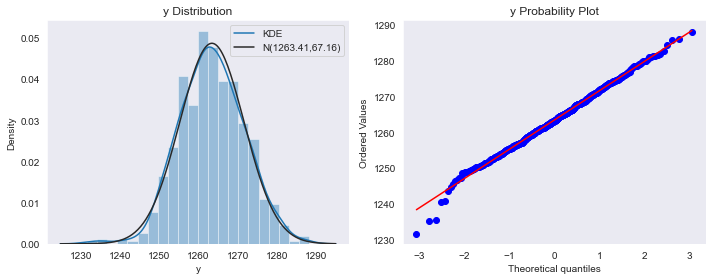

In [46]:
QQ_plot(df_final['y'], 'y')

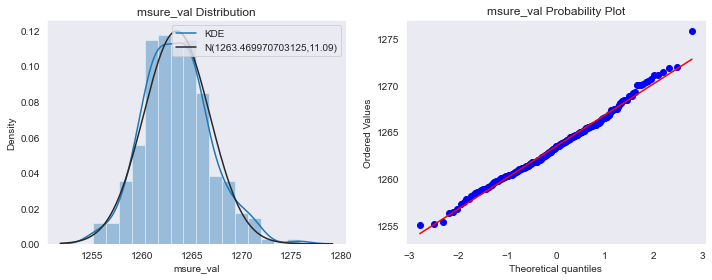

In [48]:
predict['msure_val'] = model_xgb.predict(df_predict_final_ohe[COLS_ohe])
QQ_plot(predict['msure_val'], 'msure_val')

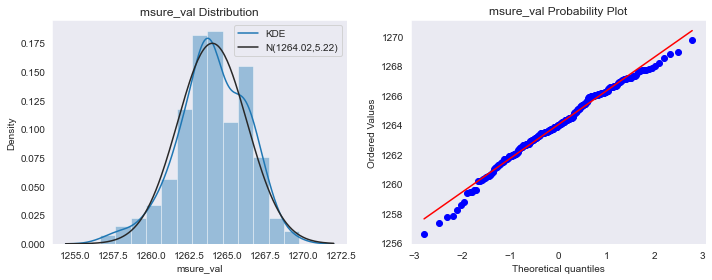

In [47]:
predict['msure_val'] = model_et.predict(df_predict_final_ohe[COLS_ohe])
QQ_plot(predict['msure_val'], 'msure_val')

#### 분산이 씹창이야

# EN

In [49]:
from sklearn.linear_model import ElasticNet
# from sklearn.preprocessing import StandardScaler  정규화 하지마.

In [109]:
# df_final_ohe.loc[:,df_final_ohe.dtypes==float]

,y,04_esc_para84,04_esc_para94,04_fr_para28,04_fr_para35,04_fr_para61,04_fr_para69,04_gas_para21,04_gas_para36,04_gas_para51,04_gas_para6,04_he_para22,04_he_para88,04_hv_para3,04_hv_para45,04_hv_para47,04_hv_para56,04_position_para72,04_power_para57,04_power_para76,04_pressure_para91,04_temp_para12,04_temp_para18,04_temp_para20,04_temp_para38,04_temp_para54,04_temp_para58,04_temp_para60,04_temp_para65,04_temp_para66,04_temp_para86,04_time_para16,04_time_para29,04_time_para30,04_time_para34,04_time_para37,04_time_para41,04_time_para42,04_time_para43,04_time_para44,04_time_para62,04_time_para64,04_time_para67,04_time_para7,04_time_para75,04_time_para77,04_time_para8,04_time_para81,04_time_para83,04_time_para89,04_time_para9,04_time_para90,04_tmp_para31,06_epd_para4,06_epd_para40,06_epd_para63,06_esc_para84,06_esc_para94,06_fr_para28,06_fr_para35,06_fr_para61,06_fr_para69,06_gas_para21,06_gas_para36,06_gas_para6,06_he_para22,06_he_para88,06_position_para72,06_power_para49,06_power_para57,06_power_para76,06_pressure_para91,06_temp_para12,06_temp_para18,06_temp_para20,06_temp_para38,06_temp_para54,06_temp_para58,06_temp_para60,06_temp_para65,06_temp_para66,06_temp_para86,06_time_para16,06_time_para29,06_time_para30,06_time_para34,06_time_para37,06_time_para41,06_time_para42,06_time_para43,06_time_para44,06_time_para62,06_time_para64,06_time_para67,06_time_para7,06_time_para75,06_time_para77,06_time_para8,06_time_para81,06_time_para83,06_time_para89,06_time_para9,06_time_para90,06_tmp_para31,12_esc_para84,12_esc_para94,12_fr_para28,12_fr_para35,12_fr_para61,12_fr_para69,12_gas_para21,12_gas_para36,12_gas_para6,12_he_para22,12_he_para88,12_hv_para3,12_hv_para45,12_hv_para47,12_hv_para56,12_position_para72,12_power_para14,12_power_para57,12_power_para76,12_power_para82,12_temp_para12,12_temp_para17,12_temp_para18,12_temp_para20,12_temp_para24,12_temp_para38,12_temp_para58,12_temp_para60,12_temp_para65,12_temp_para66,12_temp_para86,12_time_para16,12_time_para29,12_time_para30,12_time_para34,12_time_para37,12_time_para41,12_time_para42,12_time_para43,12_time_para44,12_time_para5,12_time_para62,12_time_para64,12_time_para67,12_time_para7,12_time_para75,12_time_para77,12_time_para8,12_time_para81,12_time_para83,12_time_para89,12_time_para9,12_time_para90,12_tmp_para31,13_esc_para84,13_esc_para94,13_fr_para28,13_fr_para35,13_fr_para61,13_fr_para69,13_gas_para21,13_gas_para36,13_gas_para46,13_gas_para6,13_he_para22,13_he_para88,13_hv_para45,13_hv_para47,13_hv_para56,13_position_para72,13_power_para14,13_power_para57,13_power_para76,13_power_para82,13_pressure_para91,13_temp_para12,13_temp_para17,13_temp_para18,13_temp_para20,13_temp_para24,13_temp_para38,13_temp_para58,13_temp_para60,13_temp_para65,13_temp_para66,13_temp_para86,13_tmp_para31,17_esc_para84,17_esc_para94,17_fr_para28,17_fr_para35,17_fr_para61,17_fr_para69,17_gas_para21,17_gas_para36,17_gas_para6,17_he_para22,17_he_para88,17_hv_para3,17_hv_para45,17_hv_para47,17_hv_para56,17_position_para72,17_power_para14,17_power_para57,17_power_para76,17_power_para82,17_temp_para12,17_temp_para17,17_temp_para18,17_temp_para20,17_temp_para24,17_temp_para38,17_temp_para58,17_temp_para60,17_temp_para65,17_temp_para66,17_temp_para86,17_time_para16,17_time_para29,17_time_para30,17_time_para34,17_time_para37,17_time_para41,17_time_para42,17_time_para43,17_time_para44,17_time_para62,17_time_para64,17_time_para67,17_time_para7,17_time_para75,17_time_para77,17_time_para8,17_time_para81,17_time_para83,17_time_para89,17_time_para9,17_time_para90,17_tmp_para31,18_esc_para84,18_esc_para94,18_fr_para28,18_fr_para35,18_fr_para61,18_fr_para69,18_gas_para21,18_gas_para36,18_gas_para46,18_gas_para6,18_he_para22,18_he_para88,18_hv_para3,18_hv_para45,18_hv_para47,18_hv_para56,18_position_para72,18_power_para14,18_power_para57,18_power_para68,18_power_para76,18_power_para82,18_pressure_para91,18_temp_para12,18_temp_para17,18_temp_para18,18_temp_para20,18_temp_para24,18_temp_para38,18_temp_para58,18_temp_para60,

In [110]:
# sin_col = df_final_ohe.filter(regex='sin').columns.tolist()
# cos_col = df_final_ohe.filter(regex='cos').columns.tolist()
# numf = df_final_ohe.loc[:,df_final_ohe.dtypes==float].columns.tolist()
# numf.remove('y')
# numf = [col for col in numf if col not in sin_col]
# numf = [col for col in numf if col not in cos_col]
# numf

# scaler = StandardScaler()
# df_final_ohe.loc[:,numf] = scaler.fit_transform(df_final_ohe[numf])
# df_predict_final_ohe.loc[:,numf] = scaler.transform(df_predict_final_ohe[numf])

['04_esc_para84',
 '04_esc_para94',
 '04_fr_para28',
 '04_fr_para35',
 '04_fr_para61',
 '04_fr_para69',
 '04_gas_para21',
 '04_gas_para36',
 '04_gas_para51',
 '04_gas_para6',
 '04_he_para22',
 '04_he_para88',
 '04_hv_para3',
 '04_hv_para45',
 '04_hv_para47',
 '04_hv_para56',
 '04_position_para72',
 '04_power_para57',
 '04_power_para76',
 '04_pressure_para91',
 '04_temp_para12',
 '04_temp_para18',
 '04_temp_para20',
 '04_temp_para38',
 '04_temp_para54',
 '04_temp_para58',
 '04_temp_para60',
 '04_temp_para65',
 '04_temp_para66',
 '04_temp_para86',
 '04_time_para16',
 '04_time_para29',
 '04_time_para30',
 '04_time_para34',
 '04_time_para37',
 '04_time_para41',
 '04_time_para42',
 '04_time_para43',
 '04_time_para44',
 '04_time_para62',
 '04_time_para64',
 '04_time_para67',
 '04_time_para7',
 '04_time_para75',
 '04_time_para77',
 '04_time_para8',
 '04_time_para81',
 '04_time_para83',
 '04_time_para89',
 '04_time_para9',
 '04_time_para90',
 '04_tmp_para31',
 '06_epd_para4',
 '06_epd_para40',

In [50]:
from sklearn.linear_model import ElasticNet

def objective_en(trial):
    param = {
            'alpha':trial.suggest_float("alpha",1e-6,1.0),
            'fit_intercept':trial.suggest_categorical('fit_intercept', [True, False]),
            'normalize':trial.suggest_categorical('normalize', [True, False]),
            'selection':trial.suggest_categorical('selection', ['cyclic','random']),
            'l1_ratio':trial.suggest_float("l1_ratio",1e-6,1.0)
    }
    X = df_final_ohe[COLS_ohe]
    y = df_final_ohe['y']

    model = ElasticNet(**param, random_state=42)
    cv = KFold(11, shuffle=True, random_state=0)
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    scores = np.sqrt(-scores)
    print(f'CV scores : {scores}')
    print('Mean score : ', np.mean(scores))
    rmsle_val = np.mean(scores)

    return rmsle_val
    
sampler = TPESampler(seed=42)
study_en = optuna.create_study(
            study_name="en_parameter_opt",
            direction="minimize",
            sampler=sampler,
)
study_en.optimize(objective_en, n_trials=30)
print("Best Score:", study_en.best_value)
print("Best trial:", study_en.best_trial.params)
    
model_en = ElasticNet(**study_en.best_params, random_state=42)
model_en.fit(df_final_ohe[COLS_ohe], df_final_ohe['y'])
print('model training is completed')

[I 2022-07-30 00:17:18,037] A new study created in memory with name: en_parameter_opt
[I 2022-07-30 00:17:18,180] Trial 0 finished with value: 8.170578572671632 and parameters: {'alpha': 0.3745407443072436, 'fit_intercept': True, 'normalize': True, 'selection': 'cyclic', 'l1_ratio': 0.8661762795987894}. Best is trial 0 with value: 8.170578572671632.
[I 2022-07-30 00:17:18,315] Trial 1 finished with value: 8.170578572671632 and parameters: {'alpha': 0.6011154106281971, 'fit_intercept': True, 'normalize': True, 'selection': 'cyclic', 'l1_ratio': 0.18340532644892396}. Best is trial 0 with value: 8.170578572671632.


CV scores : [6.58314676 8.89682129 8.08485675 9.83722359 9.28967564 8.45285181
 7.85283592 8.77135935 7.24121711 7.11091481 7.75546125]
Mean score :  8.170578572671632
CV scores : [6.58314676 8.89682129 8.08485675 9.83722359 9.28967564 8.45285181
 7.85283592 8.77135935 7.24121711 7.11091481 7.75546125]
Mean score :  8.170578572671632


[I 2022-07-30 00:17:19,296] Trial 2 finished with value: 7.516906242715013 and parameters: {'alpha': 0.30424293871729474, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.36636247693184837}. Best is trial 2 with value: 7.516906242715013.


CV scores : [5.76466475 7.88791277 7.1395     8.80357557 8.49128112 7.23690289
 7.24632485 8.66755744 7.04326706 7.1205625  7.28441971]
Mean score :  7.516906242715013


[I 2022-07-30 00:17:20,312] Trial 3 finished with value: 7.528983773371279 and parameters: {'alpha': 0.4560705281470517, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.17052495316316785}. Best is trial 2 with value: 7.516906242715013.


CV scores : [5.80897597 7.88833455 7.14660394 8.82446677 8.48828325 7.22424752
 7.28025571 8.67446534 7.05335622 7.11265931 7.31717293]
Mean score :  7.528983773371279


[I 2022-07-30 00:17:21,613] Trial 4 finished with value: 8.850017406817805 and parameters: {'alpha': 0.06505252793368653, 'fit_intercept': False, 'normalize': True, 'selection': 'random', 'l1_ratio': 0.44015305358710755}. Best is trial 2 with value: 7.516906242715013.
[I 2022-07-30 00:17:21,752] Trial 5 finished with value: 8.169671989050816 and parameters: {'alpha': 0.12203911280654398, 'fit_intercept': True, 'normalize': True, 'selection': 'cyclic', 'l1_ratio': 0.5200685011097896}. Best is trial 2 with value: 7.516906242715013.


CV scores : [ 7.89451163  8.87447666  8.59876647 10.15375795  9.38744393  8.76469162
  9.86540807 10.11180962  8.23016433  7.55311683  7.91604438]
Mean score :  8.850017406817805
CV scores : [6.5816392  8.89651071 8.08324692 9.83646023 9.28932536 8.45181051
 7.85193824 8.77045435 7.23987139 7.1096734  7.75546157]
Mean score :  8.169671989050816


[I 2022-07-30 00:17:22,750] Trial 6 finished with value: 9.82731956120327 and parameters: {'alpha': 0.5467107326330003, 'fit_intercept': False, 'normalize': False, 'selection': 'cyclic', 'l1_ratio': 0.9218743131488818}. Best is trial 2 with value: 7.516906242715013.


CV scores : [ 8.18584566  9.35126657  9.8341593  11.10358506 11.51663532  9.68485305
 12.30548972 10.69684424  8.6964692   8.72149595  8.00387111]
Mean score :  9.82731956120327


[I 2022-07-30 00:17:23,807] Trial 7 finished with value: 7.356844418958732 and parameters: {'alpha': 0.08849341355941745, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.35675396994026254}. Best is trial 7 with value: 7.356844418958732.
[I 2022-07-30 00:17:23,950] Trial 8 finished with value: 8.169441062869202 and parameters: {'alpha': 0.280935228752871, 'fit_intercept': True, 'normalize': True, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 7 with value: 7.356844418958732.


CV scores : [5.30308826 7.81467318 6.96694561 8.59766675 8.31172085 6.81192946
 6.93155403 8.56455524 6.94467606 7.52840985 7.15006932]
Mean score :  7.356844418958732
CV scores : [6.58057956 8.89599078 8.08393764 9.83655722 9.28921449 8.45116691
 7.85180722 8.77005242 7.24112908 7.10893716 7.75447921]
Mean score :  8.169441062869202


[I 2022-07-30 00:17:25,285] Trial 9 finished with value: 7.039588899287483 and parameters: {'alpha': 0.0055231116014852755, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.11586994365607019}. Best is trial 9 with value: 7.039588899287483.


CV scores : [4.90399154 7.20879809 6.75853132 8.07324869 7.97240728 6.58705246
 6.77393823 7.7818582  6.93464545 7.65620321 6.78480342]
Mean score :  7.039588899287483


[I 2022-07-30 00:17:26,612] Trial 10 finished with value: 8.439002884888703 and parameters: {'alpha': 0.8785835627104706, 'fit_intercept': False, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.014812544323917126}. Best is trial 9 with value: 7.039588899287483.


CV scores : [7.53961285 8.41315402 8.40455255 9.72481354 9.14907566 8.47000425
 8.86137204 9.5810132  7.83201529 7.11857913 7.73483921]
Mean score :  8.439002884888703


[I 2022-07-30 00:17:27,628] Trial 11 finished with value: 7.21049800841366 and parameters: {'alpha': 0.03872616123598299, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.6437130929110869}. Best is trial 9 with value: 7.039588899287483.


CV scores : [4.99996279 7.64849317 6.80382262 8.46237678 8.15456444 6.58686952
 6.780881   8.38963618 6.83289072 7.69324798 6.96273289]
Mean score :  7.21049800841366


[I 2022-07-30 00:17:28,731] Trial 12 finished with value: 7.088507014945802 and parameters: {'alpha': 0.015733599578572274, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.6679080731739894}. Best is trial 9 with value: 7.039588899287483.


CV scores : [4.90017406 7.40224726 6.70455397 8.28205147 8.03163104 6.53234988
 6.65330945 8.05070728 6.90772856 7.69614742 6.81267677]
Mean score :  7.088507014945802


[I 2022-07-30 00:17:29,671] Trial 13 finished with value: 7.49409507781686 and parameters: {'alpha': 0.19953112409506887, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.704538624045891}. Best is trial 9 with value: 7.039588899287483.


CV scores : [5.68804235 7.86332162 7.13190817 8.77578533 8.48291363 7.22804743
 7.19284899 8.66041587 7.04548802 7.12125056 7.24502389]
Mean score :  7.49409507781686


[I 2022-07-30 00:17:30,558] Trial 14 finished with value: 7.723690648806297 and parameters: {'alpha': 0.7914695407806198, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.740393137970675}. Best is trial 9 with value: 7.039588899287483.


CV scores : [6.06981317 7.8894057  7.47856761 9.16007466 8.93965902 7.68260014
 7.3925186  8.49491343 7.15850376 7.08215259 7.61238846]
Mean score :  7.723690648806297


[I 2022-07-30 00:17:31,950] Trial 15 finished with value: 8.659715561560004 and parameters: {'alpha': 0.22480808110003028, 'fit_intercept': False, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.0030233393995172386}. Best is trial 9 with value: 7.039588899287483.


CV scores : [7.76870505 8.71907549 8.49670748 9.86964793 9.2115854  8.53412847
 9.34135825 9.97626237 8.09276052 7.41072914 7.83591107]
Mean score :  8.659715561560004


[I 2022-07-30 00:17:33,231] Trial 16 finished with value: 7.107602178995128 and parameters: {'alpha': 0.003441021787297117, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.583717507403984}. Best is trial 9 with value: 7.039588899287483.


CV scores : [5.16201645 7.00183103 6.80801199 8.03730186 8.08031864 6.67729639
 7.31831094 7.56762904 6.91329987 7.7292515  6.88835625]
Mean score :  7.107602178995128


[I 2022-07-30 00:17:34,104] Trial 17 finished with value: 7.707939068431513 and parameters: {'alpha': 0.6855049226243262, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.808066762710252}. Best is trial 9 with value: 7.039588899287483.


CV scores : [6.04979944 7.89417825 7.43762948 9.12305885 8.9046295  7.66155096
 7.40392099 8.51500314 7.14568547 7.06325667 7.58861699]
Mean score :  7.707939068431513


[I 2022-07-30 00:17:35,231] Trial 18 finished with value: 8.435342940319197 and parameters: {'alpha': 0.9923396266460813, 'fit_intercept': False, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.3208508577696384}. Best is trial 9 with value: 7.039588899287483.


CV scores : [7.57873849 8.25167487 8.50783504 9.74814422 9.35579583 8.63659589
 8.61441558 9.40718567 7.8172621  7.12847206 7.74265262]
Mean score :  8.435342940319197


[I 2022-07-30 00:17:36,206] Trial 19 finished with value: 7.474663276259161 and parameters: {'alpha': 0.15742037561148814, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.5227486560827942}. Best is trial 9 with value: 7.039588899287483.


CV scores : [5.6086265  7.86147663 7.11165037 8.73084418 8.45842437 7.0879478
 7.12585041 8.65511882 7.01765569 7.31549755 7.24820371]
Mean score :  7.474663276259161


[I 2022-07-30 00:17:37,312] Trial 20 finished with value: 7.498784935954206 and parameters: {'alpha': 0.41464148176006566, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.09944541698378792}. Best is trial 9 with value: 7.039588899287483.


CV scores : [5.75294078 7.89293081 7.09422405 8.7802957  8.4448789  7.12601927
 7.22103598 8.66925852 7.05431013 7.15863131 7.29210884]
Mean score :  7.498784935954206


[I 2022-07-30 00:17:38,535] Trial 21 finished with value: 7.102719476719785 and parameters: {'alpha': 0.0037658873870860055, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.6169206600327767}. Best is trial 9 with value: 7.039588899287483.


CV scores : [5.14784824 7.01267649 6.79804015 8.04915279 8.07740086 6.67375018
 7.2787252  7.57675122 6.913372   7.71860062 6.88359648]
Mean score :  7.102719476719785


[I 2022-07-30 00:17:39,878] Trial 22 finished with value: 7.462158529962096 and parameters: {'alpha': 0.0008814782897094177, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.6539954614453465}. Best is trial 9 with value: 7.039588899287483.


CV scores : [5.84498822 6.85278654 7.17163696 8.00116653 8.43596287 6.7933807
 8.86961301 7.47686448 6.92933626 8.46424    7.24376826]
Mean score :  7.462158529962096


[I 2022-07-30 00:17:40,874] Trial 23 finished with value: 7.452651004337412 and parameters: {'alpha': 0.13781266998398545, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.4467754421542587}. Best is trial 9 with value: 7.039588899287483.


CV scores : [5.55136708 7.85568373 7.07730987 8.69583031 8.41927667 7.01150792
 7.09019391 8.63721535 7.00876039 7.39236122 7.23965459]
Mean score :  7.452651004337412


[I 2022-07-30 00:17:41,783] Trial 24 finished with value: 7.553215506467333 and parameters: {'alpha': 0.25670768226248897, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.7878413682045593}. Best is trial 9 with value: 7.039588899287483.


CV scores : [5.8251662  7.92830292 7.16658636 8.84373949 8.53643779 7.36129717
 7.3098911  8.68960129 7.06821917 7.03648641 7.31964268]
Mean score :  7.553215506467333


[I 2022-07-30 00:17:42,711] Trial 25 finished with value: 7.58212042986369 and parameters: {'alpha': 0.3567046130041014, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.5977149248942346}. Best is trial 9 with value: 7.039588899287483.


CV scores : [5.87853506 7.92395637 7.19437554 8.8954374  8.57032323 7.41080172
 7.37296418 8.68016052 7.08786907 7.02671171 7.36218993]
Mean score :  7.58212042986369


[I 2022-07-30 00:17:43,838] Trial 26 finished with value: 11.519352064533518 and parameters: {'alpha': 0.09369556618907703, 'fit_intercept': False, 'normalize': True, 'selection': 'cyclic', 'l1_ratio': 0.9912772048664038}. Best is trial 9 with value: 7.039588899287483.


CV scores : [10.03895843 10.38529323 12.0003272  11.81038035 12.50046303  9.56004117
 17.22017125 11.30778154 11.51572001 10.33972729 10.03400922]
Mean score :  11.519352064533518


[I 2022-07-30 00:17:44,861] Trial 27 finished with value: 7.45201468285694 and parameters: {'alpha': 0.1702815164656001, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.2843609024920366}. Best is trial 9 with value: 7.039588899287483.


CV scores : [5.57724839 7.87582692 7.05579384 8.69167438 8.40162292 6.99848142
 7.09254145 8.64350846 7.0223352  7.36310883 7.25001971]
Mean score :  7.45201468285694


[I 2022-07-30 00:17:45,961] Trial 28 finished with value: 7.248897767121658 and parameters: {'alpha': 0.04766406200983754, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.4244295847674091}. Best is trial 9 with value: 7.039588899287483.
[I 2022-07-30 00:17:46,104] Trial 29 finished with value: 8.170578572671632 and parameters: {'alpha': 0.31874327725356066, 'fit_intercept': True, 'normalize': True, 'selection': 'cyclic', 'l1_ratio': 0.8690195218444108}. Best is trial 9 with value: 7.039588899287483.


CV scores : [5.05626619 7.7101953  6.86752417 8.48664429 8.21595215 6.63683873
 6.78677657 8.44084816 6.8525799  7.65700967 7.02724031]
Mean score :  7.248897767121658
CV scores : [6.58314676 8.89682129 8.08485675 9.83722359 9.28967564 8.45285181
 7.85283592 8.77135935 7.24121711 7.11091481 7.75546125]
Mean score :  8.170578572671632
Best Score: 7.039588899287483
Best trial: {'alpha': 0.0055231116014852755, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.11586994365607019}
model training is completed


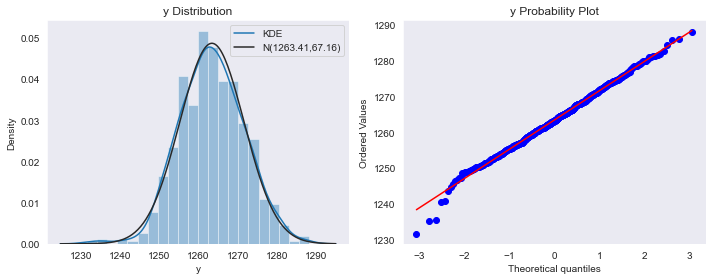

In [53]:
QQ_plot(df_final['y'], 'y')

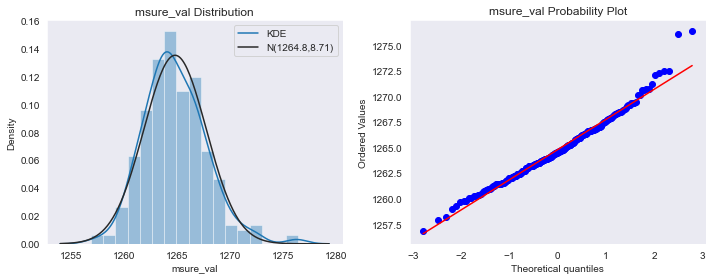

In [54]:
predict['msure_val'] = (model_en.predict(df_predict_final_ohe[COLS_ohe])+model_xgb.predict(df_predict_final_ohe[COLS_ohe])+model_et.predict(df_predict_final_ohe[COLS_ohe]))/3
QQ_plot(predict['msure_val'], 'msure_val')

In [56]:
model_en.predict(df_predict_final_ohe[COLS_ohe])

array([1260.63391136, 1256.64788319, 1259.00277786, 1259.6425014 ,
       1265.41918803, 1260.91828786, 1263.66684659, 1262.37682213,
       1261.20997505, 1257.41757036, 1258.51556781, 1262.70884855,
       1264.72670836, 1257.38989341, 1252.41484124, 1256.25811141,
       1252.86143329, 1249.24920445, 1254.55681561, 1264.66510931,
       1264.43388567, 1254.96479004, 1253.62285451, 1253.88238902,
       1254.86576659, 1253.02812957, 1259.54864546, 1258.35505929,
       1266.15192657, 1265.84596798, 1261.88334659, 1264.14107817,
       1257.58558266, 1261.68933345, 1263.99862092, 1265.49970708,
       1265.29226262, 1264.87012715, 1272.72718088, 1273.39189915,
       1259.73449643, 1264.23421259, 1266.83819119, 1265.28595396,
       1255.40887721, 1259.06273029, 1260.2255689 , 1260.20268459,
       1262.48116429, 1264.73400314, 1266.89338166, 1258.31201208,
       1257.76958746, 1249.80639419, 1257.54075879, 1269.61836787,
       1267.58252972, 1269.72068023, 1265.21292186, 1262.32900

# BR

In [58]:
from sklearn.linear_model import BayesianRidge

In [61]:
def objective_BR(trial):
    param_br = {
            'n_iter':trial.suggest_int("n_iter",500,2000),
            'alpha_2':trial.suggest_float("alpha_2",1e-6, 1.0),
            'lambda_2' :trial.suggest_float('lambda_2', 1e-6, 1.0),
            'fit_intercept':trial.suggest_categorical('fit_intercept', [True, False]),
            'normalize':trial.suggest_categorical('normalize', [True, False]),
            'tol':trial.suggest_float("tol",1e-6,1e-2)
    }
    
    X = df_final_ohe[COLS_ohe]
    y = df_final_ohe['y']

    model = BayesianRidge(**param_br)
    cv = KFold(11, shuffle=True, random_state=42)

    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
    scores = np.sqrt(-scores)
    print(f'CV scores : {scores}')
    print('Mean score : ', np.mean(scores))
    rmsle_val = np.mean(scores)

    return rmsle_val
    
sampler = TPESampler(seed=42)
study_br = optuna.create_study(
            study_name="BayesianRidge_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )

study_br.optimize(objective_BR, n_trials=30)
print("Best Score:", study_br.best_value)
print("Best trial:", study_br.best_trial.params)
    
model_br = BayesianRidge(**study_br.best_params)
model_br.fit(df_final_ohe[COLS_ohe], df_final_ohe['y'])
print('model training is completed')

[I 2022-07-26 22:49:25,446] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-26 22:49:27,447] Trial 0 finished with value: 14.727712145263075 and parameters: {'n_iter': 437, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 14.727712145263075.


CV scores : [ 7.94113127  9.24035092  7.42626239  8.517093    8.66715431  7.57660971
  7.64963633  7.40225655  8.73094531 81.36339985  7.48999394]
Mean score :  14.727712145263075


[I 2022-07-26 22:49:29,713] Trial 1 finished with value: 13.821496761872858 and parameters: {'n_iter': 641, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 13.821496761872858.


CV scores : [ 7.94204544  9.24547547  7.44646269  8.52274418  8.34028322  7.60262052
  7.66921286  7.42678626  8.7789443  71.56887471  7.49301472]
Mean score :  13.821496761872858


[I 2022-07-26 22:49:31,286] Trial 2 finished with value: 7.388565965479264 and parameters: {'n_iter': 374, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 2 with value: 7.388565965479264.


CV scores : [8.13580384 8.41317484 6.15699393 7.68388348 6.90452193 6.32421404
 8.4212353  7.32050721 7.28874339 7.24783342 7.37731426]
Mean score :  7.388565965479264


[I 2022-07-26 22:49:32,887] Trial 3 finished with value: 7.4193202830618 and parameters: {'n_iter': 510, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 2 with value: 7.388565965479264.


CV scores : [8.09092036 8.4661553  6.15949543 7.70232631 6.98268604 6.37154433
 8.41692786 7.36951745 7.438159   7.2213688  7.39342225]
Mean score :  7.4193202830618


[I 2022-07-26 22:49:34,420] Trial 4 finished with value: 7.3539662002949235 and parameters: {'n_iter': 158, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 4 with value: 7.3539662002949235.


CV scores : [8.1580715  8.34805925 6.14420177 7.66625227 6.82508712 6.30538377
 8.39463971 7.22941396 7.14429974 7.30694417 7.37127493]
Mean score :  7.3539662002949235


[I 2022-07-26 22:49:36,693] Trial 5 finished with value: 13.852187502283213 and parameters: {'n_iter': 209, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 4 with value: 7.3539662002949235.


CV scores : [ 7.94200825  9.24536372  7.44579308  8.52252832  8.34981049  7.60165668
  7.66861578  7.42599491  8.77751652 71.90185458  7.49292019]
Mean score :  13.852187502283213


[I 2022-07-26 22:49:38,207] Trial 6 finished with value: 7.356541530667193 and parameters: {'n_iter': 592, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 4 with value: 7.3539662002949235.


CV scores : [8.15914061 8.35159977 6.14486956 7.6558419  6.84092202 6.28602355
 8.40122534 7.24693351 7.1558143  7.31898835 7.36059793]
Mean score :  7.356541530667193


[I 2022-07-26 22:49:39,870] Trial 7 finished with value: 7.4986962161104564 and parameters: {'n_iter': 179, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 4 with value: 7.3539662002949235.


CV scores : [8.03288918 8.60195578 6.17735048 7.76784868 7.13674455 6.5254224
 8.35914529 7.40106187 7.7827661  7.29154227 7.40893177]
Mean score :  7.4986962161104564


[I 2022-07-26 22:49:42,063] Trial 8 finished with value: 14.023256094455116 and parameters: {'n_iter': 353, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 4 with value: 7.3539662002949235.


CV scores : [ 7.941801    9.24462815  7.44178931  8.52131593  8.40464019  7.59595103
  7.66494676  7.4212161   8.76847484 73.75869644  7.49235729]
Mean score :  14.023256094455116


[I 2022-07-26 22:49:43,605] Trial 9 finished with value: 7.369607434768366 and parameters: {'n_iter': 104, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 4 with value: 7.3539662002949235.


CV scores : [8.15511342 8.37791986 6.15126508 7.66822124 6.86253065 6.30058729
 8.41249027 7.2789258  7.20524119 7.28655846 7.3668285 ]
Mean score :  7.369607434768366


[I 2022-07-26 22:49:45,121] Trial 10 finished with value: 7.353658030325703 and parameters: {'n_iter': 951, 'alpha_2': 0.11994465311915903, 'lambda_2': 19.390742246220213, 'fit_intercept': True, 'normalize': False, 'tol': 0.006902780488617885}. Best is trial 10 with value: 7.353658030325703.


CV scores : [8.15806119 8.3474086  6.1440177  7.6659083  6.82465398 6.30505173
 8.39431373 7.2286444  7.14324135 7.30775014 7.37118723]
Mean score :  7.353658030325703


[I 2022-07-26 22:49:46,632] Trial 11 finished with value: 7.353632151903114 and parameters: {'n_iter': 980, 'alpha_2': 0.8298543335060141, 'lambda_2': 19.404428972474502, 'fit_intercept': True, 'normalize': False, 'tol': 0.006971861827502606}. Best is trial 11 with value: 7.353632151903114.


CV scores : [8.15806015 8.34735548 6.14400235 7.66588039 6.82461817 6.30502386
 8.39428786 7.22857977 7.14315202 7.30781353 7.37118009]
Mean score :  7.353632151903114


[I 2022-07-26 22:49:48,126] Trial 12 finished with value: 7.361751621764369 and parameters: {'n_iter': 977, 'alpha_2': 0.6509985805674281, 'lambda_2': 16.039196319251943, 'fit_intercept': True, 'normalize': False, 'tol': 0.006985872934878635}. Best is trial 11 with value: 7.353632151903114.


CV scores : [8.15680742 8.36385786 6.14861612 7.67454959 6.83714838 6.31374703
 8.40193558 7.24860385 7.17249691 7.28782366 7.37368145]
Mean score :  7.361751621764369


[I 2022-07-26 22:49:49,689] Trial 13 finished with value: 7.382942798480323 and parameters: {'n_iter': 969, 'alpha_2': 0.13132368470390454, 'lambda_2': 9.423016930278663, 'fit_intercept': True, 'normalize': False, 'tol': 0.006768503762898054}. Best is trial 11 with value: 7.353632151903114.


CV scores : [8.13949411 8.40379533 6.15788875 7.69487803 6.88084053 6.33779654
 8.4148699  7.29704357 7.26105074 7.24248171 7.38223155]
Mean score :  7.382942798480323


[I 2022-07-26 22:49:51,174] Trial 14 finished with value: 7.359501517863754 and parameters: {'n_iter': 795, 'alpha_2': 4.616970743100363, 'lambda_2': 16.93507430104776, 'fit_intercept': True, 'normalize': False, 'tol': 0.007399610900173708}. Best is trial 11 with value: 7.353632151903114.


CV scores : [8.15747271 8.35935243 6.14738457 7.67218899 6.83342638 6.31132727
 8.39994917 7.24311144 7.16408739 7.29327606 7.3729403 ]
Mean score :  7.359501517863754


[I 2022-07-26 22:49:52,733] Trial 15 finished with value: 7.37228472469672 and parameters: {'n_iter': 820, 'alpha_2': 6.817522901920603, 'lambda_2': 12.383357928913977, 'fit_intercept': True, 'normalize': False, 'tol': 0.006282652790464055}. Best is trial 11 with value: 7.353632151903114.


CV scores : [8.15053636 8.3842735  6.15378568 7.68513584 6.85706576 6.32530211
 8.40974746 7.27354055 7.21452533 7.26359979 7.3776196 ]
Mean score :  7.37228472469672


[I 2022-07-26 22:49:54,283] Trial 16 finished with value: 7.352546479513384 and parameters: {'n_iter': 824, 'alpha_2': 2.0771218635561906, 'lambda_2': 19.89420992293578, 'fit_intercept': True, 'normalize': False, 'tol': 0.0082087417512793}. Best is trial 16 with value: 7.352546479513384.


CV scores : [8.1579872  8.34510124 6.14335382 7.66469439 6.82313376 6.30385356
 8.39317232 7.22586306 7.1394368  7.31053217 7.37088295]
Mean score :  7.352546479513384


[I 2022-07-26 22:49:55,862] Trial 17 finished with value: 7.3979738769791945 and parameters: {'n_iter': 813, 'alpha_2': 6.779287467854153, 'lambda_2': 6.417004251546164, 'fit_intercept': True, 'normalize': False, 'tol': 0.009692729250635131}. Best is trial 16 with value: 7.352546479513384.


CV scores : [8.11858197 8.42975409 6.16188886 7.70681589 6.91822592 6.35757764
 8.41713429 7.32613652 7.33137945 7.22100674 7.38921127]
Mean score :  7.3979738769791945


[I 2022-07-26 22:49:57,422] Trial 18 finished with value: 7.3733996652474785 and parameters: {'n_iter': 711, 'alpha_2': 2.285449089156579, 'lambda_2': 12.030855296111215, 'fit_intercept': True, 'normalize': False, 'tol': 0.008379417154311132}. Best is trial 16 with value: 7.352546479513384.


CV scores : [8.1495861  8.38636514 6.15426943 7.6862016  6.85939882 6.32656243
 8.41041766 7.2760914  7.21921847 7.26120929 7.37807598]
Mean score :  7.3733996652474785


[I 2022-07-26 22:49:58,933] Trial 19 finished with value: 7.3583675088281515 and parameters: {'n_iter': 887, 'alpha_2': 6.272032864493445, 'lambda_2': 17.39998596957593, 'fit_intercept': True, 'normalize': False, 'tol': 0.0055358212149472195}. Best is trial 16 with value: 7.352546479513384.


CV scores : [8.1577157  8.3570631  6.14674958 7.67098535 6.8316211  6.31011086
 8.39890779 7.24032691 7.15992828 7.29605373 7.3725802 ]
Mean score :  7.3583675088281515


[I 2022-07-26 22:50:00,470] Trial 20 finished with value: 7.372190590785834 and parameters: {'n_iter': 716, 'alpha_2': 1.9389192017430539, 'lambda_2': 12.402978535542243, 'fit_intercept': True, 'normalize': False, 'tol': 0.007794652974513944}. Best is trial 16 with value: 7.352546479513384.


CV scores : [8.15061643 8.38409345 6.15374417 7.68504284 6.85687083 6.32519535
 8.40968749 7.27332456 7.21413128 7.26380964 7.37758047]
Mean score :  7.372190590785834


[I 2022-07-26 22:50:02,024] Trial 21 finished with value: 7.352344529008019 and parameters: {'n_iter': 911, 'alpha_2': 1.7015494848326687, 'lambda_2': 19.984031129410614, 'fit_intercept': True, 'normalize': False, 'tol': 0.006035707919999107}. Best is trial 21 with value: 7.352344529008019.


CV scores : [8.15796746 8.34467991 6.14323286 7.66447358 6.82286234 6.30363629
 8.3929628  7.22535659 7.13875092 7.31103829 7.37082877]
Mean score :  7.352344529008019


[I 2022-07-26 22:50:03,570] Trial 22 finished with value: 7.356539220011169 and parameters: {'n_iter': 887, 'alpha_2': 2.7559120242562365, 'lambda_2': 18.15117786087796, 'fit_intercept': True, 'normalize': False, 'tol': 0.005915585192286259}. Best is trial 21 with value: 7.352344529008019.


CV scores : [8.1579771  8.35333908 6.14570603 7.66902871 6.82881459 6.30814834
 8.39717323 7.23581141 7.15334259 7.30057075 7.37201959]
Mean score :  7.356539220011169


[I 2022-07-26 22:50:05,093] Trial 23 finished with value: 7.3623017959307075 and parameters: {'n_iter': 899, 'alpha_2': 5.670488872516266, 'lambda_2': 15.840980522852181, 'fit_intercept': True, 'normalize': False, 'tol': 0.008165536144837358}. Best is trial 21 with value: 7.352344529008019.


CV scores : [8.15660742 8.36495566 6.14891126 7.67512437 6.83808892 6.31433991
 8.40240807 7.24993926 7.17458215 7.28649365 7.37386906]
Mean score :  7.3623017959307075


[I 2022-07-26 22:50:06,648] Trial 24 finished with value: 7.352475532731236 and parameters: {'n_iter': 742, 'alpha_2': 8.652380224883236, 'lambda_2': 19.947078937921717, 'fit_intercept': True, 'normalize': False, 'tol': 0.004760018271327613}. Best is trial 21 with value: 7.352344529008019.


CV scores : [8.15798083 8.34495753 6.14331187 7.66462001 6.8230393  6.3037775
 8.39310317 7.22568487 7.13919342 7.31069798 7.37086438]
Mean score :  7.352475532731236


[I 2022-07-26 22:50:08,178] Trial 25 finished with value: 7.357028665967615 and parameters: {'n_iter': 726, 'alpha_2': 8.932850724131265, 'lambda_2': 17.962678076604295, 'fit_intercept': True, 'normalize': False, 'tol': 0.004410094946889911}. Best is trial 21 with value: 7.352344529008019.


CV scores : [8.15792261 8.35434366 6.14598816 7.66955644 6.8295548  6.30867411
 8.39764771 7.23702414 7.15508864 7.29934718 7.37216788]
Mean score :  7.357028665967615


[I 2022-07-26 22:50:09,729] Trial 26 finished with value: 7.36860537718328 and parameters: {'n_iter': 776, 'alpha_2': 13.379609097995278, 'lambda_2': 14.473926679999463, 'fit_intercept': False, 'normalize': True, 'tol': 0.0030680453984632903}. Best is trial 21 with value: 7.352344529008019.


CV scores : [8.15570835 8.375825   6.15081301 7.6673141  6.86073197 6.29963661
 8.41161879 7.27656514 7.20139223 7.28870401 7.36634994]
Mean score :  7.36860537718328


[I 2022-07-26 22:50:11,291] Trial 27 finished with value: 7.3526965651417155 and parameters: {'n_iter': 653, 'alpha_2': 8.599491748352552, 'lambda_2': 19.84708519720215, 'fit_intercept': True, 'normalize': False, 'tol': 0.004698678527918429}. Best is trial 21 with value: 7.352344529008019.


CV scores : [8.15800096 8.34541767 6.14344449 7.66486208 6.82333733 6.30401599
 8.39333233 7.22623875 7.13994515 7.31014341 7.37092406]
Mean score :  7.3526965651417155


[I 2022-07-26 22:50:12,787] Trial 28 finished with value: 7.360207322729764 and parameters: {'n_iter': 871, 'alpha_2': 7.899347486941315, 'lambda_2': 16.662050706518286, 'fit_intercept': True, 'normalize': False, 'tol': 0.006160612054108341}. Best is trial 21 with value: 7.352344529008019.


CV scores : [8.15728961 8.36077433 6.14777548 7.67293396 6.83457419 6.3120862
 8.40058612 7.24484009 7.16670085 7.29155031 7.37316943]
Mean score :  7.360207322729764


[I 2022-07-26 22:50:14,782] Trial 29 finished with value: 14.767050426632458 and parameters: {'n_iter': 519, 'alpha_2': 12.425808452379982, 'lambda_2': 15.318743501294046, 'fit_intercept': True, 'normalize': True, 'tol': 0.008958496269515968}. Best is trial 21 with value: 7.352344529008019.


CV scores : [ 7.94110347  9.24005492  7.425456    8.51689146  8.68430871  7.57571845
  7.64880059  7.40125074  8.72894156 81.78516795  7.48986084]
Mean score :  14.767050426632458
Best Score: 7.352344529008019
Best trial: {'n_iter': 911, 'alpha_2': 1.7015494848326687, 'lambda_2': 19.984031129410614, 'fit_intercept': True, 'normalize': False, 'tol': 0.006035707919999107}
model training is completed


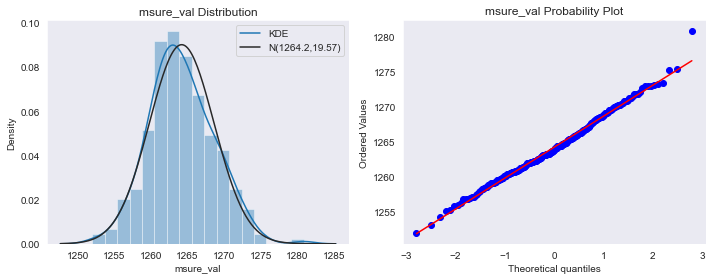

In [62]:
predict['msure_val'] = model_br.predict(df_predict_final_ohe[COLS_ohe])
QQ_plot(predict['msure_val'], 'msure_val')

# RF

In [64]:
def objective_RF(trial):
    param = {
#             "device_type": trial.suggest_categorical("device_type", ['gpu']),
            "n_estimators": trial.suggest_int("n_estimators", 100, 2000, step=10),
            'max_depth': trial.suggest_int('max_depth', 1, 12),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 30)
    }
        
    X = df_final_ohe[COLS_ohe]
    y = df_final_ohe['y']

    model = RandomForestRegressor(**param, random_state=42)  
    cv = KFold(5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
    scores = np.sqrt(-scores)
    print(f'CV scores : {scores}')
    print('Mean score : ', np.mean(scores))
    rmse_val = np.mean(scores)
     
    return rmse_val
    
sampler = TPESampler(seed=42)
study_rf = optuna.create_study(
            study_name="rf_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )

study_rf.optimize(objective_RF, n_trials=5)
print("Best Score:", study_rf.best_value)
print("Best trial:", study_rf.best_trial.params)
    
model_rf = RandomForestRegressor(**study_rf.best_params, random_state=42)
model_rf.fit(df_final_ohe[COLS_ohe], df_final_ohe['y'])
print('model training is completed')

[I 2022-07-26 23:04:09,532] A new study created in memory with name: rf_parameter_opt
[I 2022-07-26 23:05:13,909] Trial 0 finished with value: 7.493829466521855 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 7.493829466521855.


CV scores : [7.80733683 7.72221922 6.65878716 8.19600035 7.08480377]
Mean score :  7.493829466521855


[I 2022-07-26 23:05:28,896] Trial 1 finished with value: 7.757082709520984 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 7.493829466521855.


CV scores : [8.05488442 8.10516609 7.01780673 8.33435604 7.27320026]
Mean score :  7.757082709520984


[I 2022-07-26 23:06:46,675] Trial 2 finished with value: 7.622551527800672 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 0 with value: 7.493829466521855.


CV scores : [7.98140582 7.92440955 6.79552615 8.27083371 7.14058241]
Mean score :  7.622551527800672


[I 2022-07-26 23:08:19,099] Trial 3 finished with value: 7.588788767949145 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 0 with value: 7.493829466521855.


CV scores : [7.85737106 7.75219827 6.8893551  8.23762011 7.2073993 ]
Mean score :  7.588788767949145


[I 2022-07-26 23:09:21,347] Trial 4 finished with value: 7.415635285874968 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 4 with value: 7.415635285874968.


CV scores : [7.67967348 7.565792   6.58755847 8.17366272 7.07148976]
Mean score :  7.415635285874968
Best Score: 7.415635285874968
Best trial: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}
model training is completed


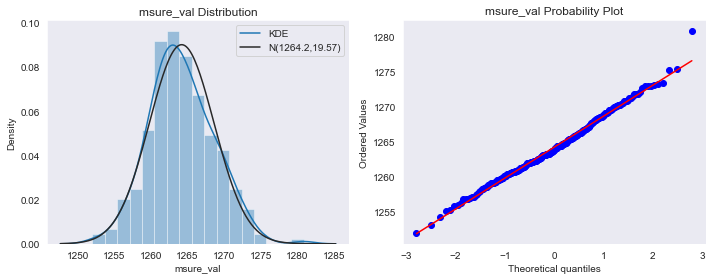

In [84]:
predict['msure_val'] = model_br.predict(df_predict_final_ohe[COLS_ohe])
QQ_plot(predict['msure_val'], 'msure_val')

In [66]:
with open('model_lgb.p', 'rb') as f:
    model_lgb = pickle.load(f)

In [76]:
QQ_plot(df_final['y'], 'y')

NameError: name 'QQ_plot' is not defined

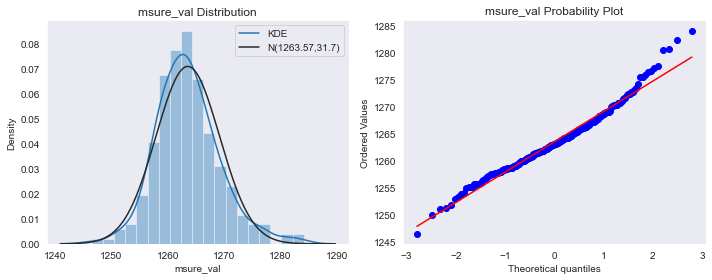

In [93]:
predict['msure_val'] = model_lgb.predict(df_predict_final[COLS])*0.1+model_en.predict(df_predict_final_ohe[COLS_ohe])*0.9
QQ_plot(predict['msure_val'], 'msure_val')

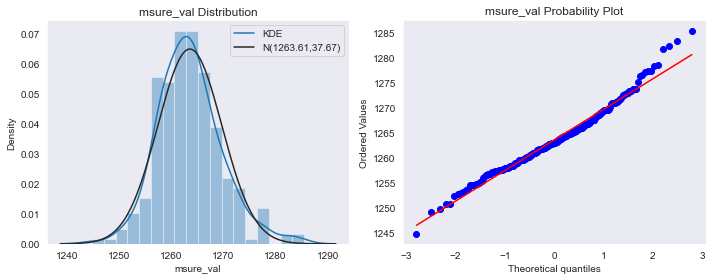

In [94]:
predict['msure_val'] = model_en.predict(df_predict_final_ohe[COLS_ohe])
QQ_plot(predict['msure_val'], 'msure_val')

In [95]:
predict['msure_val'] = model_en.predict(df_predict_final_ohe[COLS_ohe])
df_submission = predict[['key_val','msure_val']]
# 예측 파일을 저장합니다. 
# 제출용 파일 이름은 cds_submission_팀명_차수.csv 형태로 제출합니다.
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_37.csv')

In [96]:
df_submission.head(10)

,msure_val
key_val,
LOT380_17,1260.633911
LOT122_18,1256.647883
LOT313_18,1259.002778
LOT459_12,1259.642501
LOT459_18,1265.419188
LOT227_18,1260.918288
LOT51_18,1263.666847
LOT213_10,1262.376822
LOT380_15,1261.209975


In [78]:
model_en.predict(df_predict_final_ohe[COLS_ohe])

array([1260.63391136, 1256.64788319, 1259.00277786, 1259.6425014 ,
       1265.41918803, 1260.91828786, 1263.66684659, 1262.37682213,
       1261.20997505, 1257.41757036, 1258.51556781, 1262.70884855,
       1264.72670836, 1257.38989341, 1252.41484124, 1256.25811141,
       1252.86143329, 1249.24920445, 1254.55681561, 1264.66510931,
       1264.43388567, 1254.96479004, 1253.62285451, 1253.88238902,
       1254.86576659, 1253.02812957, 1259.54864546, 1258.35505929,
       1266.15192657, 1265.84596798, 1261.88334659, 1264.14107817,
       1257.58558266, 1261.68933345, 1263.99862092, 1265.49970708,
       1265.29226262, 1264.87012715, 1272.72718088, 1273.39189915,
       1259.73449643, 1264.23421259, 1266.83819119, 1265.28595396,
       1255.40887721, 1259.06273029, 1260.2255689 , 1260.20268459,
       1262.48116429, 1264.73400314, 1266.89338166, 1258.31201208,
       1257.76958746, 1249.80639419, 1257.54075879, 1269.61836787,
       1267.58252972, 1269.72068023, 1265.21292186, 1262.32900

In [79]:
model_br.predict(df_predict_final_ohe[COLS_ohe])

array([1260.89191112, 1257.05262011, 1258.21553192, 1260.4121406 ,
       1263.52119831, 1261.68196776, 1265.43572221, 1263.21712571,
       1262.23728736, 1259.65877813, 1259.84452049, 1263.31751825,
       1264.7777777 , 1265.86494083, 1260.98436507, 1264.73780676,
       1261.27288645, 1257.78343675, 1261.5081333 , 1264.57215018,
       1262.06089451, 1258.74398708, 1258.7594394 , 1256.71513223,
       1261.30489269, 1257.27591566, 1262.1684913 , 1260.90354226,
       1266.6606084 , 1264.02755079, 1260.66858875, 1263.71359102,
       1260.68461825, 1261.75718836, 1264.76621344, 1265.86490314,
       1263.20135128, 1264.42946235, 1269.91929534, 1272.15000115,
       1260.09077173, 1262.6084596 , 1263.9220296 , 1261.99527968,
       1261.43991929, 1262.0777036 , 1263.52729395, 1263.12557178,
       1263.02043043, 1264.71001735, 1266.57319176, 1256.94043563,
       1258.15354568, 1253.06113327, 1258.2783262 , 1270.26730701,
       1270.19873743, 1268.74257891, 1267.22652442, 1265.33881

# Feature Selection

In [66]:
from probatus.feature_elimination import EarlyStoppingShapRFECV

#### LGB SHAP

In [ ]:
shap_elimination_lgb = EarlyStoppingShapRFECV(
    clf=model_lgb, step=0.2, cv=10, scoring='neg_mean_squared_error', early_stopping_rounds=15, n_jobs=-1, eval_metric='rmse')
report_lgb = shap_elimination_lgb.fit_compute(df_final_ohe[COLS_ohe], df_final_ohe['y'], feature_perturbation="tree_path_dependent")

performance_plot_lgb = shap_elimination_lgb.plot()

In [36]:
report.loc[:, report.filter(regex='mean').columns.tolist()] = np.sqrt(-report.filter(regex='mean'))
SELECTED_COLS = report.loc[report['val_metric_mean'] == report['val_metric_mean'].min(),:]['features_set'].values.tolist()[0]
SELECTED_COLS

['04_gas_para51',
 '18_efem_para2',
 '20_gas_para39',
 '06_weekday_sin',
 '06_gas_para59',
 '06_temp_para23',
 'gen_tmdiff_0612',
 '04_date_sin',
 'gen_tmdiff',
 '18_date_sin',
 '06_position_para72',
 '13_power_para82',
 '06_temp_para54',
 '13_time_para37']

#### XGB SHAP

In [ ]:
shap_elimination_xgb = EarlyStoppingShapRFECV(
    clf=model_xgb, step=1, cv=10, scoring='neg_mean_squared_error', early_stopping_rounds=15, n_jobs=-1, eval_metric='rmse')
report_xgb = shap_elimination_xgb.fit_compute(df_final_ohe[COLS_ohe], df_final_ohe['y'], feature_perturbation="tree_path_dependent")

performance_plot_xgb = shap_elimination_xgb.plot()

#### GBR SHAP

In [ ]:
shap_elimination_gbr = EarlyStoppingShapRFECV(
    clf=model_gbr, step=1, cv=10, scoring='neg_mean_squared_error', early_stopping_rounds=15, n_jobs=-1, eval_metric='rmse')
report_gbr = shap_elimination_gbr.fit_compute(df_final_ohe[COLS_ohe], df_final_ohe['y'], feature_perturbation="tree_path_dependent")

performance_plot_gbr = shap_elimination_gbr.plot()

#### ET SHAP

In [ ]:
shap_elimination_et = EarlyStoppingShapRFECV(
    clf=model_et, step=1, cv=10, scoring='neg_mean_squared_error', early_stopping_rounds=15, n_jobs=-1, eval_metric='rmse')
report_et = shap_elimination_et.fit_compute(df_final_ohe[COLS_ohe], df_final_ohe['y'], feature_perturbation="tree_path_dependent")

performance_plot_et = shap_elimination_et.plot()

#### EN SHAP

In [ ]:
shap_elimination_en = EarlyStoppingShapRFECV(
    clf=model_en, step=1, cv=10, scoring='neg_mean_squared_error', early_stopping_rounds=15, n_jobs=-1, eval_metric='rmse')
report_en = shap_elimination_en.fit_compute(df_final_ohe[COLS_ohe], df_final_ohe['y'], feature_perturbation="tree_path_dependent")

performance_plot_en = shap_elimination_en.plot()

In [82]:
# LGB
def objective_LGB(trial):
    param_lgb = {
            'objective':'regression',
            'metric':'rmse',
            "random_state":42,
            'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.2, step=0.01),
#             "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 4e-5),
#             "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
            'feature_fraction' :trial.suggest_float('feature_fraction', 0.1, 1.0, step=0.1),
            "n_estimators":trial.suggest_int("n_estimators", 100, 2000, step=10),
            "max_depth":-1,
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
            "max_bin": trial.suggest_int("max_bin", 100, 500)
    }
    X = df_final_ohe[COLS_ohe]
    y = np.log1p(df_final['y'])

    model = lgb.LGBMRegressor(**param_lgb)
    cv = KFold(11, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
    scores = np.sqrt(-scores)
    print(f'CV scores : {scores}')
    print('Mean score : ', np.mean(scores))
    rmsle_val = np.mean(scores)
     
    return rmsle_val
    
sampler = TPESampler(seed=42)
study_lgb = optuna.create_study(
                study_name="lgb_parameter_opt",
                direction="minimize",
                sampler=sampler,
            )
study_lgb.optimize(objective_LGB, n_trials=30)
print("Best Score:", study_lgb.best_value)
print("Best trial:", study_lgb.best_trial.params)
    
model_lgb = lgb.LGBMRegressor(**study_lgb.best_params, objective='regression', metric='rmse', random_state=42)
model_lgb.fit(df_final_ohe[COLS_ohe], np.log1p(df_final['y']))
print('model training is completed')

[I 2022-07-28 23:07:41,716] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGB

[I 2022-07-28 23:07:52,618] Trial 0 finished with value: 0.0055306329636322085 and parameters: {'learning_rate': 0.08, 'feature_fraction': 1.0, 'n_estimators': 1490, 'min_child_samples': 62, 'max_bin': 162}. Best is trial 0 with value: 0.0055306329636322085.


CV scores : [0.00605117 0.00593885 0.00563244 0.00499368 0.00563178 0.00488486
 0.00592586 0.00504525 0.00529057 0.00579486 0.00564763]
Mean score :  0.0055306329636322085
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignor

[I 2022-07-28 23:07:59,530] Trial 1 finished with value: 0.005492955669804543 and parameters: {'learning_rate': 0.04, 'feature_fraction': 0.1, 'n_estimators': 1750, 'min_child_samples': 62, 'max_bin': 383}. Best is trial 1 with value: 0.005492955669804543.


CV scores : [0.00606903 0.00564625 0.00576277 0.00518611 0.00564548 0.00483414
 0.0060359  0.00519982 0.00526938 0.00574137 0.00503226]
Mean score :  0.005492955669804543
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignore

[I 2022-07-28 23:08:26,993] Trial 2 finished with value: 0.00551991037994413 and parameters: {'learning_rate': 0.01, 'feature_fraction': 1.0, 'n_estimators': 1680, 'min_child_samples': 25, 'max_bin': 172}. Best is trial 1 with value: 0.005492955669804543.


CV scores : [0.00570919 0.00582103 0.00547908 0.00514005 0.00567868 0.00498171
 0.00589149 0.00519643 0.00547386 0.00566776 0.00567973]
Mean score :  0.00551991037994413
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored


KeyboardInterrupt



In [55]:
C = report[report['num_features']==93]['features_set'].values.tolist()[0]

In [47]:
report

,num_features,features_set,eliminated_features,train_metric_mean,train_metric_std,val_metric_mean,val_metric_std
1,439,"[module_name_0, module_name_1, module_name_2, ...","[06_temp_para32, module_name_26, 18_esc_para84...",6.126255,12.929,7.740349,17.523
2,352,"[06_time_para43, 20_position_para72, 18_temp_p...","[04_fr_para61, 04_he_para88, 04_hv_para3, CLN_...",6.353503,6.799,7.853598,19.786
3,282,"[06_time_para43, 20_position_para72, 18_temp_p...","[04_temp_para53, 13_time_para90, 06_temp_para6...",6.170656,14.361,7.752290,18.560
4,226,"[06_time_para43, 20_position_para72, 18_temp_p...","[04_gas_para21, 20_time_para90, 04_tmp_para31,...",5.997083,11.523,7.711290,18.018
5,181,"[06_time_para43, 20_position_para72, 20_time_p...","[18_time_para81, 18_temp_para24, 18_temp_para6...",5.834381,11.814,7.642316,17.572
6,145,"[06_time_para43, 20_position_para72, 18_temp_p...","[20_hour_sin, 20_time_para41, 20_time_para34, ...",6.290389,8.697,7.718225,18.069
7,116,"[06_time_para43, 20_position_para72, 18_temp_p...","[06_time_para67, 06_epd_para40, 04_hv_para45, ...",5.692539,9.929,7.648660,16.922
8,93,"[20_time_para64, 06_temp_para65, 20_power_para...","[20_time_para29, 18_temp_para18, 06_temp_para5...",5.920726,9.859,7.547052,16.649
9,75,"[20_time_para64, 20_power_para82, 04_time_para...","[18_time_para64, 20_time_para75, 18_hv_para45,...",5.489900,10.461,7.508528,16.117
10,60,"[20_time_para64, 20_power_para82, 20_time_para...","[06_time_para37, 20_date_sin, 04_temp_para66, ...",5.774600,10.906,7.503133,16.346


In [106]:
with open('SELECTED_COLS65287.p', 'wb') as f:
    pickle.dump(C, f)

In [68]:
lgb_pred = model_lgb.predict(df_predict_final_ohe[C])

In [72]:
df_submission['msure_val'] = (df_submission['msure_val']*2+lgb_pred)/3
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_41.csv')

KeyError: "None of ['key_val'] are in the columns"

In [73]:
df_submission.head()

,msure_val
key_val,
LOT380_17,1263.907631
LOT122_18,1261.355581
LOT313_18,1260.584740
LOT459_12,1259.629300
LOT459_18,1259.647593


In [74]:
df_submission.to_csv('cds_submission_데이터조무사_41.csv')

# PYCARET

In [57]:
from pycaret.regression import *

In [94]:
for_pycaret = df_final_ohe[['y']+C].copy()
for_pycaret.head(1)

,y,20_time_para64,06_temp_para65,20_power_para82,04_time_para64,18_time_para64,18_temp_para18,20_efem_para25,06_epd_para63,20_time_para37,...,13_date_cos,06_time_para37,13_time_para30,06_efem_para25,04_date_cos,06_temp_para60,18_time_para29,13_power_para14,13_efem_para2,20_time_para8
0,1260.0892,132.73,22.02,10200.11,132.33,132.62,14.7,1642.46,0.0,132.73,...,-0.528964,132.33,2460.48,1640.06,-0.528964,36.93,723.88,7558.8,1630.92,132.73


In [95]:
sup = setup(for_pycaret, target = 'y', train_size = 0.8)

,Description,Value
0,session_id,3065
1,Target,y
2,Original Data,"(611, 94)"
3,Missing Values,False
4,Numeric Features,93
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(488, 50)"


In [96]:
comp = compare_models(sort = 'RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,5.4837,49.0100,6.9708,0.2362,0.0055,0.0043,0.0630
catboost,CatBoost Regressor,5.5689,48.9270,6.9764,0.2359,0.0055,0.0044,1.5750
lightgbm,Light Gradient Boosting Machine,5.6715,50.3883,7.0742,0.2114,0.0056,0.0045,0.0220
rf,Random Forest Regressor,5.6578,51.5031,7.1508,0.1996,0.0057,0.0045,0.0960
gbr,Gradient Boosting Regressor,5.7481,52.2178,7.2106,0.1828,0.0057,0.0045,0.0420
ada,AdaBoost Regressor,5.9133,54.3968,7.3525,0.1528,0.0058,0.0047,0.0260
xgboost,Extreme Gradient Boosting,5.9198,55.4248,7.4171,0.1341,0.0059,0.0047,0.2230
lr,Linear Regression,6.0079,58.4046,7.6238,0.0883,0.0060,0.0048,0.6700
ridge,Ridge Regression,6.0163,58.4342,7.6261,0.0886,0.0060,0.0048,0.0050
en,Elastic Net,6.1524,59.5003,7.6849,0.0767,0.0061,0.0049,0.0060


In [97]:
top1 = create_model('et', cross_validation = False)
top2 = create_model('catboost', cross_validation = False)
top3 = create_model('lightgbm', cross_validation = False)
top4 = create_model('rf', cross_validation = False)
top5 = create_model('gbr', cross_validation = False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,5.8216,55.62,7.4579,0.2485,0.0059,0.0046


In [98]:
tuned_et = tune_model(top1, optimize = 'RMSE', n_iter = 10)
tuned_cat = tune_model(top2, optimize = 'RMSE', n_iter = 10)
tuned_lgb = tune_model(top3, optimize = 'RMSE', n_iter = 10)
tuned_rf = tune_model(top4, optimize = 'RMSE', n_iter = 10)
tuned_gbr = tune_model(top5, optimize = 'RMSE', n_iter = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.5490,61.0623,7.8142,0.2699,0.0062,0.0044
1,6.1994,66.0157,8.1250,-0.0495,0.0064,0.0049
2,5.1103,39.6843,6.2995,0.3829,0.0050,0.0040
3,5.0854,38.5790,6.2112,0.2412,0.0049,0.0040
4,5.8778,49.0186,7.0013,0.3147,0.0055,0.0046
5,5.1366,41.3558,6.4308,0.3099,0.0051,0.0041
6,5.5556,45.2065,6.7236,0.3428,0.0053,0.0044
7,6.5085,60.1316,7.7545,0.0470,0.0061,0.0051
8,4.8745,40.4324,6.3587,0.2180,0.0050,0.0039


In [180]:
top6 = create_model('lightgbm', cross_validation = False)
top7 = create_model('catboost', cross_validation = False)
top8 = create_model('ada', cross_validation = False)
top9 = create_model('gbr', cross_validation = False)
top10 = create_model('et', cross_validation = False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,6.2799,63.3247,7.9577,0.1912,0.0063,0.005


In [181]:
tuned_lightgbm = tune_model(top6, optimize = 'RMSE', n_iter = 10)
tuned_catboost = tune_model(top7, optimize = 'RMSE', n_iter = 10)
tuned_ada = tune_model(top8, optimize = 'RMSE', n_iter = 10)
tuned_gbr = tune_model(top9, optimize = 'RMSE', n_iter = 10)
tuned_et = tune_model(top10, optimize = 'RMSE', n_iter = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,6.0100,55.2639,7.4340,0.0617,0.0059,0.0047
1,6.5911,65.7159,8.1065,-0.0327,0.0064,0.0052
2,5.1628,41.9312,6.4754,0.0951,0.0051,0.0041
3,5.7597,50.9571,7.1384,0.1173,0.0056,0.0046
4,5.9838,53.9211,7.3431,0.0971,0.0058,0.0047
5,5.7617,63.9481,7.9968,-0.0368,0.0063,0.0046
6,6.3507,61.3324,7.8315,0.0012,0.0062,0.0050
7,5.7828,54.5419,7.3852,0.0792,0.0058,0.0046
8,6.6176,67.7462,8.2308,0.1099,0.0065,0.0052
9,7.4048,85.2567,9.2335,0.0630,0.0073,0.0059


In [99]:
blender_specific = blend_models(estimator_list = [tuned_et,tuned_cat,tuned_lgb,tuned_rf,tuned_gbr],optimize = 'RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.7022,60.3902,7.7711,0.2780,0.0062,0.0045
1,5.9906,60.4479,7.7748,0.0390,0.0061,0.0047
2,5.2511,43.7648,6.6155,0.3194,0.0052,0.0042
3,4.7420,35.0630,5.9214,0.3103,0.0047,0.0038
4,6.1554,50.8708,7.1324,0.2888,0.0056,0.0049
5,5.4207,45.8994,6.7749,0.2341,0.0054,0.0043
6,5.4769,47.4026,6.8850,0.3108,0.0054,0.0043
7,5.9890,49.6316,7.0450,0.2134,0.0056,0.0047
8,4.7387,39.9845,6.3233,0.2267,0.0050,0.0038


In [100]:
final_model = finalize_model(blender_specific)
pred = predict_model(final_model, data=df_predict_final_ohe[C])

In [101]:
predict['msure_val'] = pred['Label']
df_submission = predict[['key_val', 'msure_val']]
df_submission.head()

,key_val,msure_val
0,LOT380_17,1264.122453
1,LOT122_18,1261.821281
2,LOT313_18,1260.845548
3,LOT459_12,1262.770134
4,LOT459_18,1262.999551


In [102]:
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_44.csv')

In [145]:
predict['msure_val'] = np.exp(model_xgb.predict(df_predict_final[COLS]))
df_submission = predict[['key_val', 'msure_val']] 
df_submission.head()

,key_val,msure_val
0,LOT380_17,1265.593262
1,LOT122_18,1264.421753
2,LOT313_18,1264.816772
3,LOT459_12,1262.429565
4,LOT459_18,1261.295288


In [146]:
# 예측 파일을 저장합니다. 
# 제출용 파일 이름은 cds_submission_팀명_차수.csv 형태로 제출합니다.
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_21.csv')

# CATBOOST REGRESSOR

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

In [ ]:
train_idxs = list(df_final.groupby('module_name')['key_val'].nunique().values)
predict_idxs = list(df_predict_final.groupby('module_name')['key_val'].nunique().values)

In [ ]:
len(train_idxs)

In [ ]:
cv = LeaveOneOut()
cats = [CatBoostRegressor() for i in range(47)]
idexss = 0
for i in range(len(train_idxs)):
    if i==0:
        train_idx = range(train_idxs[i])
        idexss += train_idxs[i]
    else:
        train_idx = range(train_idxs[i-1], idexss+train_idxs[i])
        idexss += train_idxs[i]
    X = df_final.loc[train_idx, num_features]
    y = df_final.loc[train_idx, 'y']
    cat = cats[i]
    scores = cross_val_score(cat, X, y, scoring='neg_mean_squared_error',
                             cv=cv, n_jobs=-1)
    scores = np.sqrt(scores)
    print(np.mean(scores))

# Feature Selection

In [156]:
from probatus.feature_elimination import EarlyStoppingShapRFECV

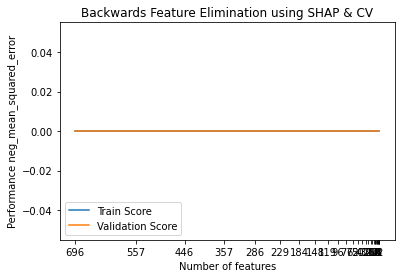

In [158]:
# Run feature elimination
shap_elimination = EarlyStoppingShapRFECV(
    clf=model_xgb, step=0.2, cv=10, scoring='neg_mean_squared_error', early_stopping_rounds=15, n_jobs=-1, eval_metric='rmse')
report = shap_elimination.fit_compute(df_final[COLS], np.log1p(df_final['y']))

# Make plots
performance_plot = shap_elimination.plot()

In [ ]:
report

In [159]:
# Get final feature set
''' num_features는 마지막에 남길 feature 수임. '''
final_features_set = shap_elimination.get_reduced_features_set(num_features=77)

The provided number of features has not been achieved at any stage of the process. You can select one of the following: [402, 322, 258, 207, 166, 133, 107, 86, 69, 56, 45, 36, 29, 24, 20, 16, 13, 11, 9, 8, 7, 6, 5, 4, 3, 2, 1]

In [160]:
final_features_set

['04_fr_para61',
 '18_hv_para3',
 '04_date_cos',
 '13_time_para62',
 '13_pressure_para91',
 '12_gas_para36',
 '17_time_para5',
 '12_time_para16',
 '04_position_para72',
 '06_temp_para65',
 '20_time_para83',
 '06_time_para44',
 '12_temp_para11',
 '12_weekday_cos',
 '13_time_para9',
 '04_time_para77',
 '13_tmp_para31',
 '13_time_para37',
 '17_time_para77',
 '13_time_para77',
 '12_temp_para23',
 '18_time_para5',
 '18_time_para83',
 '06_time_para9',
 '20_temp_para55',
 '17_time_para41',
 '13_gas_para73',
 '20_he_para88',
 '18_efem_para25',
 '17_tmp_para31',
 '12_time_para9',
 '20_time_para9',
 '04_temp_para65',
 '12_gas_para50',
 '17_time_para29',
 '18_time_para77',
 '20_temp_para65',
 '20_temp_para93',
 '04_temp_para18',
 '18_time_para42',
 '20_time_para37',
 '12_temp_para87',
 '06_gas_para73',
 '06_gas_para21',
 '12_time_para44',
 '17_he_para88',
 '12_time_para89',
 '17_time_para83',
 '06_power_para76',
 '06_power_para57',
 '12_fr_para28',
 '06_gas_para33',
 '04_temp_para55',
 '13_time_p

# 예측 결과 제출

In [ ]:
df_predict.head()

In [ ]:
pred_X = pd.get_dummies(df_predict[COLS])

In [ ]:
predict['msure_val'] = np.exp(cat.predict(df_predict_final[COLS]))
df_submission = predict[['key_val', 'msure_val']] 
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_12.csv')
df_submission.head()

In [ ]:
# 예측값에 결측치가 포함되어 있는지 확인합니다.
df_submission.isnull().sum()

In [ ]:
# 예측값의 갯수가 평가용 데이터의 갯수와 동일한지 확인합니다.
assert len(df_submission) == len(predict)
print(f'No. of Predict DataSet : {len(predict)}\nNo. of Submission DataSet : {len(df_submission)}')

In [ ]:
# 예측 파일을 저장합니다. 
# 제출용 파일 이름은 cds_submission_팀명_차수.csv 형태로 제출합니다.
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_12.csv')

# module 별 LeaveOneOut으로 모델링해보기

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

In [ ]:
train_idxs = list(df_final.groupby('module_name')['key_val'].nunique().values)
predict_idxs = list(df_predict_final.groupby('module_name')['key_val'].nunique().values)

In [ ]:
cv = LeaveOneOut()
cats = [CatBoostRegressor() for i in range(47)]
for i in range(len(idx)):
    if i==0:
        train_idx = range(idx[i])
    else:
        train_idx = range(idx[i-1], idx[i])
    

scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)

In [ ]:
mean(scores)

# Optuna + CatRegressor

In [ ]:
cats = [CatBoostRegressor() for i in range(47)]
idexss = 0
for i,idx in enumerate(train_idxs):
    if i==0:
        train_idx = range(idx)
        idexss += idx
    else:
        train_idx = range(idexss, idexss+idx)
        idexss += idx
    X = df_final.loc[train_idx, num_features]
    y = df_final.loc[train_idx, 'y']
    
    def objective_CAT(trial):
        param = {
          "random_state":42,
          'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
          'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
    #       "n_estimators":trial.suggest_int("n_estimators", 100, 10000),
          "max_depth":trial.suggest_int("max_depth", 4, 12),
          'random_strength' :trial.suggest_int('random_strength', 0, 30),
    #       "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
          "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
          "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
          "max_bin": trial.suggest_int("max_bin", 200, 400),
          'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
          'boosting_type':trial.suggest_categorical('boosting_type', ['Plain', 'Ordered']),
          'task_type':'GPU',
          'devices':'0:7',
          'iterations':100,
          'rsm':1
      }
        X_cat = X
        y_cat = pd.Series(np.log1p(y))
        cv = LeaveOneOut()
        cat = cats[i]
        cat.set_params(**param)
        scores = cross_val_score(cat, X_cat, y_cat, scoring='neg_mean_squared_error',
                                 cv=cv)
        scores = np.sqrt(-scores)

        return np.mean(scores)
    
    sampler = TPESampler(seed=42)
    study = optuna.create_study(
            study_name="cat_parameter_opt",
            direction="minimize",
            sampler=sampler
    )
    study.optimize(objective_CAT, n_trials=3)
    print("Best Score:", study.best_value)
    print("Best trial:", study.best_trial.params)
    CAT = CatBoostRegressor(**study.best_params)
    CAT.fit(X, np.log1p(y),verbose=0)
    cats[i] = CAT
    print('{}번째 모델 훈련이 완료되었습니다.'.format(i+1))

In [ ]:
pred = []
idexss_pred = 0
for i, (idx,model) in enumerate(zip(predict_idxs, cats)):
    if i == 0:
        pred_idx = range(idx)
        idexss_pred += idx
    else:
        pred_idx = range(idexss_pred, idexss_pred+idx)
        idexss_pred += idx
    X_pred = df_predict_final.loc[pred_idx, num_features]
    CAT_pred = model.predict(X_pred)
    pred.extend(CAT_pred)

In [ ]:
predict['msure_val'] = np.exp(pred)
df_submission = predict[['key_val', 'msure_val']] 
df_submission.head()

In [ ]:
len(df_submission)

In [ ]:
# 예측 파일을 저장합니다. 
# 제출용 파일 이름은 cds_submission_팀명_차수.csv 형태로 제출합니다.
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_15.csv')

# Cat 기본모델과 LooCV

In [ ]:
base_cat_params = {'task_type':'GPU','devices':'0:7','iterations':100,'rsm':1}
cats = [CatBoostRegressor(random_state=1,**base_cat_params) for i in range(47)]
idexss = 0
for i in range(len(train_idxs)):
    if i==0:
        train_idx = range(train_idxs[i])
        idexss += train_idxs[i]
    else:
        train_idx = range(train_idxs[i-1], idexss+train_idxs[i])
        idexss += train_idxs[i]
    X = df_final.loc[train_idx, num_features]
    y = df_final.loc[train_idx, 'y']
    
    
    X_cat = X
    y_cat = pd.Series(np.log1p(y))
    cv = LeaveOneOut()
    cat = cats[i]
    scores = cross_val_score(cat, X_cat, y_cat, scoring='neg_mean_squared_error',
                                cv=cv)
    scores = np.sqrt(-scores)
    print(np.mean(scores))
    
    cat.fit(X, np.log1p(y))
    cats[i] = CAT
    print('{}번째 모델 훈련이 완료되었습니다.'.format(i+1))

In [ ]:
cats = []
idexss = 0
for i in range(len(train_idxs)):
    if i==0:
        train_idx = range(train_idxs[i])
        idexss += train_idxs[i]
    else:
        train_idx = range(train_idxs[i-1], idexss+train_idxs[i])
        idexss += train_idxs[i]
    X = df_final.loc[train_idx, num_features]
    y = df_final.loc[train_idx, 'y']
    
    def objective_CAT(trial):
        param = {
          "random_state":42,
          'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
          'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
    #       "n_estimators":trial.suggest_int("n_estimators", 100, 10000),
          "max_depth":trial.suggest_int("max_depth", 4, 12),
          'random_strength' :trial.suggest_int('random_strength', 0, 30),
    #       "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
          "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
          "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
          "max_bin": trial.suggest_int("max_bin", 200, 400),
          'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
          'boosting_type':trial.suggest_categorical('boosting_type', ['Plain', 'Ordered']),
          'task_type':'GPU',
          'devices':'0:8',
          'iterations':50,
          'rsm':1
      }
        X_cat = X
        y_cat = pd.Series(np.log1p(y))
        loo = LeaveOneOut()
        cat = CatBoostRegressor(**param)
        loo.get_n_splits(X_cat)
        rmsle = []
        for train_idx, test_idx in loo.split(X_cat):
            cat.fit(X_cat.iloc[train_idx,:], y_cat.iloc[train_idx], eval_set=[(X_cat.iloc[test_idx,:],y_cat.iloc[test_idx])], early_stopping_rounds=15, silent=True)
            cat_pred = cat.predict(X_cat.iloc[test_idx,:])
            rmsle_val = np.sqrt(mean_squared_error(y_cat.iloc[test_idx], cat_pred))
            rmsle.append(rmsle_val)
        return np.mean(rmsle)
    
    sampler = TPESampler(seed=42)
    study = optuna.create_study(
            study_name="cat_parameter_opt",
            direction="minimize",
            sampler=sampler
    )
    study.optimize(objective_CAT, n_trials=3)
    print("Best Score:", study.best_value)
    print("Best trial:", study.best_trial.params)
    X_cat = X
    y_cat = pd.Series(np.log1p(y))
    loo = LeaveOneOut()
    CAT = CatBoostRegressor(**study.best_params)
    for train_idx, test_idx in loo.split(X_cat):
            CAT.fit(X_cat.iloc[train_idx,:], y_cat.iloc[train_idx], eval_set=[(X_cat.iloc[test_idx,:], y_cat.iloc[test_idx])], early_stopping_rounds=15)
    cats.append(CAT)
    print('{}번째 모델 훈련이 완료되었습니다.'.format(i+1))

In [ ]:
import lightgbm as lgb

In [ ]:
cats = []
idexss = 0
for i in range(len(train_idxs)):
    if i==0:
        train_idx = range(train_idxs[i])
        idexss += train_idxs[i]
    else:
        train_idx = range(train_idxs[i-1], idexss+train_idxs[i])
        idexss += train_idxs[i]
    X = df_final.loc[train_idx, num_features]
    y = df_final.loc[train_idx, 'y']
    
    def objective(trial):
        lgbm_param = {
            'objective': 'regression',
            'verbose': -1,
            'metric': 'rmsle', 
            'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1, log=True), 
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
            'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
            'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0),
            'max_depth': trial.suggest_int('max_depth',3, 15),
            'learning_rate': trial.suggest_uniform("learning_rate", 0.01, 0.5),
            'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
            'random_state':0
        }
        X_cat = X
        y_cat = pd.Series(np.log1p(y))
        loo = LeaveOneOut()
        cat = lgb.LGBMRegressor(**lgbm_param)
        loo.get_n_splits(X_cat)
        rmsle = []
        for train_idx, test_idx in loo.split(X_cat):
            cat.fit(X_cat.iloc[train_idx,:], y_cat.iloc[train_idx], eval_set=[(X_cat.iloc[test_idx,:],y_cat.iloc[test_idx])], early_stopping_rounds=15, eval_metric='rmse')
            cat_pred = cat.predict(X_cat.iloc[test_idx,:])
            rmsle_val = np.sqrt(mean_squared_error(y_cat.iloc[test_idx], cat_pred))
            rmsle.append(rmsle_val)
        return np.mean(rmsle)
    
    sampler = TPESampler(seed=42)
    study = optuna.create_study(
            study_name="lgb_parameter_opt",
            direction="minimize",
            sampler=sampler
    )
    study.optimize(objective, n_trials=3)
    print("Best Score:", study.best_value)
    print("Best trial:", study.best_trial.params)
    
    X_cat = X
    y_cat = pd.Series(np.log1p(y))
    loo = LeaveOneOut()
    CAT =  lgb.LGBMRegressor(**study.best_params)
    for train_idx, test_idx in loo.split(X_cat):
            CAT.fit(X_cat.iloc[train_idx,:], y_cat.iloc[train_idx], eval_set=[(X_cat.iloc[test_idx,:], y_cat.iloc[test_idx])], early_stopping_rounds=15, eval_metric='rmse')
    cats.append(CAT)
    print('{}번째 모델 훈련이 완료되었습니다.'.format(i+1))